# Debugging the inconsistency in saliency-based attribution for PEs using Full-Gradient

Models trained with a different seed show varying magnitudes of saliency-based attribution for the position embeddings, even in a toy setting. This notebook explores this problem by computing not only saliency-based attribution (using Full-Gradient) but also perturbation-based(?) attribution using KernelSHAP. We run toy experiments, analyzing models with both methods, which both return attribution values for all inputs and are therefore directly comparable.

## Usage

Run any of the implemented toy settings using the code below. The "Toy setting" chapter implements the following settings:

1) Two-class position only
2) Four-class mixed position and appearance
3) Four-class mixed position and appearance, with test set and patch size 2

The "Run" chapter executes the experiment by training models over a given range of hyperparameters and analyzing the learned models using the Full-Gradient method and the KernelSHAP method, both extended to support attribution of the position embeddings (PE). The experiment will save a scatterplot PDF to a named subdirectory of `debug-attribution-variance-plots` (which needs to be created before the experiment is run).

In [1]:
%load_ext autoreload

# Toy setting

Saves a scatterplot image to `debug-attribution-variance-plots` for each setting.

## Datasets

Run any of the three dataset cells below to use that dataset in the toy setting.

### Two-class position only

2 classes
36 training samples
36 test samples
36 analysis samples


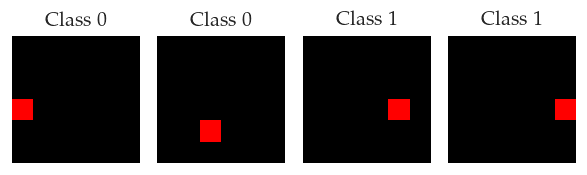

In [2]:
%autoreload
import datasets

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

images, labels, n_classes = datasets.dataset_absolute_position()
print(f"{n_classes} classes")
train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels = datasets.split_dataset(images, labels)

size = 6
patch_size = 1

fig, axs = plt.subplots(1, n_classes * 2, figsize=(1 + n_classes * 2, 2), dpi=120)
j = 0
for c in range(n_classes):
    for i in range(2):
        inds = train_labels == c
        axs[j].imshow(train_images[inds][i].permute((1, 2, 0)))
        axs[j].set_title(f"Class {train_labels[inds][i]}")
        axs[j].axis('off')
        j += 1

plt.tight_layout()
pass

### Two-class appearance only

2 classes
72 training samples
72 test samples
72 analysis samples


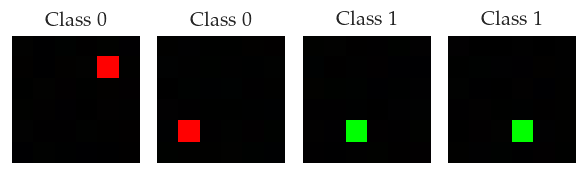

In [3]:
%autoreload
import datasets

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

images, labels, n_classes = datasets.dataset_appearance(size=[6,6])
print(f"{n_classes} classes")
train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels = datasets.split_dataset(images, labels)

size = 6
patch_size = 1

fig, axs = plt.subplots(1, n_classes * 2, figsize=(1 + n_classes * 2, 2), dpi=120)
j = 0
for c in range(n_classes):
    for i in range(2):
        inds = train_labels == c
        axs[j].imshow(train_images[inds][i].permute((1, 2, 0)))
        axs[j].set_title(f"Class {train_labels[inds][i]}")
        axs[j].axis('off')
        j += 1

plt.tight_layout()
pass

### Four-class mixed position and appearance

In [ ]:
%autoreload
import datasets

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

images, labels, n_classes = datasets.dataset_appearance_absolute_position_three_colors()
print(f"{n_classes} classes")
train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels = datasets.split_dataset(images, labels)

size = 6
patch_size = 1

fig, axs = plt.subplots(1, n_classes * 2, figsize=(1 + n_classes * 2, 2), dpi=120)
j = 0
for c in range(n_classes):
    for i in range(2):
        inds = train_labels == c
        axs[j].imshow(train_images[inds][i].permute((1, 2, 0)))
        axs[j].set_title(f"Class {train_labels[inds][i]}")
        axs[j].axis('off')
        j += 1

plt.tight_layout()
pass

### Four-class mixed position and appearance with test set and patch size 2

144 training samples
48 test samples
4 classes


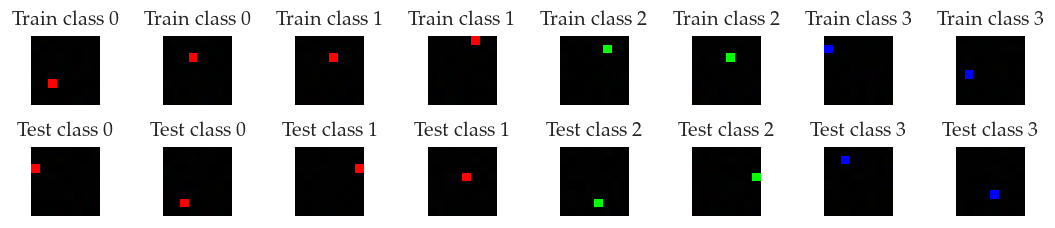

In [39]:
%autoreload
import datasets

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

train_images, train_labels, test_images, test_labels, n_classes = datasets.dataset_appearance_absolute_position_three_colors(size=[8,8], split_quadrants=True)
print(f"{n_classes} classes")

size = 8
patch_size = 2

fig, axs = plt.subplots(2, n_classes * 2, figsize=(1 + n_classes * 2, 2), dpi=120)
j = 0
for c in range(n_classes):
    for i in range(2):
        inds = train_labels == c
        axs[0,j].imshow(train_images[inds][i].permute((1, 2, 0)))
        axs[0,j].set_title(f"Train class {train_labels[inds][i]}")
        axs[0,j].axis('off')

        inds = test_labels == c
        axs[1,j].imshow(test_images[inds][i].permute((1, 2, 0)))
        axs[1,j].set_title(f"Test class {test_labels[inds][i]}")
        axs[1,j].axis('off')

        j += 1

plt.tight_layout()
pass

## Run

In [4]:
%autoreload
import pickle
from experiments import run
from attribution_analysis import attribution_stats, sens_scatterplots, shap_scatterplots

import pandas as pd
import seaborn as sns
import tqdm
import numpy as np

# Train / hybrid
# seeds = range(10)
seeds = [0, 1, 2]
# n_epochs = 4000
n_epochs = 500
report_every_n = 100
pos_emb = 'absolute'
use_rel_pos = False
save_raw = 'debug'
postprocessing = 'abs'
shap_bg_folds = 'all'

# Run 01
# run_name = "run01"
# debug = False
# lrs = [4e-2, 4e-3, 4e-4]
# weight_decays = [1e-3, 1e-4]
# ds = [8, 4]
# ns_heads = [4, 2]
# pos_emb_factors = [0.1, 0.01]
# postprocessing = 'abs'
# pos_add = 'add'

# Run 02: `WD=[1e-3, 1e-4], LR=[4e-4], d/n_heads=[16/8, 12/6, 8/4, 4/2], PEx=[0.02, 0.01, 0.005]`
# run_name = "run02"
# debug = False
# lrs = [4e-4]
# weight_decays = [1e-3, 1e-4]
# # ds = [12, 8]
# # ns_heads = [6, 4]
# ds = [16]
# ns_heads = [8]
# pos_emb_factors = [0.02, 0.01, 0.005]
# postprocessing = 'abs'
# pos_add = 'add'

# Run 03: `WD=[1e-3, 1e-4], LR=[4e-4], d/n_heads=[16/8, 16/4, 16/2], PEx=[0.02]`
# run_name = "run03"
# debug = False
# lrs = [4e-4]
# weight_decays = [1e-3, 1e-4]
# # ds = [16]
# # ns_heads = [8]
# ds = [16, 16]
# ns_heads = [4, 2]
# pos_emb_factors = [0.02]
# postprocessing = 'abs'
# pos_add = 'add'

# Run 04: more seeds
# run_name = "run04"
# debug = False
# lrs = [4e-4]
# weight_decays = [1e-4]
# ds = [16]
# ns_heads = [8]
# pos_emb_factors = [0.02]
# seeds = range(10)
# postprocessing = 'abs'
# pos_add = 'add'

# Run 05: without postprocessing
# run_name = "run05"
# debug = False
# lrs = [4e-4]
# weight_decays = [1e-4]
# ds = [16]
# ns_heads = [8]
# pos_emb_factors = [0.02]
# seeds = range(3)
# postprocessing = 'none'
# pos_add = 'add'

# Run 06: no postprocessing, wider search
# run_name = "run06"
# debug = False
# lrs = [4e-2, 4e-3, 4e-4]
# weight_decays = [1e-3, 1e-4]
# ds = [16, 16, 4]
# ns_heads = [8, 4, 2]
# pos_emb_factors = [0.1, 0.02]
# seeds = range(3)
# postprocessing = 'none'
# pos_add = 'add'

# Run 07: post-processing "abs", pos_add concat_equald, wider search
# run_name = "run07"
# debug = False
# lrs = [4e-2, 4e-3, 4e-4]
# weight_decays = [1e-3, 1e-4]
# ds = [16, 16, 4]
# ns_heads = [8, 4, 2]
# pos_emb_factors = [0.1, 0.02]
# seeds = range(3)
# postprocessing = 'abs'
# pos_add = 'concat_equald'

# Run 08: best settings from run 07, with more seeds
# run_name = "run08"
# debug = False
# lrs = [4e-3]
# weight_decays = [1e-3]
# ds = [16]
# ns_heads = [4]
# pos_emb_factors = [0.1, 0.02]
# seeds = range(10)
# postprocessing = 'abs'
# pos_add = 'concat_equald'

# Run 09: wide search, post-processing "max" with pos_add concat_equald
# run_name = "run09"
# debug = False
# lrs = [4e-2, 4e-3, 4e-4]
# weight_decays = [1e-3, 1e-4]
# ds = [16]
# ns_heads = [4]
# pos_emb_factors = [0.1, 0.02]
# seeds = range(3)
# postprocessing = 'max'
# pos_add = 'concat_equald'

# Run 10: wide search on new setting with test set
# run_name = "run10"
# debug = False
# lrs = [4e-2, 4e-3, 4e-4]
# weight_decays = [1e-3, 1e-4]
# ds = [16, 16]
# ns_heads = [8, 4]
# pos_emb_factors = [0.1, 0.02]
# seeds = range(5)
# postprocessings = ['abs', 'none', 'max']
# pos_adds = ['add', 'concat_equald']

# Run 12: narrowed search (based on run 11 results) on mixed+test
# with FG and SHAP
# run_name = "run12-sens+shap-mixed+test"
# debug = False
# lrs = [4e-3]
# weight_decays = [1e-4]
# # ds = [4, 8]
# # ns_heads = [2, 4]
# # ds = [4, 8, 8]
# # ns_heads = [2, 4, 2]
# ds = [12]
# ns_heads = [4]
# pos_emb_factors = [0.1, 0.02]
# seeds = range(5)
# postprocessings = ['abs']
# pos_adds = ['add', 'concat_equald']
# shap_bg_folds = 'all'

# Run 13: narrowed search (based on run 11 results) on position-only with FG and
# SHAP
# run_name = "run13-sens+shap-posonly"
# debug = False
# lrs = [4e-3]
# weight_decays = [1e-4]
# ds = [4, 8, 12]
# ns_heads = [2, 4, 4]
# pos_emb_factors = [0.1, 0.02]
# seeds = range(5)
# postprocessings = ['abs']
# pos_adds = ['add', 'concat_equald']
# shap_bg_folds = 'all'

# Run 14: same but with appearance only dataset
run_name = "run14-sens+shap-apponly"
debug = False
lrs = [4e-3]
weight_decays = [1e-4]
ds = [4]
ns_heads = [2]
pos_emb_factors = [0.1, 0.02]
seeds = range(5)
postprocessings = ['abs']
pos_adds = ['add', 'concat_equald']
shap_bg_folds = 'all'

# DEBUG
# run_name = 'debug'
# debug = False
# lrs = [4e-3]
# weight_decays = [1e-3]
# ds = [4]
# ns_heads = [2]
# pos_emb_factors = [0.1]
# postprocessings = ['abs']
# pos_adds = ['concat_equald']
# seeds = [0]
# shap_bg_folds = 1


analysis_results = {}

for weight_decay in tqdm.notebook.tqdm(weight_decays, desc='weight_decays', leave=False):
    for lr in tqdm.notebook.tqdm(lrs, desc='lrs', leave=False):
        for d, n_heads in tqdm.notebook.tqdm(zip(ds, ns_heads), desc='ds/n_heads', leave=False, total=len(ds)):
            for pos_emb_factor in tqdm.notebook.tqdm(pos_emb_factors, desc='pos_emb_factors', leave=False):
                for postprocessing in tqdm.notebook.tqdm(postprocessings, desc='postprocessings', leave=False):
                    for pos_add in tqdm.notebook.tqdm(pos_adds, desc='pos_adds', leave=False):
                        #
                        # TRAIN
                        #

                        print(f"\n\nWeight decay: {weight_decay} / LR: {lr} / d: {d} / n_heads: {n_heads} / PE factor: {pos_emb_factor} / Post-processing: {postprocessing} / pos_add: {pos_add}")
                        _, accs, _, _, image_shap_values, pe_shap_values = \
                            run('absolute_position', seeds, n_epochs, lr, d, n_heads,
                                n_classes, pos_emb, use_rel_pos, train_images, train_labels,
                                test_images, test_labels, test_images, test_labels,
                                size=size,
                                report_every_n=report_every_n, weight_decay=weight_decay,
                                pos_emb_factor=pos_emb_factor, pos_add=pos_add,
                                patch_size=patch_size, save_raw=save_raw,
                                sensitivity_analysis=True, do_shap='kernel', shap_bg_folds=shap_bg_folds)

                        #
                        # ANALYSIS settings
                        #

                        # Sensitivity settings
                        batched = False
                        # Use the filepath composed in the training cell
                        image_source = 'saved'
                        dataset_images = None
                        pos_emb_emb_dim = 0
                        # Normalize saliency maps by the maximum over all maps or by itself
                        rank_by = 'pos_emb'
                        sens_rows = 1

                        # SHAP settings
                        plot_pe_shap_sum = False
                        plot_pe_sum_frac = True
                        plot_label_sum_frac = False
                        shap_rows = 1

                        #
                        # PLOTTING SETUP
                        #

                        rows = sens_rows + shap_rows
                        fig, axs = plt.subplots(rows, len(seeds), figsize=(4 * len(seeds), 4 * rows), dpi=120)
                        if len(seeds) == 1:
                            axs = np.expand_dims(axs, 1)
                        plot_name = f"WD_{weight_decay}-LR_{lr}-n_epochs_{n_epochs}-d_{d}-n_heads_{n_heads}-PEx_{pos_emb_factor}-post_{postprocessing}-PE+_{pos_add}-seeds_{'_'.join(map(str, seeds))}"
                        # If the task failed to reach 100% accuracy, mark
                        # this in the name and prevent the seed from being
                        # marked as a success
                        seeds_fail = []
                        for i, acc in enumerate(accs):
                            if acc < 1.0:
                                plot_name += f"-S{i}ACC{acc:.3f}"
                                seeds_fail.append(i)
                        fig.suptitle(f"PE vs. non-PE attribution / {plot_name}")

                        indexes = []
                        for i, seed in enumerate(seeds):
                            #
                            # FG PLOTTING
                            #

                            filepath = f"./toy_saliency_maps/debug_{seed}.pt"
                            index = attribution_stats(filepath, batched, rank_by=rank_by, postprocessing=postprocessing)
                            indexes.append(index)

                        setting_analysis_results = sens_scatterplots(indexes, seeds, accs, axs)

                        #
                        # SHAP PLOTTING
                        #

                        shap_results = \
                            shap_scatterplots(image_shap_values, pe_shap_values,
                                              seeds, axs, n_classes, test_labels,
                                              start_row=sens_rows,
                                              plot_pe_shap_sum=plot_pe_shap_sum,
                                              plot_pe_sum_frac=plot_pe_sum_frac,
                                              plot_label_sum_frac=plot_label_sum_frac)
                        for i, _ in enumerate(seeds):
                            setting_analysis_results[i].update(shap_results[i])

                        #
                        # Finish plotting
                        #

                        # Put success/fail in the plot name
                        for i, seed in enumerate(seeds):
                            if setting_analysis_results[i]['sens_success']:
                                plot_name += f"-S{i}SENSSUCCESS"
                            if setting_analysis_results[i]['shap_success']:
                                plot_name += f"-S{i}SHAPSUCCESS"

                        plt.tight_layout()
                        if not debug:
                            plt.savefig(f"debug-attribution-variance-plots/{run_name}/{plot_name}.pdf")
                            plt.close()

                        analysis_results[plot_name] = setting_analysis_results

                        # Write analysis_results to disk after each setting
                        with open(f"debug-attribution-variance-plots/{run_name}/analysis_results.pkl", 'wb') as f:
                            pickle.dump(analysis_results, f)

/home/robert-jan/surfdrive/experiments/vit-position-info/models/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


weight_decays:   0%|          | 0/1 [00:00<?, ?it/s]

lrs:   0%|          | 0/1 [00:00<?, ?it/s]

ds/n_heads:   0%|          | 0/1 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 4 / n_heads: 2 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7161043882369995
Epoch 100: 0.0016541358781978488
Epoch 200: 0.0004833612183574587
Epoch 300: 0.00023822284128982574
Epoch 400: 0.00014694101992063224
Epoch 499: 0.00010382251639384776
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_0.pt


KernelSHAP:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 0: 0.6998245120048523
Epoch 100: 0.000919896992854774
Epoch 200: 0.00031843199394643307
Epoch 300: 0.0001753621909301728
Epoch 400: 0.00011746004747692496
Epoch 499: 8.886554860509932e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_1.pt


KernelSHAP:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 0: 0.7416425347328186
Epoch 100: 0.00150485138874501
Epoch 200: 0.00023699698795098811
Epoch 300: 0.00013276009121909738
Epoch 400: 9.411603969056159e-05
Epoch 499: 7.601275865454227e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_2.pt


KernelSHAP:   0%|          | 0/18 [00:00<?, ?it/s]

## Results

In [ ]:
analysis_results.keys()

# Post-hoc analysis on pickes

## Load pickles

In [38]:
run_name_pe_mixing = ('PE-mixing', 'run15-sens+shap-mixed+test-fixsave2')
run_name_pe_not_using = ('PE-not-using', 'run18-sens+shap-app-p2+test-fixsave2')
run_name_pe_using = ('PE-using', 'run19-sens+shap-pos-p2+test-fixsave2')
run_name_pe_mixing_nospatial = ('PE-mixing-nospatial', 'run22-sens+shap-mixed+test-nospatial')
directory = lambda rn: f"debug-attribution-variance-results/{rn}"

# Manually removed settings that failed to reach 100% accuracy
# (setting_name, seeds that failed)
failed_training_runs = {
    "PE-mixing": [
        ("WD_0.0001-LR_0.04-dnheads_4+2-PEx_0.1-post_abs-PE+_add", [0]),
        ("WD_0.001-LR_0.004-dnheads_4+2-PEx_0.1-post_abs-PE+_concat_equald", [3]),
        ("WD_0.001-LR_0.004-dnheads_4+2-PEx_0.02-post_abs-PE+_concat_equald", [1]),
        ("WD_0.001-LR_0.004-dnheads_24+4-PEx_0.02-post_abs-PE+_add", [1]),
        ("WD_0.001-LR_0.004-dnheads_24+6-PEx_0.02-post_abs-PE+_add", [2, 3]),
    ],
    "PE-not-using": [
        ("WD_0.0001-LR_0.04-dnheads_8+4-PEx_0.1-post_abs-PE+_add", [1]),
        ("WD_0.0001-LR_0.04-dnheads_24+4-PEx_0.1-post_abs-PE+_add", [2]),
        ("WD_0.0001-LR_0.04-dnheads_24+6-PEx_0.1-post_abs-PE+_add", [2]),
    ],
    "PE-using": [
        ("WD_0.0001-LR_0.04-dnheads_4+2-PEx_0.1-post_abs-PE+_add", [2]),
        ("WD_0.0001-LR_0.04-dnheads_4+2-PEx_0.1-post_abs-PE+_concat_equald", [0, 1]),
        ("WD_0.001-LR_0.004-dnheads_4+2-PEx_0.1-post_abs-PE+_concat_equald", [0, 1, 4]),
        ("WD_0.0001-LR_0.04-dnheads_8+4-PEx_0.1-post_abs-PE+_add", [0, 1, 4]),
        ("WD_0.0001-LR_0.04-dnheads_16+4-PEx_0.1-post_abs-PE+_add", [1]),
        ("WD_0.001-LR_0.004-dnheads_16+4-PEx_0.02-post_abs-PE+_concat_equald", [2]),
        ("WD_0.0001-LR_0.04-dnheads_24+4-PEx_0.1-post_abs-PE+_add", [0, 1, 4]),
        ("WD_0.0001-LR_0.04-dnheads_24+6-PEx_0.1-post_abs-PE+_concat_equald", [0, 4]),
    ],

}

# # September 25th run
# run_name_pe_mixing = ('PE-mixing', 'run20-sens+shap-mixed+test-capacity')
# # run_name_pe_not_using = ('PE-not-using', 'run18-sens+shap-app-p2+test-fixsave2')
# # run_name_pe_using = ('PE-using', 'run19-sens+shap-pos-p2+test-fixsave2')
# directory = lambda rn: f"debug-attribution-variance-results/{rn}"
# failed_training_runs = {}

# # Run 21 for tokens
# run_name_pe_mixing = ('PE-mixing', 'run21-get-tokens')
# directory = lambda rn: f"debug-attribution-variance-results/{rn}"
# failed_training_runs = {}

# Debug: testing interface differences
# run_name_pe_mixing = ('PE-mixing', 'debug-test-interface-old')
# directory = lambda rn: f"debug-attribution-variance-results/{rn}"
# failed_training_runs = {}

# # DEBUG
# run_name_pe_mixing = ('PE-mixing', 'debug')
# directory = lambda rn: f"debug-attribution-variance-results/{rn}"
# failed_training_runs = {}

# Find all pickles
import os
import pickle
import re

data = {}
# for pe_mode, run_name in [run_name_pe_mixing, run_name_pe_not_using, run_name_pe_using]:
for pe_mode, run_name in [run_name_pe_mixing, run_name_pe_mixing_nospatial]:
    pickles = []
    for root, dirs, files in os.walk(directory(run_name)):
        for file in files:
            if file.startswith('analysis_results') and file.endswith(".pkl"):
                try:
                    _, _, index = file.split('_')
                    pickles.append((int(index[:-4]), os.path.join(root, file)))
                except:
                    print(f"Invalid file name syntax: {file}")

    pickles = sorted(pickles, key=lambda x: x[0])
    print(f"Found {len(pickles)} pickles for {pe_mode}")

    data[pe_mode] = {}
    for i, pckle in pickles:
        with open(pckle, 'rb') as f:
            setting_data = pickle.load(f)

        setting_name = setting_data[0]['setting_name']

        if 'n_blocks_1-' in setting_name:
            setting_name = setting_name.replace('n_blocks_1-', '')

        if setting_name in data[pe_mode]:
            print(f"WARNING: {setting_name} already exists in data; additional data will be appended as extra seeds.")
        else:
            data[pe_mode][setting_name] = []

        for si, seed_data in enumerate(setting_data):
            # Don't load seeds manually marked as failing to train
            load_seed = True
            if pe_mode in failed_training_runs:
                for failed_setting, failed_seeds in failed_training_runs[pe_mode]:
                    if seed_data['setting_name'] == failed_setting and seed_data['seed'] in failed_seeds:
                        load_seed = False
            if not load_seed:
                # Skip loading this seed, since it failed to train
                continue

            # Backwards compatibility: If test_acc is not set, add it in
            # manually for backwards compatibility with runs before run 20
            if 'test_acc' not in seed_data:
                seed_data['test_acc'] = 1.0

            # Backwards compatibility: correct glitch in PE-not-using: all
            # labels < 2 are saved as PE-using, but they are PE-not-using
            if pe_mode == 'PE-not-using':
                seed_data['shap_df']['uses-PE'] = False
                seed_data['sens_df']['uses-PE'] = False
            if pe_mode == 'PE-using':
                seed_data['shap_df']['uses-PE'] = True
                seed_data['sens_df']['uses-PE'] = True

            data[pe_mode][setting_name].append(seed_data)
            # assert not seed_data['sens_df'].empty, f"Empty sensitivity dataframe for {setting_name} seed {si}"
            # assert not seed_data['shap_df'].empty, f"Empty SHAP dataframe for {setting_name} seed {si}"

    seeds_loaded = sum([len(data[pe_mode][sd]) for sd in data[pe_mode]])
    print(f"PE mode {pe_mode}: loaded {len(data[pe_mode])} settings with {seeds_loaded} total seeds")

    # Check we've loaded the number of seeds we expect based off settings and manually determined bad training runs we removed
    if pe_mode in failed_training_runs:
        assert seeds_loaded == len(data[pe_mode]) * 5 - sum([len(s) for (_, s) in failed_training_runs[pe_mode]])

import numpy as np
import pandas as pd

# Check training accuracies, removing settings that failed on at least one seed
df = []
df_cols = ['pe_mode', 'lr', 'weight_decay', 'd', 'n_heads', 'pos_add']
to_remove = []
for pe_mode in data:
    for setting_name in data[pe_mode]:
        accs = np.array([s['test_acc'] for s in data[pe_mode][setting_name]])
        successes = accs == 1.0
        if not np.all(successes):
            print(f"Setting {pe_mode}/{setting_name} failed: {accs}")
            to_remove.append((pe_mode, setting_name))
        else:
            df.append([pe_mode] + [data[pe_mode][setting_name][0]['settings'][c] for c in df_cols[1:]])

for pe_mode, setting_name in to_remove:
    del data[pe_mode][setting_name]

Found 30 pickles for PE-mixing
PE mode PE-mixing: loaded 30 settings with 144 total seeds
Found 20 pickles for PE-mixing-nospatial
PE mode PE-mixing-nospatial: loaded 20 settings with 191 total seeds
Setting PE-mixing-nospatial/WD_0.001-LR_0.004-dnheads_12+2-PEx_0.1-post_abs-PE+_add failed: [1.        1.        1.        1.        1.        0.9791667 1.
 1.        1.        1.       ]
Setting PE-mixing-nospatial/WD_0.001-LR_0.004-dnheads_12+2-PEx_0.1-post_abs-PE+_concat_equald failed: [1.        1.        1.        1.        1.        1.        1.
 1.        1.        0.8333333]
Setting PE-mixing-nospatial/WD_0.001-LR_0.004-dnheads_24+4-PEx_0.1-post_abs-PE+_concat_equald failed: [1.        1.        1.        1.        1.        1.        1.
 1.        1.        0.9791667]


In [39]:
print("\n".join(data['PE-mixing'].keys()))
print()
print()
print("\n".join(data['PE-mixing-nospatial'].keys()))

WD_0.001-LR_0.004-dnheads_4+2-PEx_0.1-post_abs-PE+_concat_equald
WD_0.001-LR_0.004-dnheads_4+2-PEx_0.1-post_abs-PE+_add
WD_0.001-LR_0.004-dnheads_8+4-PEx_0.1-post_abs-PE+_concat_equald
WD_0.001-LR_0.004-dnheads_8+4-PEx_0.1-post_abs-PE+_add
WD_0.001-LR_0.004-dnheads_16+4-PEx_0.1-post_abs-PE+_concat_equald
WD_0.001-LR_0.004-dnheads_16+4-PEx_0.1-post_abs-PE+_add
WD_0.001-LR_0.004-dnheads_24+6-PEx_0.1-post_abs-PE+_concat_equald
WD_0.001-LR_0.004-dnheads_24+6-PEx_0.1-post_abs-PE+_add
WD_0.001-LR_0.004-dnheads_24+4-PEx_0.1-post_abs-PE+_concat_equald
WD_0.001-LR_0.004-dnheads_24+4-PEx_0.1-post_abs-PE+_add
WD_0.001-LR_0.004-dnheads_4+2-PEx_0.02-post_abs-PE+_concat_equald
WD_0.001-LR_0.004-dnheads_4+2-PEx_0.02-post_abs-PE+_add
WD_0.001-LR_0.004-dnheads_8+4-PEx_0.02-post_abs-PE+_concat_equald
WD_0.001-LR_0.004-dnheads_8+4-PEx_0.02-post_abs-PE+_add
WD_0.001-LR_0.004-dnheads_16+4-PEx_0.02-post_abs-PE+_concat_equald
WD_0.001-LR_0.004-dnheads_16+4-PEx_0.02-post_abs-PE+_add
WD_0.001-LR_0.004-dnheads_

### Hyperparameter tuning results

In [12]:
df = pd.DataFrame(df, columns=df_cols)
df = df.sort_values(by=['pos_add', 'n_heads', 'd', 'lr', 'weight_decay'])

# df = df[df['pe_mode'] == 'PE-mixing']

print(f"Total success rate of training: {len(df)} / 100 seeds achieved 100% test accuracy")

print(f"\nLR = 4e-2 & WD = 1e-3: {len(df[df['lr'] == 4e-2])} / 20")
print(f"LR = 4e-3 & WD = 1e-2: {len(df[(df['lr'] == 4e-3) & (df['weight_decay'] == 1e-2)])} / 20")
print(f"LR = 4e-3 & WD = 1e-3: {len(df[(df['lr'] == 4e-3) & (df['weight_decay'] == 1e-3)])} / 20")
print(f"LR = 4e-3 & WD = 1e-4: {len(df[(df['lr'] == 4e-3) & (df['weight_decay'] == 1e-4)])} / 20")
print(f"LR = 4e-4 & WD = 1e-3: {len(df[df['lr'] == 4e-4])} / 20")

print(f"\nFor best optimizer settings (LR = 4e-3, WD = 1e-3):")
df_best = df[(df['lr'] == 4e-3) & (df['weight_decay'] == 1e-3)]
print(f"PE+ = add: {len(df_best[df_best['pos_add'] == 'add'])} / 10")
print(f"PE+ = concat_equald: {len(df_best[df_best['pos_add'] == 'concat_equald'])} / 10")

df_best

Total success rate of training: 47 / 100 seeds achieved 100% test accuracy

LR = 4e-2 & WD = 1e-3: 10 / 20
LR = 4e-3 & WD = 1e-2: 0 / 20
LR = 4e-3 & WD = 1e-3: 37 / 20
LR = 4e-3 & WD = 1e-4: 0 / 20
LR = 4e-4 & WD = 1e-3: 0 / 20

For best optimizer settings (LR = 4e-3, WD = 1e-3):
PE+ = add: 19 / 10
PE+ = concat_equald: 18 / 10


pe_mode     lr  weight_decay   d  n_heads        pos_add
1             PE-mixing  0.004         0.001   4        2            add
11            PE-mixing  0.004         0.001   4        2            add
30  PE-mixing-nospatial  0.004         0.001   8        2            add
31  PE-mixing-nospatial  0.004         0.001  16        2            add
3             PE-mixing  0.004         0.001   8        4            add
13            PE-mixing  0.004         0.001   8        4            add
32  PE-mixing-nospatial  0.004         0.001   8        4            add
33  PE-mixing-nospatial  0.004         0.001  12        4            add
5             PE-mixing  0.004         0.001  16        4            add
15            PE-mixing  0.004         0.001  16        4            add
34  PE-mixing-nospatial  0.004         0.001  16        4            add
35  PE-mixing-nospatial  0.004         0.001  20        4            add
9             PE-mixing  0.004         0.001  24        4            add
19            PE-mixing  0.004         0.001  24        4            add
36  PE-mixing-nospatial  0.004         0.001  24        4            add
37  PE-mixing-nospatial  0.004         0.001  18        6            add
7             PE-mixing  0.004         0.001  24        6            add
17            PE-mixing  0.004         0.001  24        6            add
38  PE-mixing-nospatial  0.004         0.001  24        6            add
0             PE-mixing  0.004         0.001   4        2  concat_equald
10            PE-mixing  0.004         0.001   4        2  concat_equald
39  PE-mixing-nospatial  0.004         0.001   8        2  concat_equald
40  PE-mixing-nospatial  0.004         0.001  16        2  concat_equald
2             PE-mixing  0.004         0.001   8        4  concat_equald
12            PE-mixing  0.004         0.001   8        4  concat_equald
41  PE-mixing-nospatial  0.004         0.001   8        4  concat_equald
42  PE-mixing-nospatial  0.004         0.001  12        4  concat_equald
4             PE-mixing  0.004         0.001  16        4  concat_equald
14            PE-mixing  0.004         0.001  16        4  concat_equald
43  PE-mixing-nospatial  0.004         0.001  16        4  concat_equald
44  PE-mixing-nospatial  0.004         0.001  20        4  concat_equald
8             PE-mixing  0.004         0.001  24        4  concat_equald
18            PE-mixing  0.004         0.001  24        4  concat_equald
45  PE-mixing-nospatial  0.004         0.001  18        6  concat_equald
6             PE-mixing  0.004         0.001  24        6  concat_equald
16            PE-mixing  0.004         0.001  24        6  concat_equald
46  PE-mixing-nospatial  0.004         0.001  24        6  concat_equald

## Compute attribution tests

One-sided Mann-Whitney U-test on PE attribution

In [40]:
import pandas as pd
from torch import Tensor

# Settings
alpha = 0.05
# pe_modes = ['PE-mixing', 'PE-separated']
pe_modes = ['PE-mixing', 'PE-mixing-nospatial']
do_sens = True


def pe_discriminated_test(df, col='pos_emb_all'):
    """
    Given a Pandas DataFrame describing the attribution values over all samples
    in the dataset, compute the one-sided Mann-Whitney U-test for the
    alternative hypothesis that the values in `col` are higher for the PE group
    than for the non-PE group, where the PE group is given by `uses-PE`.
    """
    from scipy.stats import mannwhitneyu

    # Get the indices of the two groups
    pe_inds = df['uses-PE']
    non_pe_inds = ~pe_inds

    if len(df.loc[pe_inds]) == 0 or len(df.loc[non_pe_inds]) == 0:
        pass

    # Get the values for the two groups
    pe_values = df.loc[pe_inds, col]
    non_pe_values = df.loc[non_pe_inds, col]

    # Perform the test
    _, p = mannwhitneyu(pe_values, non_pe_values, alternative='greater')
    return p

def mean_values(df, col='pos_emb_all'):
    # Get the indices of the two groups
    pe_inds = df['uses-PE']
    non_pe_inds = ~pe_inds

    if len(df.loc[pe_inds]) == 0 or len(df.loc[non_pe_inds]) == 0:
        pass

    # Get the values for the two groups
    pe_values = df.loc[pe_inds, col]
    non_pe_values = df.loc[non_pe_inds, col]

    return np.mean(pe_values), np.mean(non_pe_values)

def remove_bias_class(df, total_attribution_col='all'):
    class_total_shap_max = df.groupby('label')[total_attribution_col].mean()
    bias_class = class_total_shap_max.idxmin()
    return df[df['label'] != bias_class], bias_class

setting_cols = ['d', 'n_heads', 'pos_add', 'pos_emb_factor', 'lr', 'weight_decay']
test_names = (['sens_p_unnormed', 'sens_p_normed'] if do_sens else []) + \
              ['shap_p_unnormed', 'shap_p_normed'] + \
             (['sens_p_unnormed_filtered', 'sens_p_normed_filtered'] if do_sens else []) + \
              ['shap_p_unnormed_filtered', 'shap_p_normed_filtered']
other_cols = (['sens_bias_class'] if do_sens else []) + \
              ['shap_bias_class',
               'shap_mean_pe_unnormed', 'shap_mean_non_pe_unnormed',
               'shap_mean_pe_normed', 'shap_mean_non_pe_normed',
               'shap_mean_pe_unnormed_filtered', 'shap_mean_non_pe_unnormed_filtered',
               'shap_mean_pe_normed_filtered', 'shap_mean_non_pe_normed_filtered']
token_cols = ['im_tokens', 'pe_tokens', 'tok_labels']

setting_names = list(data['PE-mixing'].keys())
setting_names += list(data['PE-mixing-nospatial'].keys())
setting_names = list(set(setting_names))

print(setting_names)

test_results = []
setting_i = 0
has_tokens = False
for setting_name in setting_names:
    for pe_mode in pe_modes:
        filtered_mode_data = []
        if pe_mode == 'PE-mixing' or pe_mode == 'PE-mixing-nospatial':
            # if setting_i == 15:
            #     pass
            if setting_name not in data[pe_mode]:
                continue
            mode_data = data[pe_mode][setting_name]
            for seed_data in mode_data:
                seed_new_data = {}
                if 'sens_df' in seed_data:
                    sens_df = seed_data['sens_df']
                    sens_df['pos_emb_all'] = sens_df['pos_emb_all'].apply(lambda x: x.item() if isinstance(x, Tensor) else x)
                    sens_df['pos_emb'] = sens_df['pos_emb'].apply(lambda x: x.item() if isinstance(x, Tensor) else x)
                    # Remove from each dataframe the samples with the lowest total_shap_sum for being bias class
                    sens_df_filtered, sens_bias_class = remove_bias_class(sens_df, 'all')
                    seed_new_data['sens_df'] = sens_df
                    seed_new_data['sens_df_filtered'] = sens_df_filtered
                    seed_new_data['sens_bias_class'] = sens_bias_class

                # Remove from each dataframe the samples with the lowest total_shap_sum for being bias class
                shap_df_filtered, shap_bias_class = remove_bias_class(seed_data['shap_df'], 'total_shap_sum')
                seed_new_data['shap_df'] = seed_data['shap_df']
                seed_new_data['shap_df_filtered'] = shap_df_filtered
                seed_new_data['shap_bias_class'] = shap_bias_class

                seed_new_data['seed'] = seed_data['seed']
                seed_new_data['settings'] = seed_data['settings']

                # if 'im_tokens' in seed_data:
                #     has_tokens = True
                #     seed_new_data.update({k: seed_data[k] for k in ['im_tokens', 'pe_tokens', 'tok_labels']})
                filtered_mode_data.append(seed_new_data)
        else:
            data_using = data['PE-using'][setting_name]
            data_not_using = data['PE-not-using'][setting_name]

            for seed_using_data, seed_not_using_data in zip(data_using, data_not_using):
                # Convert tensors to scalars in sensitivity dataframe
                fmdata = {}
                if 'sens_df' in seed_using_data:
                    sens_df_using = seed_using_data['sens_df']
                    sens_df_using['pos_emb_all'] = sens_df_using['pos_emb_all'].apply(lambda x: x.item() if isinstance(x, Tensor) else x)
                    sens_df_using['pos_emb'] = sens_df_using['pos_emb'].apply(lambda x: x.item() if isinstance(x, Tensor) else x)
                    sens_df_not_using = seed_not_using_data['sens_df']
                    sens_df_not_using['pos_emb_all'] = sens_df_not_using['pos_emb_all'].apply(lambda x: x.item() if isinstance(x, Tensor) else x)
                    sens_df_not_using['pos_emb'] = sens_df_not_using['pos_emb'].apply(lambda x: x.item() if isinstance(x, Tensor) else x)

                    # Remove from each dataframe the samples with the lowest total_shap_sum for being bias class
                    sens_df_using_filtered, sens_using_bias_class = remove_bias_class(sens_df_using, 'all')
                    sens_df_not_using_filtered, sens_not_using_bias_class = remove_bias_class(sens_df_not_using, 'all')

                    fmdata['sens_df'] = pd.concat([sens_df_using, sens_df_not_using], ignore_index=True)
                    fmdata['sens_df_filtered'] = pd.concat([sens_df_using_filtered, sens_df_not_using_filtered], ignore_index=True)
                    # 'sens_using_bias_class': sens_using_bias_class,
                    # 'sens_not_using_bias_class': sens_not_using_bias_class,
                    fmdata['sens_bias_class'] = sens_using_bias_class if sens_using_bias_class == sens_not_using_bias_class else None

                # Remove from each dataframe the samples with the lowest total_shap_sum for being bias class
                shap_df_using_filtered, shap_using_bias_class = remove_bias_class(seed_using_data['shap_df'], 'total_shap_sum')
                shap_df_not_using_filtered, shap_not_using_bias_class = remove_bias_class(seed_not_using_data['shap_df'], 'total_shap_sum')

                fmdata['shap_df'] = pd.concat([seed_using_data['shap_df'], seed_not_using_data['shap_df']], ignore_index=True)
                fmdata['shap_df_filtered'] = pd.concat([shap_df_using_filtered, shap_df_not_using_filtered], ignore_index=True)
                # 'shap_using_bias_class': shap_using_bias_class,
                # 'shap_not_using_bias_class': shap_not_using_bias_class,
                fmdata['shap_bias_class'] = shap_using_bias_class if shap_using_bias_class == shap_not_using_bias_class else None
                fmdata['seed'] = seed_using_data['seed']
                fmdata['settings'] = seed_data['settings']

                filtered_mode_data.append(fmdata)

        # print(f"Setting: {setting_name} (#{setting_i}) / PE mode: {pe_mode}")
        for seed_data in filtered_mode_data:
            if 'sens_df' in seed_data:
                sens_p_unnormed = pe_discriminated_test(seed_data['sens_df'], 'pos_emb')
                sens_p_normed = pe_discriminated_test(seed_data['sens_df'], 'pos_emb_all')
                sens_p_unnormed_filtered = pe_discriminated_test(seed_data['sens_df_filtered'], 'pos_emb')
                sens_p_normed_filtered = pe_discriminated_test(seed_data['sens_df_filtered'], 'pos_emb_all')
                sens_bias_class = seed_data['sens_bias_class']
            else:
                sens_p_unnormed = None
                sens_p_normed = None
                sens_p_unnormed_filtered = None
                sens_p_normed_filtered = None
                sens_bias_class = None

            shap_p_unnormed = pe_discriminated_test(seed_data['shap_df'], 'pe_shap_sum')
            shap_p_normed = pe_discriminated_test(seed_data['shap_df'], 'pe_sum_frac')
            shap_p_unnormed_filtered = pe_discriminated_test(seed_data['shap_df_filtered'], 'pe_shap_sum')
            shap_p_normed_filtered = pe_discriminated_test(seed_data['shap_df_filtered'], 'pe_sum_frac')

            shap_bias_class = seed_data['shap_bias_class']

            shap_mean_pe_unnormed, shap_mean_non_pe_unnormed = mean_values(seed_data['shap_df'], 'pe_shap_sum')
            shap_mean_pe_normed, shap_mean_non_pe_normed = mean_values(seed_data['shap_df'], 'pe_sum_frac')
            shap_mean_pe_unnormed_filtered, shap_mean_non_pe_unnormed_filtered = mean_values(seed_data['shap_df_filtered'], 'pe_shap_sum')
            shap_mean_pe_normed_filtered, shap_mean_non_pe_normed_filtered = mean_values(seed_data['shap_df_filtered'], 'pe_sum_frac')

            setting_vals = [seed_data['settings'][c] for c in setting_cols]
            token_vals = [seed_data[k] for k in ['im_tokens', 'pe_tokens', 'tok_labels']] if has_tokens else []

            # TODO: leave out sens data if not available
            test_results.append((setting_name.replace('-','\n').replace('_','='),
                                 seed_data['seed'], pe_mode,
                                 *setting_vals,
                                 *token_vals,
                                 sens_p_unnormed, sens_p_normed, shap_p_unnormed, shap_p_normed,
                                 sens_p_unnormed_filtered, sens_p_normed_filtered, shap_p_unnormed_filtered, shap_p_normed_filtered,
                                 sens_bias_class, shap_bias_class,
                                 shap_mean_pe_unnormed, shap_mean_non_pe_unnormed, shap_mean_pe_normed, shap_mean_non_pe_normed,
                                 shap_mean_pe_unnormed_filtered, shap_mean_non_pe_unnormed_filtered, shap_mean_pe_normed_filtered, shap_mean_non_pe_normed_filtered))

    setting_i += 1

token_cols = token_cols if has_tokens else []
test_results = pd.DataFrame(test_results, columns=['setting', 'seed', 'pe-setting', *setting_cols, *token_cols, *test_names, *other_cols])

['WD_0.001-LR_0.004-dnheads_24+4-PEx_0.1-post_abs-PE+_concat_equald', 'WD_0.001-LR_0.004-dnheads_8+4-PEx_0.1-post_abs-PE+_add', 'WD_0.0001-LR_0.04-dnheads_16+4-PEx_0.1-post_abs-PE+_add', 'WD_0.0001-LR_0.04-dnheads_24+6-PEx_0.1-post_abs-PE+_add', 'WD_0.001-LR_0.004-dnheads_8+4-PEx_0.02-post_abs-PE+_add', 'WD_0.001-LR_0.004-dnheads_12+4-PEx_0.1-post_abs-PE+_concat_equald', 'WD_0.001-LR_0.004-dnheads_24+6-PEx_0.1-post_abs-PE+_add', 'WD_0.0001-LR_0.04-dnheads_24+6-PEx_0.1-post_abs-PE+_concat_equald', 'WD_0.001-LR_0.004-dnheads_24+6-PEx_0.1-post_abs-PE+_concat_equald', 'WD_0.0001-LR_0.04-dnheads_4+2-PEx_0.1-post_abs-PE+_add', 'WD_0.001-LR_0.004-dnheads_8+2-PEx_0.1-post_abs-PE+_add', 'WD_0.001-LR_0.004-dnheads_16+2-PEx_0.1-post_abs-PE+_concat_equald', 'WD_0.0001-LR_0.04-dnheads_8+4-PEx_0.1-post_abs-PE+_concat_equald', 'WD_0.001-LR_0.004-dnheads_16+4-PEx_0.1-post_abs-PE+_concat_equald', 'WD_0.001-LR_0.004-dnheads_16+4-PEx_0.02-post_abs-PE+_concat_equald', 'WD_0.001-LR_0.004-dnheads_12+4-PEx_0

In [41]:
for test_name in test_names:
    test_results[f'{test_name}_success'] = test_results[test_name] <= alpha
    # print(f"{test_results[f'{test_name}_success'].sum()} \"{test_name}\" test successes")

# Order test_results by top performing settings
test_results["success_sum"] = test_results[[f'{test_name}_success' for test_name in test_names]].sum(axis=1)
# setting_successes = test_results.groupby('setting')["success_sum"].sum()
setting_successes = test_results.groupby('setting')["shap_p_normed_filtered_success"].sum()
setting_successes.sort_values(ascending=False, inplace=True)
# print(f"{len(setting_successes)} unique settings")
k = 5
best_settings = setting_successes
top_settings = best_settings[:k]
top_results = test_results[test_results['setting'].isin(top_settings.index)]

# top_settings

test_results['setting_shap_p_normed_filtered'] = test_results.groupby('setting')['shap_p_normed_filtered'].transform('mean')
test_results['setting_shap_p_normed'] = test_results.groupby('setting')['shap_p_normed'].transform('mean')
test_results.sort_values('setting_shap_p_normed_filtered', ascending=True, inplace=True)

test_results
# test_results[test_results['pe-setting'] == 'PE-mixing-nospatial']

setting  seed pe-setting   d  \
0   WD=0.001\nLR=0.004\ndnheads=24+4\nPEx=0.1\npos...     0  PE-mixing  24   
1   WD=0.001\nLR=0.004\ndnheads=24+4\nPEx=0.1\npos...     1  PE-mixing  24   
2   WD=0.001\nLR=0.004\ndnheads=24+4\nPEx=0.1\npos...     2  PE-mixing  24   
3   WD=0.001\nLR=0.004\ndnheads=24+4\nPEx=0.1\npos...     3  PE-mixing  24   
4   WD=0.001\nLR=0.004\ndnheads=24+4\nPEx=0.1\npos...     4  PE-mixing  24   
..                                                ...   ...        ...  ..   
20  WD=0.0001\nLR=0.04\ndnheads=16+4\nPEx=0.1\npos...     0  PE-mixing  16   
22  WD=0.0001\nLR=0.04\ndnheads=16+4\nPEx=0.1\npos...     2  PE-mixing  16   
23  WD=0.0001\nLR=0.04\ndnheads=16+4\nPEx=0.1\npos...     3  PE-mixing  16   
24  WD=0.0001\nLR=0.04\ndnheads=16+4\nPEx=0.1\npos...     4  PE-mixing  16   
21  WD=0.0001\nLR=0.04\ndnheads=16+4\nPEx=0.1\npos...     1  PE-mixing  16   

    n_heads        pos_add  pos_emb_factor     lr  weight_decay  \
0         4  concat_equald             0.1  0.004        0.0010   
1         4  concat_equald             0.1  0.004        0.0010   
2         4  concat_equald             0.1  0.004        0.0010   
3         4  concat_equald             0.1  0.004        0.0010   
4         4  concat_equald             0.1  0.004        0.0010   
..      ...            ...             ...    ...           ...   
20        4            add             0.1  0.040        0.0001   
22        4            add             0.1  0.040        0.0001   
23        4            add             0.1  0.040        0.0001   
24        4            add             0.1  0.040        0.0001   
21        4            add             0.1  0.040        0.0001   

    sens_p_unnormed  ...  sens_p_normed_success  shap_p_unnormed_success  \
0          0.092891  ...                  False                     True   
1          0.000985  ...                   True                     True   
2          0.064256  ...                  False                     True   
3          0.007373  ...                  False                     True   
4          0.003939  ...                   True                     True   
..              ...  ...                    ...                      ...   
20         0.999886  ...                  False                    False   
22         1.000000  ...                  False                     True   
23         1.000000  ...                  False                    False   
24         0.999999  ...                  False                    False   
21         0.718897  ...                  False                     True   

    shap_p_normed_success  sens_p_unnormed_filtered_success  \
0                    True                             False   
1                    True                             False   
2                    True                             False   
3                    True                             False   
4                    True                              True   
..                    ...                               ...   
20                  False                             False   
22                   True                             False   
23                  False                             False   
24                  False                             False   
21                   True                              True   

    sens_p_normed_filtered_success  shap_p_unnormed_filtered_success  \
0                            False                              True   
1                             True                              True   
2                            False                              True   
3                            False                              True   
4                             True                              True   
..                             ...                               ...   
20                           False                             False   
22                           False                        

In [35]:
test_results.columns

Index(['setting', 'seed', 'pe-setting', 'd', 'n_heads', 'pos_add',
       'pos_emb_factor', 'lr', 'weight_decay', 'sens_p_unnormed',
       'sens_p_normed', 'shap_p_unnormed', 'shap_p_normed',
       'sens_p_unnormed_filtered', 'sens_p_normed_filtered',
       'shap_p_unnormed_filtered', 'shap_p_normed_filtered', 'sens_bias_class',
       'shap_bias_class', 'shap_mean_pe_unnormed', 'shap_mean_non_pe_unnormed',
       'shap_mean_pe_normed', 'shap_mean_non_pe_normed',
       'shap_mean_pe_unnormed_filtered', 'shap_mean_non_pe_unnormed_filtered',
       'shap_mean_pe_normed_filtered', 'shap_mean_non_pe_normed_filtered',
       'sens_p_unnormed_success', 'sens_p_normed_success',
       'shap_p_unnormed_success', 'shap_p_normed_success',
       'sens_p_unnormed_filtered_success', 'sens_p_normed_filtered_success',
       'shap_p_unnormed_filtered_success', 'shap_p_normed_filtered_success',
       'success_sum', 'setting_shap_p_normed_filtered',
       'setting_shap_p_normed'],
      dtype='o

In [36]:
has_tokens

False

## All settings

- PE-mixing vs. PE-separated
- FG and SHAP
- Normed and unnormed
- Bias included and excluded

### Top-5 settings

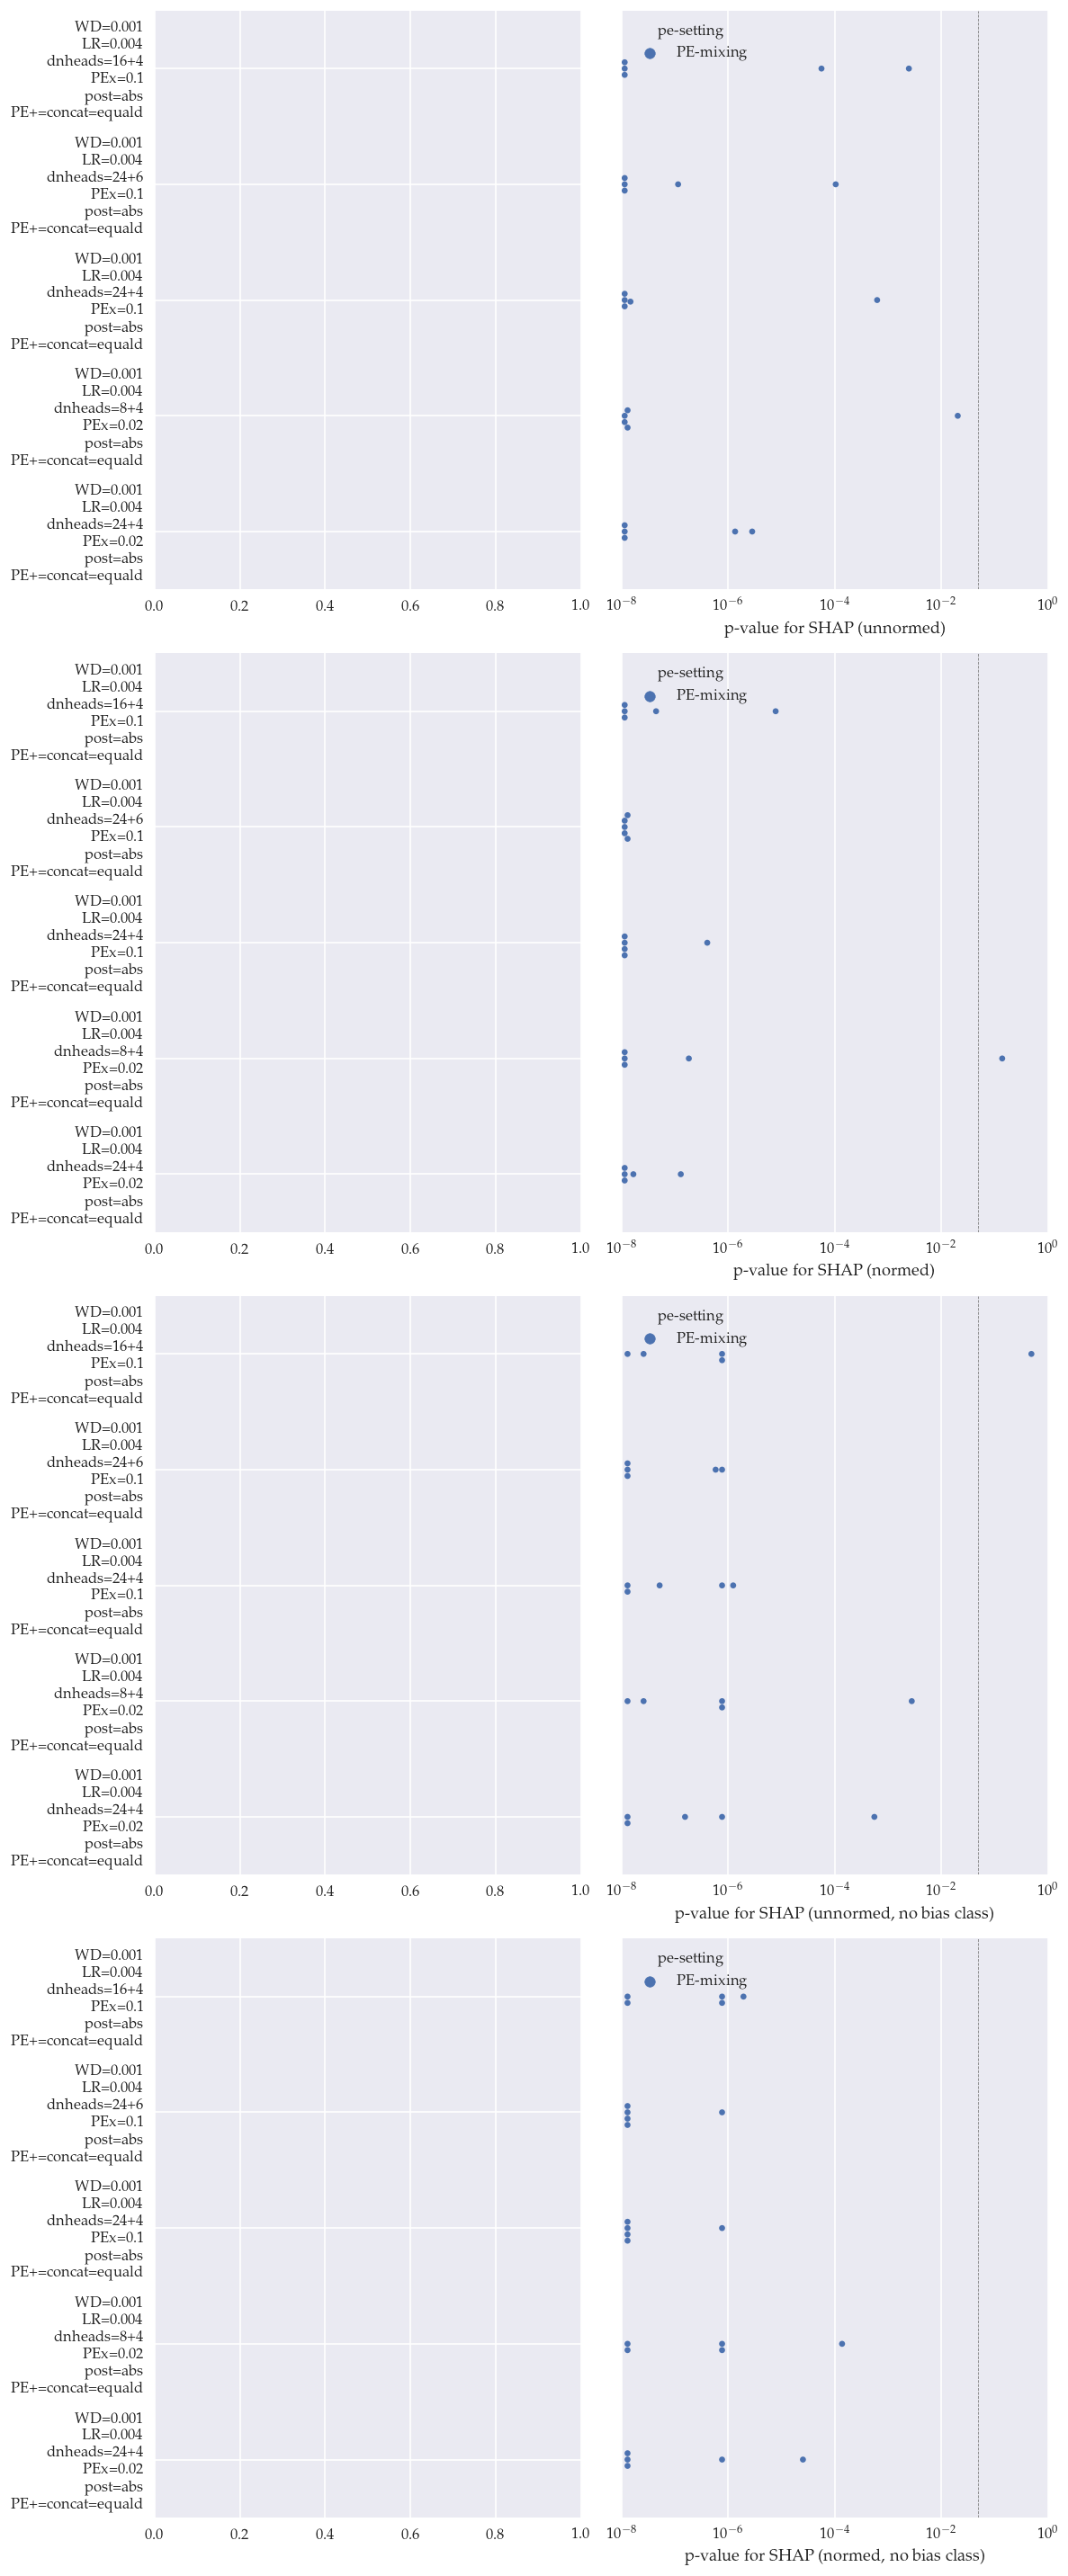

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, axs = plt.subplots(4, 2, figsize=(10, 24), dpi=120, sharey=True)

df = top_results.copy()
df['p-value for FG (unnormed)'] = df['sens_p_unnormed']
df['p-value for SHAP (unnormed)'] = df['shap_p_unnormed']
df['p-value for FG (normed)'] = df['sens_p_normed']
df['p-value for SHAP (normed)'] = df['shap_p_normed']
df['p-value for FG (unnormed, no bias class)'] = df['sens_p_unnormed_filtered']
df['p-value for SHAP (unnormed, no bias class)'] = df['shap_p_unnormed_filtered']
df['p-value for FG (normed, no bias class)'] = df['sens_p_normed_filtered']
df['p-value for SHAP (normed, no bias class)'] = df['shap_p_normed_filtered']
df[f'overall top-{k} settings'] = df['setting']
min_x = 1e-8
markersize = 4

# ax = sns.swarmplot(data=df, x="p-value for FG (unnormed)", y=f'overall top-{k} settings', hue="pe-setting", size=markersize, ax=axs[0,0])
# ax.set_xscale('log')
# ax.set_xlim(min_x, 1)
# ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
# ax.set_title("PE unnormed")

ax = sns.swarmplot(data=df, x="p-value for SHAP (unnormed)", y=f'overall top-{k} settings', hue="pe-setting", size=markersize, ax=axs[0,1])
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)

# ax = sns.swarmplot(data=df, x="p-value for FG (normed)", y=f'overall top-{k} settings', hue="pe-setting", size=markersize, ax=axs[1,0])
# ax.set_xscale('log')
# ax.set_xlim(min_x, 1)
# ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
# ax.set_title("PE normed by all")

ax = sns.swarmplot(data=df, x="p-value for SHAP (normed)", y=f'overall top-{k} settings', hue="pe-setting", size=markersize, ax=axs[1,1])
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)


# ax = sns.swarmplot(data=df, x="p-value for FG (unnormed, no bias class)", y=f'overall top-{k} settings', hue="pe-setting", size=markersize, ax=axs[2,0])
# ax.set_xscale('log')
# ax.set_xlim(min_x, 1)
# ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
# ax.set_title("PE unnormed - bias class removed")

ax = sns.swarmplot(data=df, x="p-value for SHAP (unnormed, no bias class)", y=f'overall top-{k} settings', hue="pe-setting", size=markersize, ax=axs[2,1])
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)

# ax = sns.swarmplot(data=df, x="p-value for FG (normed, no bias class)", y=f'overall top-{k} settings', hue="pe-setting", size=markersize, ax=axs[3,0])
# ax.set_xscale('log')
# ax.set_xlim(min_x, 1)
# ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
# ax.set_title("PE normed by all - bias class removed")

ax = sns.swarmplot(data=df, x="p-value for SHAP (normed, no bias class)", y=f'overall top-{k} settings', hue="pe-setting", size=markersize, ax=axs[3,1])
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.show()

### Ranked settings, only SHAP

#### Bias class excluded

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725) (0.0, 0.10980392156862745, 0.4980392156862745)


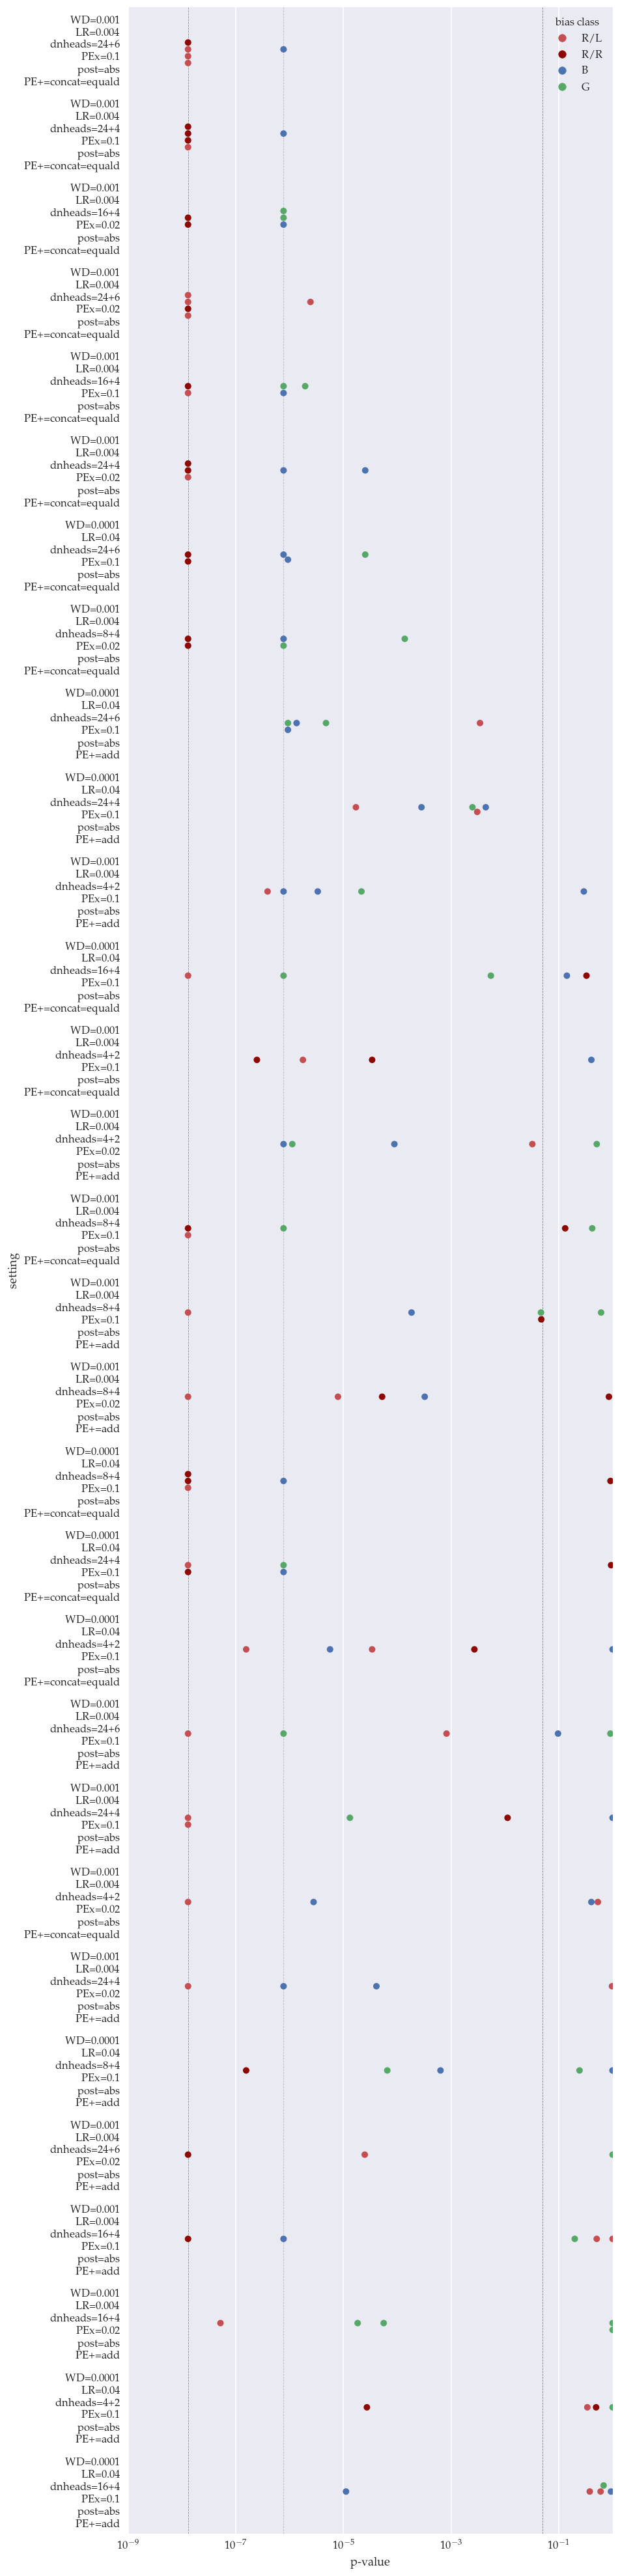

In [ ]:
# top_1_setting = top_settings.index[0]
# df2 = df[df['setting'] == top_1_setting]
df2 = test_results[test_results['pe-setting'] == 'PE-mixing']
df2 = df2.sort_values('setting_shap_p_normed_filtered', ascending=True)
df2

order = df2['setting'].unique()

# Adapt df2 where each row is a combination of normed/unnormed and bias class included/excluded, and there is a column p-value
df3 = []
for attr_method in ['SHAP']:
    for norming, norming_name in [('_normed', 'normalized')]:
        for filtering, filtering_name in [('_filtered', 'bias class excluded')]:
            p = df2[f'sens_p{norming}{filtering}'].values if attr_method == 'FG' else df2[f'shap_p{norming}{filtering}'].values
            seeds = df2['seed'].values
            pe_setting = df2['pe-setting'].values
            setting = df2['setting'].values
            bias_class = df2['shap_bias_class'].values
            attr_setting = f"{norming_name} / {filtering_name}"
            for i in range(len(p)):
                df3.append({
                    'p-value': p[i],
                    'attribution method': attr_method,
                    'seed': seeds[i],
                    'pe-setting': pe_setting[i],
                    'setting': setting[i],
                    'attribution settings': attr_setting,
                    'bias class': bias_class[i],
                })
df3 = pd.DataFrame(df3)

min_x = 1e-9
markersize = 6

fig, axs = plt.subplots(1, 1, figsize=(8, len(order) * (42./30.)), dpi=120)

palette = sns.color_palette("deep")
dark_palette = sns.color_palette("dark")
print(palette[0], dark_palette[0])
palette = {
    'R/L': palette[3],
    'R/R': dark_palette[3],
    'G': palette[2],
    'B': palette[0],
}
# hue_order = ['R/L', 'R/R', 'G', 'B']
# ax = sns.swarmplot(data=df3, x="p-value", y='setting', order=order, hue="bias class", hue_order=hue_order, palette=palette, size=markersize, ax=axs)
ax = sns.swarmplot(data=df3, x="p-value", y='setting', order=order, hue="bias class", palette=palette, size=markersize, ax=axs)
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
# alpha = 0.05 line
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
# lines for perfect delineation
ax.axvline(1.3003108978341176e-08, color=palette['R/R'], linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(7.724550868747958e-07, color=palette['G'], linestyle='--', linewidth=0.5, alpha=0.5)
# top_1_setting = top_1_setting.replace("\n",' - ')
# ax.set_title(f"Best setting: {top_1_setting}")

#### Bias class included

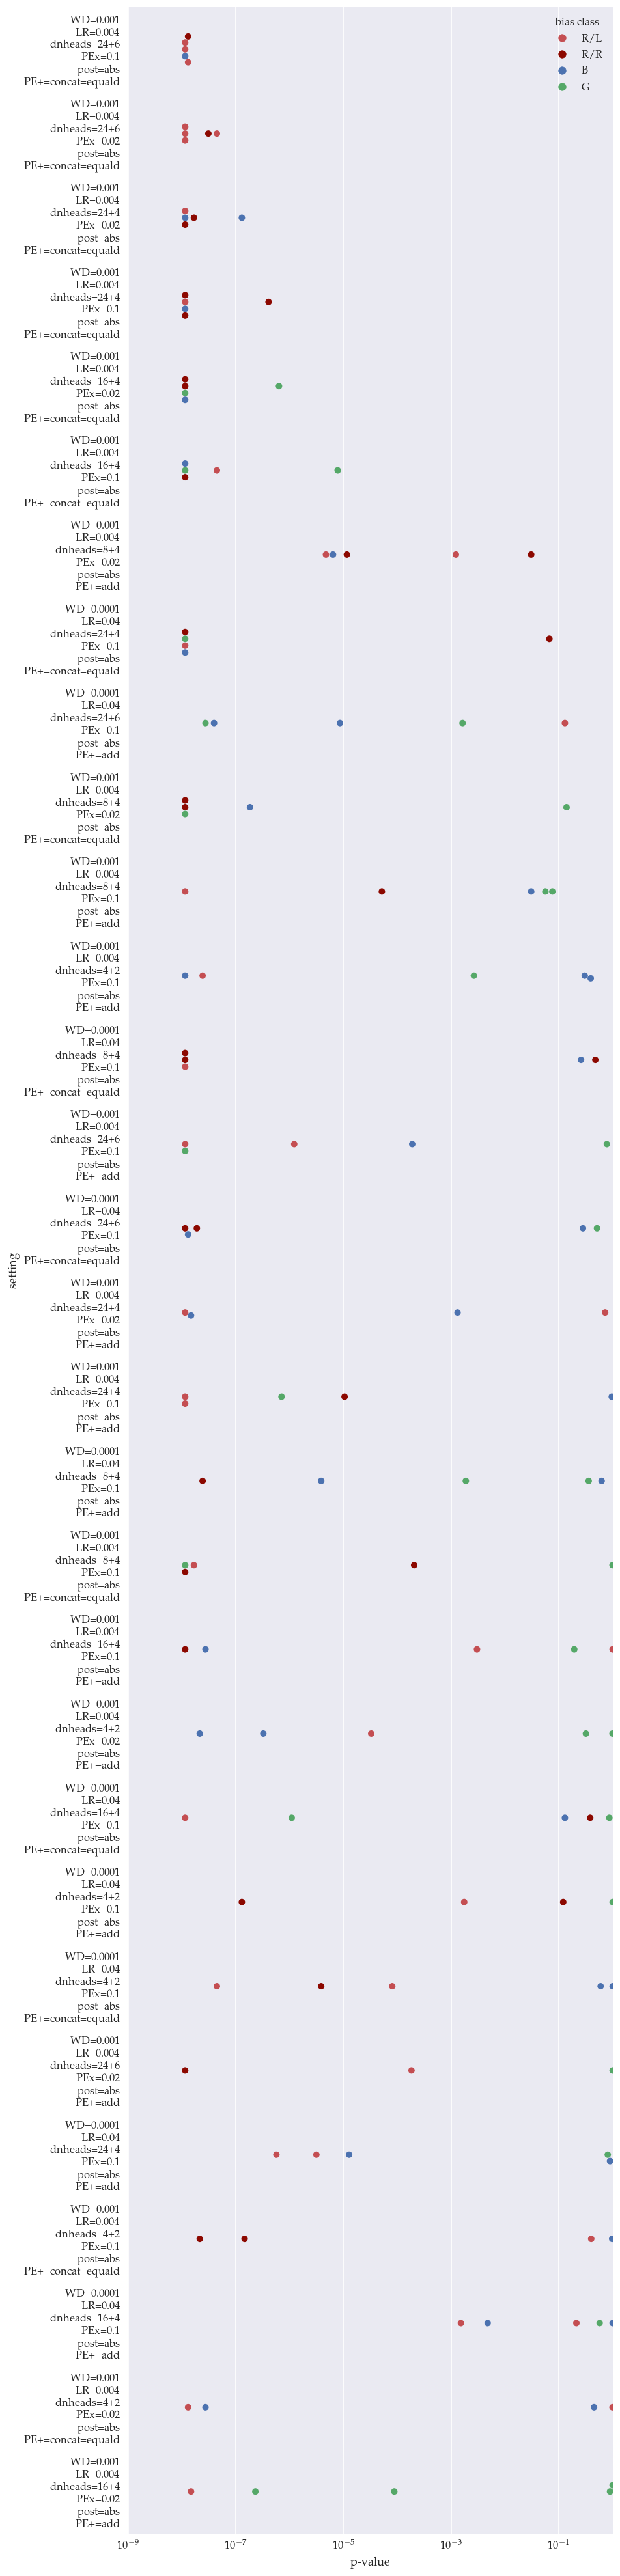

In [237]:
# top_1_setting = top_settings.index[0]
# df2 = df[df['setting'] == top_1_setting]
df2 = test_results[test_results['pe-setting'] == 'PE-mixing']
df2 = df2.sort_values('setting_shap_p_normed', ascending=True)
df2

order = df2['setting'].unique()

# Adapt df2 where each row is a combination of normed/unnormed and bias class included/excluded, and there is a column p-value
df3 = []
for attr_method in ['SHAP']:
    for norming, norming_name in [('_normed', 'normalized')]:
        for filtering, filtering_name in [('', 'bias class included')]:
            p = df2[f'sens_p{norming}{filtering}'].values if attr_method == 'FG' else df2[f'shap_p{norming}{filtering}'].values
            seeds = df2['seed'].values
            pe_setting = df2['pe-setting'].values
            setting = df2['setting'].values
            bias_class = df2['shap_bias_class'].values
            attr_setting = f"{norming_name} / {filtering_name}"
            for i in range(len(p)):
                df3.append({
                    'p-value': p[i],
                    'attribution method': attr_method,
                    'seed': seeds[i],
                    'pe-setting': pe_setting[i],
                    'setting': setting[i],
                    'attribution settings': attr_setting,
                    'bias class': bias_class[i],
                })
df3 = pd.DataFrame(df3)

min_x = 1e-9
markersize = 6

fig, axs = plt.subplots(1, 1, figsize=(8, len(order) * (42./30.)), dpi=120)

palette = sns.color_palette("deep")
dark_palette = sns.color_palette("dark")
palette = {
    'R/L': palette[3],
    'R/R': dark_palette[3],
    'G': palette[2],
    'B': palette[0],
}
# hue_order = ['R/L', 'R/R', 'G', 'B']
# ax = sns.swarmplot(data=df3, x="p-value", y='setting', order=order, hue="bias class", hue_order=hue_order, palette=palette, size=markersize, ax=axs)
ax = sns.swarmplot(data=df3, x="p-value", y='setting', order=order, hue="bias class", palette=palette, size=markersize, ax=axs)
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
# top_1_setting = top_1_setting.replace("\n",' - ')
# ax.set_title(f"Best setting: {top_1_setting}")

### Ranked settings, SHAP only, spatial vs. no-spatial

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725) (0.0, 0.10980392156862745, 0.4980392156862745)


/home/robert-jan/miniconda3/envs/vit-shap/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/robert-jan/miniconda3/envs/vit-shap/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/robert-jan/miniconda3/envs/vit-shap/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


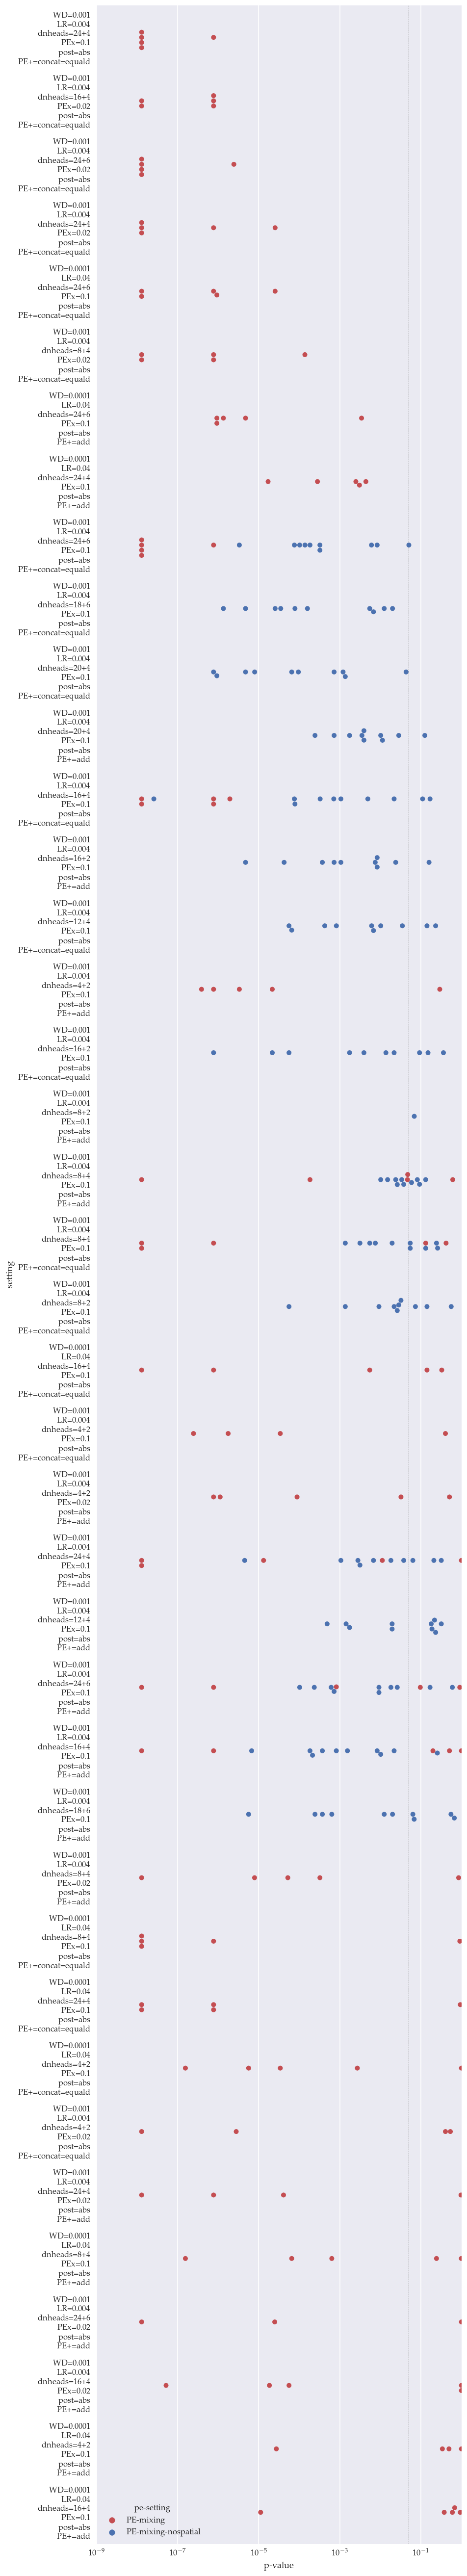

In [42]:
# top_1_setting = top_settings.index[0]
# df2 = df[df['setting'] == top_1_setting]
# Filter for PE-mixing or PE-mixing-nospatial
df2 = test_results[test_results['pe-setting'].isin(['PE-mixing', 'PE-mixing-nospatial'])]
df2 = df2.sort_values('setting_shap_p_normed_filtered', ascending=True)
df2

order = df2['setting'].unique()

# Adapt df2 where each row is a combination of normed/unnormed and bias class included/excluded, and there is a column p-value
df3 = []
for attr_method in ['SHAP']:
    for norming, norming_name in [('_normed', 'normalized')]:
        for filtering, filtering_name in [('_filtered', 'bias class excluded')]:
            p = df2[f'sens_p{norming}{filtering}'].values if attr_method == 'FG' else df2[f'shap_p{norming}{filtering}'].values
            seeds = df2['seed'].values
            pe_setting = df2['pe-setting'].values
            setting = df2['setting'].values
            bias_class = df2['shap_bias_class'].values
            attr_setting = f"{norming_name} / {filtering_name}"
            for i in range(len(p)):
                df3.append({
                    'p-value': p[i],
                    'attribution method': attr_method,
                    'seed': seeds[i],
                    'pe-setting': pe_setting[i],
                    'setting': setting[i],
                    'attribution settings': attr_setting,
                    'bias class': bias_class[i],
                })
df3 = pd.DataFrame(df3)

min_x = 1e-9
markersize = 6

fig, axs = plt.subplots(1, 1, figsize=(8, len(order) * (42./30.)), dpi=120)

palette = sns.color_palette("deep")
dark_palette = sns.color_palette("dark")
print(palette[0], dark_palette[0])
palette = {
    'PE-mixing': palette[3],
    'PE-mixing-nospatial': palette[0],
}
# hue_order = ['R/L', 'R/R', 'G', 'B']
# ax = sns.swarmplot(data=df3, x="p-value", y='setting', order=order, hue="pe-setting", hue_order=hue_order, palette=palette, size=markersize, ax=axs)
ax = sns.swarmplot(data=df3, x="p-value", y='setting', order=order, hue="pe-setting", palette=palette, size=markersize, ax=axs)
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
# alpha = 0.05 line
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
# lines for perfect delineation
# ax.axvline(1.3003108978341176e-08, color=palette['R/R'], linestyle='--', linewidth=0.5, alpha=0.5)
# ax.axvline(7.724550868747958e-07, color=palette['B'], linestyle='--', linewidth=0.5, alpha=0.5)
# top_1_setting = top_1_setting.replace("\n",' - ')
# ax.set_title(f"Best setting: {top_1_setting}")

### Hyperparameter effects

In [68]:
df4 = df3.groupby('setting').agg({
    'seed': 'count',
    'p-value': lambda x: (x < 0.05).sum() * 100. / 5.
})

df4 = df4.reset_index()

wds = {val: df4[df4['setting'].str.contains(f'WD={val}')]['p-value'].mean() for val in [1e-3, 1e-4]}
lrs = {val: df4[df4['setting'].str.contains(f'LR={val}')]['p-value'].mean() for val in [4e-3, 4e-2]}
dnheads = {(d, nheads): df4[df4['setting'].str.contains(f'dnheads={d}\+{nheads}')]['p-value'].mean() for (d, nheads) in [(24,6), (24,4), (16,4), (8,4), (4,2)]}
pos_emb_factors = {val: df4[df4['setting'].str.contains(f'PEx={val}')]['p-value'].mean() for val in [0.1, 0.02]}
pos_adds = {val: df4[df4['setting'].str.contains(f'PE\+={val}')]['p-value'].mean() for val in ['add', 'concat=equald']}

print("Percentage of seeds passing test, per hyperparameter, averaged over all other hyperparameters:")
print("WDs", wds)
print("lrs", lrs)
print("dnheads", dnheads)
print("pos_emb_factors", pos_emb_factors)
print("pos_adds", pos_adds)



pos_add_suffix = "PE\+=add"
pos_emb_factor_suffix = "PEx=0.1"

# print(df4['setting'].str.contains(f'WD=0.001') & df4['setting'].str.contains(pos_add_suffix) & df4['setting'].str.contains(pos_emb_factor_suffix))

wds = {val: df4[df4['setting'].str.contains(f'WD={val}') & df4['setting'].str.contains(pos_add_suffix) & df4['setting'].str.contains(pos_emb_factor_suffix)]['p-value'].mean() for val in [1e-3, 1e-4]}
lrs = {val: df4[df4['setting'].str.contains(f'LR={val}') & df4['setting'].str.contains(pos_add_suffix) & df4['setting'].str.contains(pos_emb_factor_suffix)]['p-value'].mean() for val in [4e-3, 4e-2]}
dnheads = {(d, nheads): df4[df4['setting'].str.contains(f'dnheads={d}\+{nheads}') & df4['setting'].str.contains(pos_add_suffix) & df4['setting'].str.contains(pos_emb_factor_suffix)]['p-value'].mean() for (d, nheads) in [(24,6), (24,4), (16,4), (8,4), (4,2)]}

print("\nResults for only settings that match the default ViT configuration (PE+ = add, PEx = 0.1):")
print("WDs", wds)
print("lrs", lrs)
print("dnheads", dnheads)

Percentage of seeds passing test, per hyperparameter, averaged over all other hyperparameters:
WDs {0.001: 76.0, 0.0001: 70.0}
lrs {0.004: 76.0, 0.04: 70.0}
dnheads {(24, 6): 83.33333333333333, (24, 4): 86.66666666666667, (16, 4): 63.333333333333336, (8, 4): 76.66666666666667, (4, 2): 60.0}
pos_emb_factors {0.1: 73.0, 0.02: 76.0}
pos_adds {'add': 64.0, 'concat=equald': 84.0}

Results for only settings that match the default ViT configuration (PE+ = add, PEx = 0.1):
WDs {0.001: 68.0, 0.0001: 60.0}
lrs {0.004: 68.0, 0.04: 60.0}
dnheads {(24, 6): 80.0, (24, 4): 90.0, (16, 4): 30.0, (8, 4): 70.0, (4, 2): 50.0}


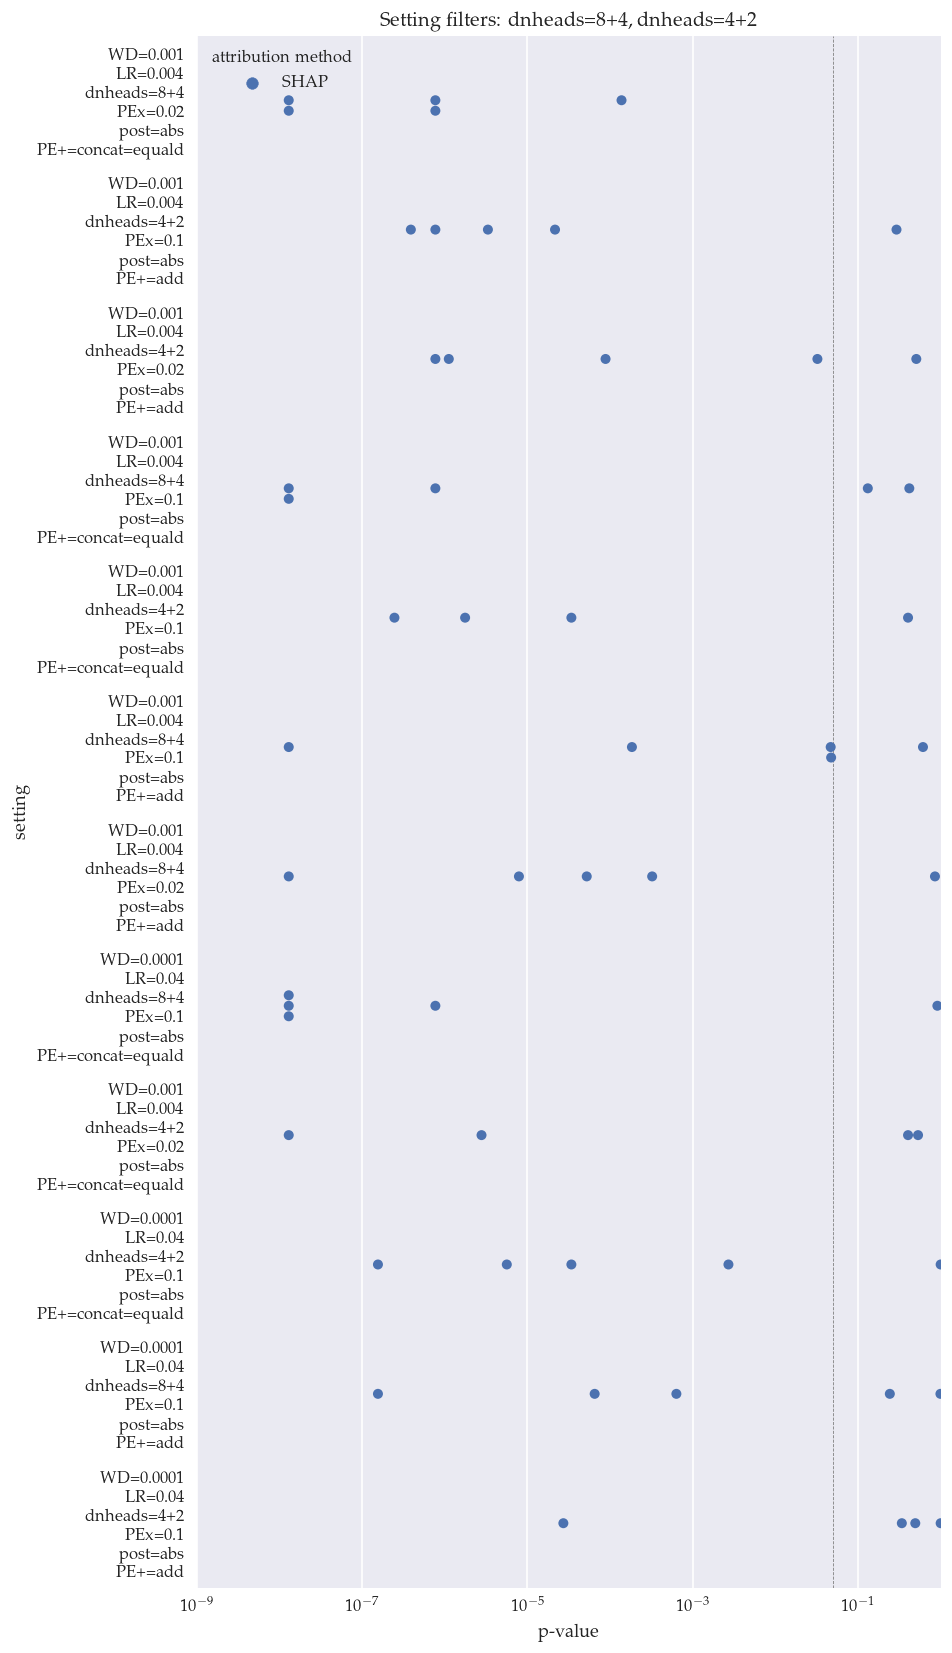

In [69]:
# top_1_setting = top_settings.index[0]
# df2 = df[df['setting'] == top_1_setting]
df2 = test_results[test_results['pe-setting'] == 'PE-mixing']
df2['setting']

setting_filters = ['dnheads=8\+4', 'dnheads=4\+2']
condition = df2['setting'].str.contains(setting_filters[0])
for f in setting_filters[1:]:
    condition = condition | df2['setting'].str.contains(f)
df2 = df2[condition]
df2 = df2.sort_values('setting_shap_p_normed_filtered', ascending=True)
df2

order = df2['setting'].unique()

# Adapt df2 where each row is a combination of normed/unnormed and bias class included/excluded, and there is a column p-value
df3 = []
for attr_method in ['SHAP']:
    for norming, norming_name in [('_normed', 'normalized')]:
        for filtering, filtering_name in [('_filtered', 'bias class excluded')]:
            p = df2[f'sens_p{norming}{filtering}'].values if attr_method == 'FG' else df2[f'shap_p{norming}{filtering}'].values
            seeds = df2['seed'].values
            pe_setting = df2['pe-setting'].values
            setting = df2['setting'].values
            attr_setting = f"{norming_name} / {filtering_name}"
            for i in range(len(p)):
                df3.append({
                    'p-value': p[i],
                    'attribution method': attr_method,
                    'seed': seeds[i],
                    'pe-setting': pe_setting[i],
                    'setting': setting[i],
                    'attribution settings': attr_setting,
                })
df3 = pd.DataFrame(df3)

min_x = 1e-9
markersize = 6

fig, axs = plt.subplots(1, 1, figsize=(8, len(order) * (42./30.)), dpi=120)

ax = sns.swarmplot(data=df3, x="p-value", y='setting', order=order, hue="attribution method", size=markersize, ax=axs)
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
title_setting_filters = [f.replace("\\",'') for f in setting_filters]
ax.set_title(f"Setting filters: {', '.join(title_setting_filters)}")
pass

### p-value vs. PE attribution, bias class excluded

#### PE attribution

(-1.0, 50.0)

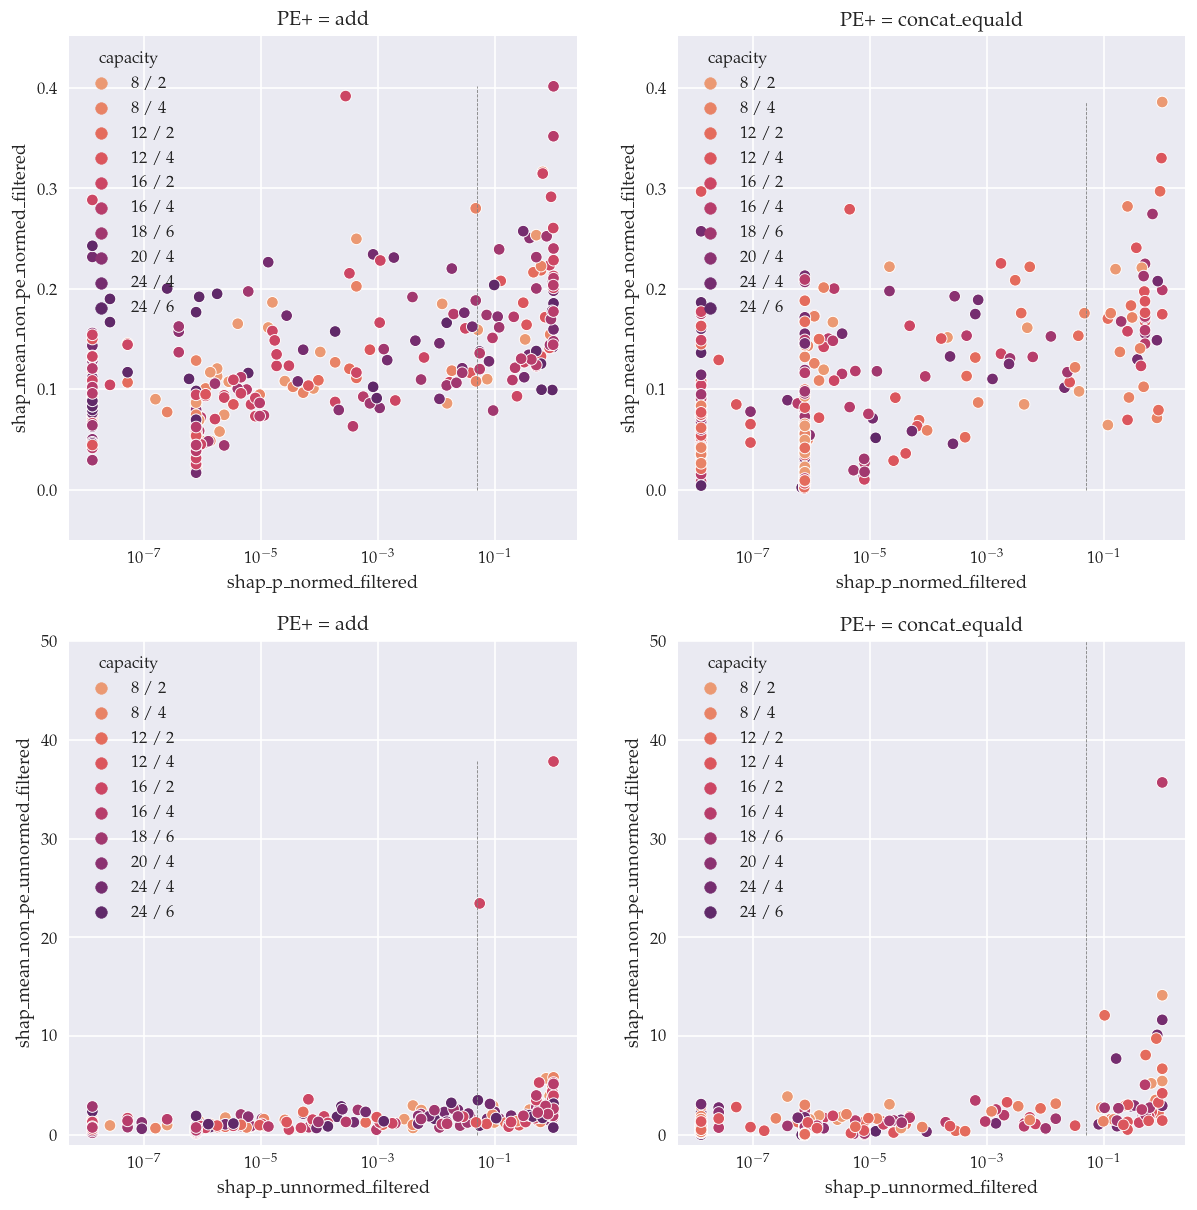

In [65]:
df = test_results.copy()
df = df[df['pe-setting'] == 'PE-mixing']
df['capacity'] = df['d'].astype(str) + ' / ' + df['n_heads'].astype(str)
hue_order = ['8 / 2', '8 / 4', '12 / 2', '12 / 4', '16 / 2', '16 / 4', '18 / 6', '20 / 4', '24 / 4', '24 / 6']

# Scatterplot
# x = shap_p_normed_filtered
# y = shap_mean_pe_normed_filtered
# hue = capacity
fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=120)
palette = sns.color_palette("flare", len(hue_order))

sns.scatterplot(data=df[df['pos_add'] == 'add'], x='shap_p_normed_filtered', y='shap_mean_non_pe_normed_filtered', hue='capacity', hue_order=hue_order, palette=palette, ax=axs[0,0])
axs[0,0].plot([0.05, 0.05], [0, df[df['pos_add'] == 'add']['shap_mean_non_pe_normed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[0,0].set_xscale('log')
axs[0,0].set_title("PE+ = add")

sns.scatterplot(data=df[df['pos_add'] == 'concat_equald'], x='shap_p_normed_filtered', y='shap_mean_non_pe_normed_filtered', hue='capacity', hue_order=hue_order, palette=palette, ax=axs[0,1])
axs[0,1].plot([0.05, 0.05], [0, df[df['pos_add'] == 'concat_equald']['shap_mean_non_pe_normed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[0,1].set_xscale('log')
axs[0,1].set_title("PE+ = concat_equald")

sns.scatterplot(data=df[df['pos_add'] == 'add'], x='shap_p_unnormed_filtered', y='shap_mean_non_pe_unnormed_filtered', hue='capacity', hue_order=hue_order, palette=palette, ax=axs[1,0])
axs[1,0].plot([0.05, 0.05], [0, df[df['pos_add'] == 'add']['shap_mean_non_pe_unnormed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[1,0].set_xscale('log')
axs[1,0].set_title("PE+ = add")

sns.scatterplot(data=df[df['pos_add'] == 'concat_equald'], x='shap_p_unnormed_filtered', y='shap_mean_non_pe_unnormed_filtered', hue='capacity', hue_order=hue_order, palette=palette, ax=axs[1,1])
axs[1,1].plot([0.05, 0.05], [0, df[df['pos_add'] == 'concat_equald']['shap_mean_non_pe_unnormed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[1,1].set_xscale('log')
axs[1,1].set_title("PE+ = concat_equald")

axs[0,0].set_ylim(-0.05, df['shap_mean_non_pe_normed_filtered'].max() + 0.05)
axs[0,1].set_ylim(-0.05, df['shap_mean_non_pe_normed_filtered'].max() + 0.05)
# axs[1,0].set_ylim(-1, df['shap_mean_non_pe_unnormed_filtered'].max())
# axs[1,1].set_ylim(-1, df['shap_mean_non_pe_unnormed_filtered'].max())
axs[1,0].set_ylim(-1, 50)
axs[1,1].set_ylim(-1, 50)

#### Non-PE attribution

(-1.0, 50.0)

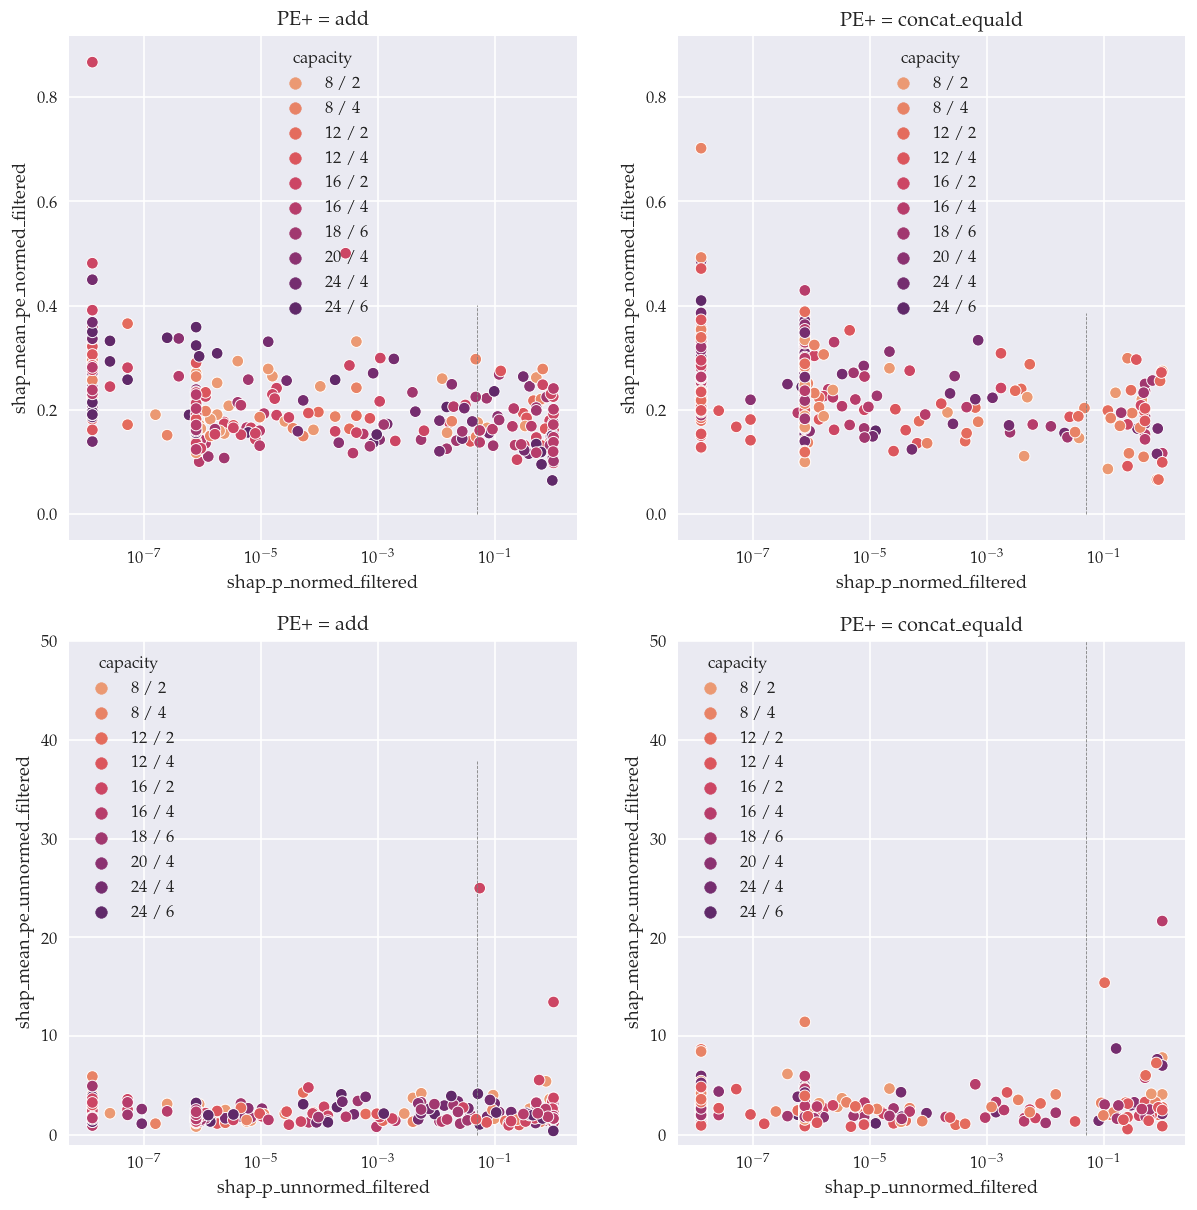

In [66]:
df = test_results.copy()
df = df[df['pe-setting'] == 'PE-mixing']
df['capacity'] = df['d'].astype(str) + ' / ' + df['n_heads'].astype(str)
hue_order = ['8 / 2', '8 / 4', '12 / 2', '12 / 4', '16 / 2', '16 / 4', '18 / 6', '20 / 4', '24 / 4', '24 / 6']

# Scatterplot
# x = shap_p_normed_filtered
# y = shap_mean_pe_normed_filtered
# hue = capacity
fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=120)
palette = sns.color_palette("flare", len(hue_order))

sns.scatterplot(data=df[df['pos_add'] == 'add'], x='shap_p_normed_filtered', y='shap_mean_pe_normed_filtered', hue='capacity', hue_order=hue_order, palette=palette, ax=axs[0,0])
axs[0,0].plot([0.05, 0.05], [0, df[df['pos_add'] == 'add']['shap_mean_non_pe_normed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[0,0].set_xscale('log')
axs[0,0].set_title("PE+ = add")

sns.scatterplot(data=df[df['pos_add'] == 'concat_equald'], x='shap_p_normed_filtered', y='shap_mean_pe_normed_filtered', hue='capacity', hue_order=hue_order, palette=palette, ax=axs[0,1])
axs[0,1].plot([0.05, 0.05], [0, df[df['pos_add'] == 'concat_equald']['shap_mean_non_pe_normed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[0,1].set_xscale('log')
axs[0,1].set_title("PE+ = concat_equald")

sns.scatterplot(data=df[df['pos_add'] == 'add'], x='shap_p_unnormed_filtered', y='shap_mean_pe_unnormed_filtered', hue='capacity', hue_order=hue_order, palette=palette, ax=axs[1,0])
axs[1,0].plot([0.05, 0.05], [0, df[df['pos_add'] == 'add']['shap_mean_non_pe_unnormed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[1,0].set_xscale('log')
axs[1,0].set_title("PE+ = add")

sns.scatterplot(data=df[df['pos_add'] == 'concat_equald'], x='shap_p_unnormed_filtered', y='shap_mean_pe_unnormed_filtered', hue='capacity', hue_order=hue_order, palette=palette, ax=axs[1,1])
axs[1,1].plot([0.05, 0.05], [0, df[df['pos_add'] == 'concat_equald']['shap_mean_non_pe_unnormed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[1,1].set_xscale('log')
axs[1,1].set_title("PE+ = concat_equald")

axs[0,0].set_ylim(-0.05, df['shap_mean_pe_normed_filtered'].max() + 0.05)
axs[0,1].set_ylim(-0.05, df['shap_mean_pe_normed_filtered'].max() + 0.05)
# axs[1,0].set_ylim(-1, df['shap_mean_non_pe_unnormed_filtered'].max())
# axs[1,1].set_ylim(-1, df['shap_mean_non_pe_unnormed_filtered'].max())
axs[1,0].set_ylim(-1, 50)
axs[1,1].set_ylim(-1, 50)

### p-value vs. bias class

(-1.0, 50.0)

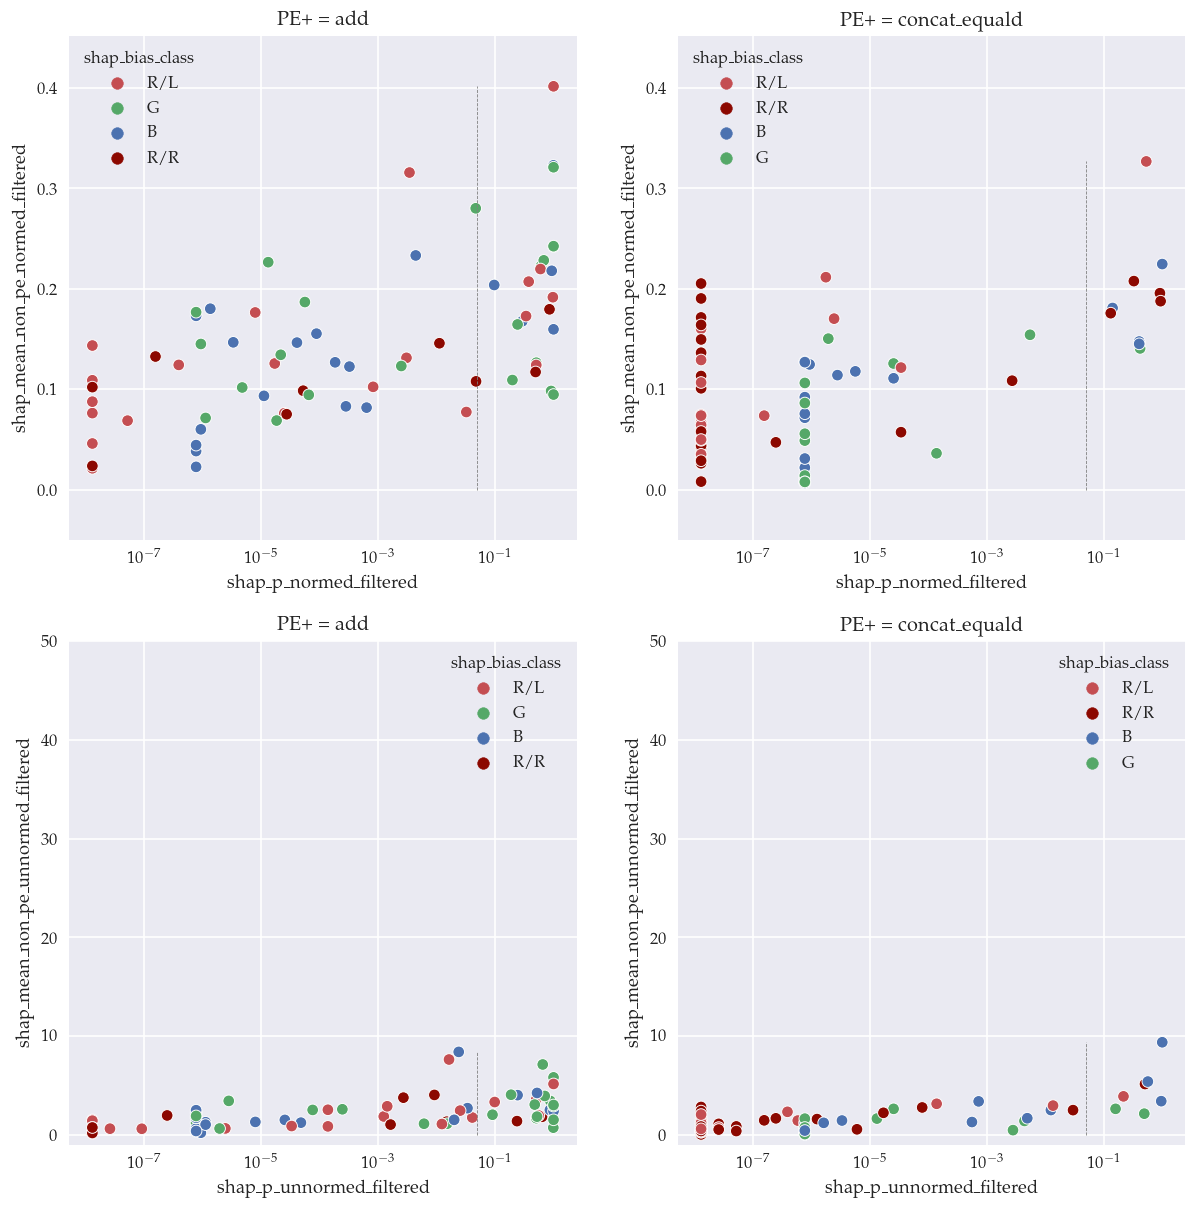

In [241]:
df = test_results.copy()
df = df[df['pe-setting'] == 'PE-mixing']
palette = sns.color_palette("deep")
dark_palette = sns.color_palette("dark")
palette = {
    'R/L': palette[3],
    'R/R': dark_palette[3],
    'G': palette[2],
    'B': palette[0],
}

# Scatterplot
# x = shap_p_normed_filtered
# y = shap_mean_pe_normed_filtered
# hue = bias_class
fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=120)

sns.scatterplot(data=df[df['pos_add'] == 'add'], x='shap_p_normed_filtered', y='shap_mean_non_pe_normed_filtered', hue='shap_bias_class', palette=palette, ax=axs[0,0])
axs[0,0].plot([0.05, 0.05], [0, df[df['pos_add'] == 'add']['shap_mean_non_pe_normed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[0,0].set_xscale('log')
axs[0,0].set_title("PE+ = add")

sns.scatterplot(data=df[df['pos_add'] == 'concat_equald'], x='shap_p_normed_filtered', y='shap_mean_non_pe_normed_filtered', hue='shap_bias_class', palette=palette, ax=axs[0,1])
axs[0,1].plot([0.05, 0.05], [0, df[df['pos_add'] == 'concat_equald']['shap_mean_non_pe_normed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[0,1].set_xscale('log')
axs[0,1].set_title("PE+ = concat_equald")

sns.scatterplot(data=df[df['pos_add'] == 'add'], x='shap_p_unnormed_filtered', y='shap_mean_non_pe_unnormed_filtered', hue='shap_bias_class', palette=palette, ax=axs[1,0])
axs[1,0].plot([0.05, 0.05], [0, df[df['pos_add'] == 'add']['shap_mean_non_pe_unnormed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[1,0].set_xscale('log')
axs[1,0].set_title("PE+ = add")

sns.scatterplot(data=df[df['pos_add'] == 'concat_equald'], x='shap_p_unnormed_filtered', y='shap_mean_non_pe_unnormed_filtered', hue='shap_bias_class', palette=palette, ax=axs[1,1])
axs[1,1].plot([0.05, 0.05], [0, df[df['pos_add'] == 'concat_equald']['shap_mean_non_pe_unnormed_filtered'].max()], color='gray', linestyle='--', linewidth=0.5)
axs[1,1].set_xscale('log')
axs[1,1].set_title("PE+ = concat_equald")

axs[0,0].set_ylim(-0.05, df['shap_mean_non_pe_normed_filtered'].max() + 0.05)
axs[0,1].set_ylim(-0.05, df['shap_mean_non_pe_normed_filtered'].max() + 0.05)
# axs[1,0].set_ylim(-1, df['shap_mean_non_pe_unnormed_filtered'].max())
# axs[1,1].set_ylim(-1, df['shap_mean_non_pe_unnormed_filtered'].max())
axs[1,0].set_ylim(-1, 50)
axs[1,1].set_ylim(-1, 50)

### Seeds with identical p-values

There are a lot of seeds that have one of a few identical p-values. It seems that in these cases the classes are so well separated that all points are consistently ranked. Since the used test relies on rankings, this gives the same p-value.

In [80]:
vals = df['shap_p_normed_filtered'].values
counts = {v: (vals == v).sum() for v in vals}
sorted_counts = sorted(counts.items(), key=lambda c: c[1])[::-1]

for p, count in sorted_counts[:3]:
    print(f"p-value {p}: {count} seeds")

    # Print setting names for seeds with p-value of 0.05
    count_df = df[df['shap_p_normed_filtered'] == p]
    # print(count_df['setting'].unique())
    print(count_df[['shap_mean_non_pe_normed_filtered', 'shap_mean_pe_normed_filtered']])

p-value 1.3003108978341176e-08: 123 seeds
     shap_mean_non_pe_normed_filtered  shap_mean_pe_normed_filtered
264                          0.061247                      0.198220
263                          0.008215                      0.320563
267                          0.015652                      0.197210
268                          0.082478                      0.297194
274                          0.043936                      0.261323
..                                ...                           ...
360                          0.083347                      0.190863
367                          0.088643                      0.214284
174                          0.102259                      0.230659
177                          0.096054                      0.238097
327                          0.120873                      0.281522

[123 rows x 2 columns]
p-value 7.724550868747958e-07: 116 seeds
     shap_mean_non_pe_normed_filtered  shap_mean_pe_normed_filtered
269      

### Patch & PE mixing

What are we trying to show?

- The change in the decision boundary for patch tokens depends on the PE token

Sample 1 idx & label: 5, 3
Sample bg idxs & labels: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1 2 1 3 2 1 0 2 3 1 3 2 2 2 0]
Plot 0, class: 0: 1
Plot 0, bias class: R/L
Plot 0, class: 1: 0
Plot 0, class: 2: 1
Plot 0, class: 3: 1
Sample 1 idx & label: 5, 3
Sample bg idxs & labels: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1 2 1 3 2 1 0 2 3 1 3 2 2 2 0]
Plot 1, class: 0: 1
Plot 1, class: 1: 0
Plot 1, class: 2: 1
Plot 1, bias class: G
Plot 1, class: 3: 1


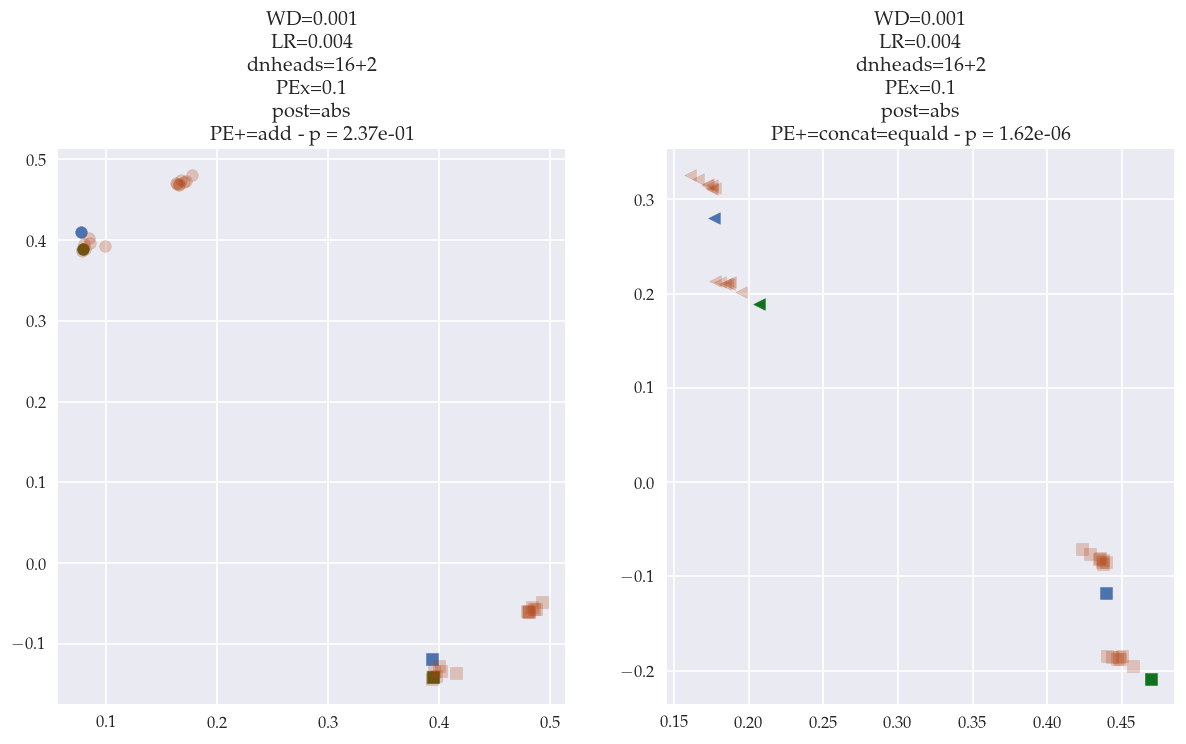

In [57]:
# FAKE DATA
# # n = 100
# # d = 8

# # pos_add = add
# patch_tokens = np.random.rand(n, d)
# pes = np.random.rand(n, d)
# tokens = patch_tokens + pes

# # # pos_add = concat_equald
# # patch_tokens = np.zeros((n, 2*d))
# # patch_tokens[:,:d] = np.random.rand(n, d)
# # pes = np.zeros((n, 2*d))
# # pes[:,d:] = np.random.rand(n, d)
# # tokens = patch_tokens + pes



# REAL DATA
settings = [
    # 'WD=0.001\nLR=0.004\ndnheads=8+2\nPEx=0.1\npost=abs\nPE+=add',
    # 'WD=0.001\nLR=0.004\ndnheads=8+2\nPEx=0.1\npost=abs\nPE+=concat=equald',
    'WD=0.001\nLR=0.004\ndnheads=16+2\nPEx=0.1\npost=abs\nPE+=add',
    'WD=0.001\nLR=0.004\ndnheads=16+2\nPEx=0.1\npost=abs\nPE+=concat=equald',
]
seed = 0
pca_d = 2



fig, axs = plt.subplots(1, len(settings), figsize=(len(settings) * 6, 6), dpi=120)
if len(settings) == 1:
    axs = [axs]

for i, setting in enumerate(settings):
    df = test_results[test_results['setting'] == setting].copy()
    df = df[df['seed'] == seed]
    assert len(df) == 1, f"{len(df)} seeds found"

    patch_tokens = df['im_tokens'].values[0]
    pes = df['pe_tokens'].values[0]
    tok_labels = df['tok_labels'].values[0]
    N, D, H, W = patch_tokens.shape

    patch_tokens = patch_tokens.transpose(0, 2, 3, 1).reshape(N, H*W, D)
    pes = pes.transpose(0, 2, 3, 1).reshape(1, H*W, D)

    sample_fg = 5
    sample_bg = list(set(range(H*W)) - {sample_fg})
    print(f"Sample 1 idx & label: {sample_fg}, {tok_labels[sample_fg]}")
    print(f"Sample bg idxs & labels: {sample_bg}, {tok_labels[sample_bg]}")

    # Keep only tokens for the sample where the pixel is "on"
    def get_unique_tokens(a):
        data = []
        keys = []
        counts = []
        for i in range(a.shape[0]):
            for j in range(len(data)):
                if np.isclose(a[i], data[j], atol=1e-1).all():
                    counts[j] += 1
                    break
            else:
                data.append(a[i])
                counts.append(1)
                keys.append(i)
        return np.array(data), np.array(counts), np.array(keys)
    patterns, counts, keys = get_unique_tokens(patch_tokens[:,sample_fg])
    nonzero_patch_tokens_idx = keys[counts == 1]

    patch_tokens_fg = patch_tokens[:,sample_fg]
    pes_fg = pes[:,sample_fg]
    tokens_fg = patch_tokens_fg + pes_fg
    pes_bg = []
    tokens_bg = []
    for bg in sample_bg:
        pes_bg.append(pes[:,bg])
        tokens_bg.append(patch_tokens_fg + pes_bg[-1])
    # bg samples = (len(sample_bg), N, D)
    pes_bg = np.array(pes_bg)
    tokens_bg = np.array(tokens_bg)

    bias_class = df['shap_bias_class'].values[0]
    class_idxes = ['R/L', 'R/R', 'G', 'B']
    bias_idx = class_idxes.index(bias_class)

    # Fit PCA to patch_tokens
    from sklearn.decomposition import PCA
    pca = PCA(n_components=pca_d)
    pca.fit(patch_tokens_fg)
    patch_tokens_1_pca = pca.transform(patch_tokens_fg)
    pes_fg_pca = pca.transform(pes_fg)
    tokens_fg_pca = pca.transform(tokens_fg)
    # After PCA, bg samples = (len(sample_bg) * N, pca_d)
    pes_bg_pca = pca.transform(pes_bg.reshape(-1, D))
    tokens_bg_pca = pca.transform(tokens_bg.reshape(-1, D))

    # Plot
    light_palette = sns.color_palette()
    dark_palette = sns.color_palette('dark')
    pastel_palette = sns.color_palette('pastel')
    class_markers = ['<', '>', 'o', 's']
    for cls in range(4):
        idx = tok_labels == cls
        idx = idx & np.isin(np.arange(len(patch_tokens_fg)), nonzero_patch_tokens_idx)
        bg_idx = np.tile(idx, len(sample_bg))
        print(f"Plot {i}, class: {cls}: {idx.sum()}")
        if cls == bias_idx:
            print(f"Plot {i}, bias class: {bias_class}")
            continue
        axs[i].scatter(patch_tokens_1_pca[idx,0], patch_tokens_1_pca[idx,1], label='Patch tokens', color=light_palette[0], marker=class_markers[cls])
        axs[i].scatter(tokens_fg_pca[idx,0], tokens_fg_pca[idx,1], label='Patch+PE matched', color=dark_palette[2], marker=class_markers[cls])
        axs[i].scatter(tokens_bg_pca[bg_idx,0], tokens_bg_pca[bg_idx,1], label='Patch+PE unmatched', color=dark_palette[1], marker=class_markers[cls], alpha=0.25)
    # # From samples where the pixel is "off", plot only one
    # for cls in range(4):
    #     idx = tok_labels == cls
    #     idx = idx & np.logical_not(np.isin(np.arange(len(patch_tokens_fg)), nonzero_patch_tokens_idx))
    #     bg_idx = np.tile(idx, len(sample_bg))
    #     # Turn all but first True to False
    #     idx[idx.tolist().index(True)+1:] = False
    #     axs[i].scatter(patch_tokens_1_pca[idx,0], patch_tokens_1_pca[idx,1], label='Patch tokens (off)', color=pastel_palette[0], marker=class_markers[cls])
    #     axs[i].scatter(tokens_fg_pca[idx,0], tokens_fg_pca[idx,1], label='Patch+PE matched (off)', color=pastel_palette[2], marker=class_markers[cls])
    #     axs[i].scatter(tokens_bg_pca[bg_idx,0], tokens_bg_pca[bg_idx,1], label='Patch+PE unmatched (off)', color=pastel_palette[1], marker=class_markers[cls], alpha=0.1)

    # axs[i].scatter(pes_1_pca[:,0], pes_1_pca[:,1], label='PE matched', color=light_palette[2], marker='*', s=250)
    # axs[i].scatter(pes_2_pca[:,0], pes_2_pca[:,1], label='PE unmatched', color=light_palette[1], marker='*', s=250)
    # Add marker for means
    # axs[i].scatter(np.mean(patch_tokens_pca[:,0]), np.mean(patch_tokens_pca[:,1]), label='Patch tokens mean', marker='*', s=150)
    # axs[i].scatter(np.mean(tokens_pca[:,0]), np.mean(tokens_pca[:,1]), label='Tokens mean', color='green', marker='*', s=150)
    # setting = setting.replace('\n','-').replace('=','_')
    axs[i].set_title(f"{setting} - p = {df['shap_p_normed_filtered'].values[0]:.2e}")
    # axs[i].legend()

## Best setting

### PE-mixing vs. PE-separated

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


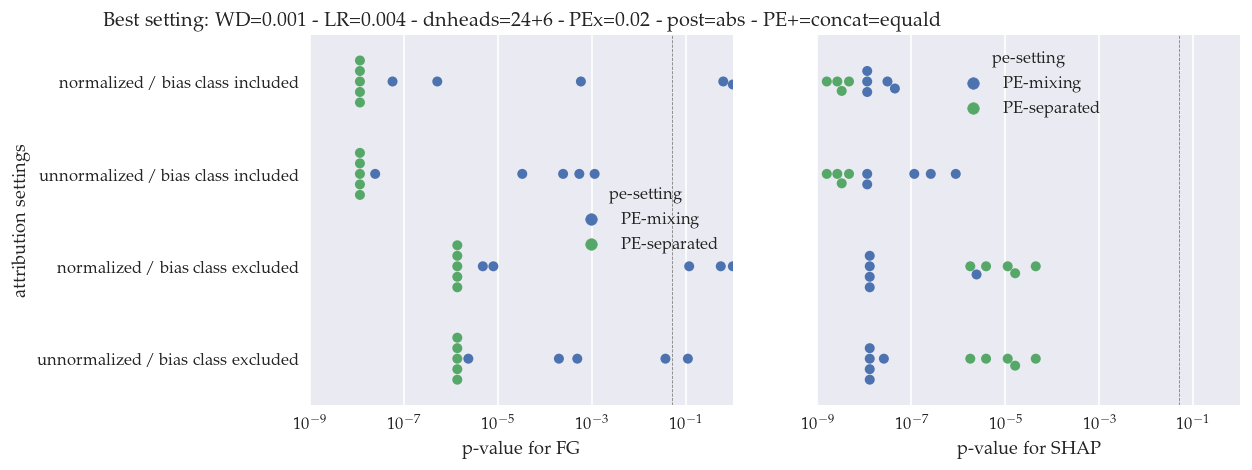

In [70]:
top_1_setting = top_settings.index[0]
df2 = df[df['setting'] == top_1_setting]

# Adapt df2 where each row is a combination of normed/unnormed and bias class included/excluded, and there is a column p-value
df3 = []
for norming, norming_name in [('_normed', 'normalized'), ('_unnormed', 'unnormalized')]:
    for filtering, filtering_name in [('_filtered', 'bias class excluded'), ('', 'bias class included')]:
        p_fg = df2[f'sens_p{norming}{filtering}'].values
        p_shap = df2[f'shap_p{norming}{filtering}'].values
        seeds = df2['seed'].values
        pe_setting = df2['pe-setting'].values
        attr_setting = f"{norming_name} / {filtering_name}"
        for i in range(len(p_fg)):
            df3.append({
                'p-value for FG': p_fg[i],
                'p-value for SHAP': p_shap[i],
                'seed': seeds[i],
                'pe-setting': pe_setting[i],
                'attribution settings': attr_setting,
            })
df3 = pd.DataFrame(df3)

min_x = 1e-9
order = [
    'normalized / bias class included',
    'unnormalized / bias class included',
    'normalized / bias class excluded',
    'unnormalized / bias class excluded',
]

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

ax = sns.swarmplot(data=df3, x="p-value for FG", y='attribution settings', order=order, hue="pe-setting", size=markersize, ax=axs[0])
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
top_1_setting = top_1_setting.replace("\n",' - ')
ax.set_title(f"Best setting: {top_1_setting}")

ax = sns.swarmplot(data=df3, x="p-value for SHAP", y='attribution settings', order=order, hue="pe-setting", size=markersize, ax=axs[1])
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)

### Only PE-mixing

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Best setting: WD=0.001 - LR=0.004 - dnheads=24+6 - PEx=0.02 - post=abs - PE+=concat=equald')

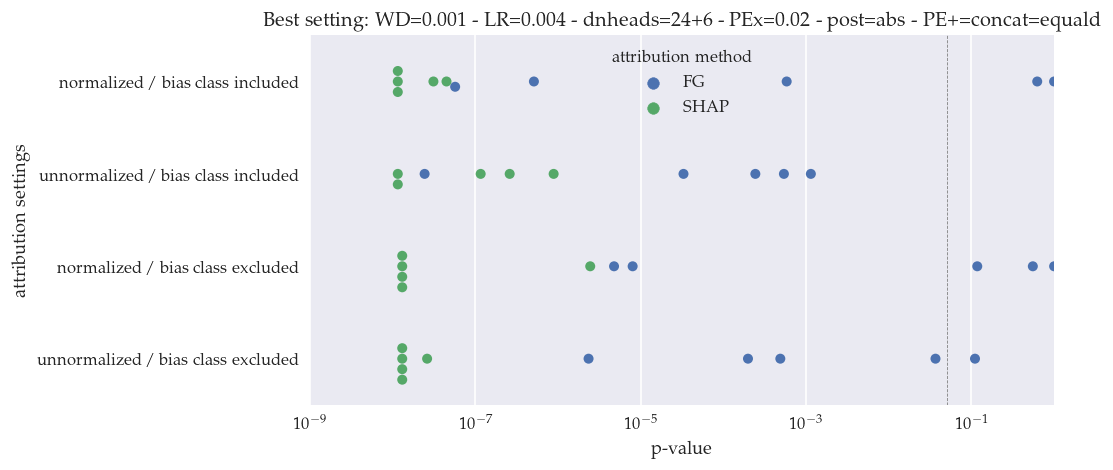

In [71]:
top_1_setting = top_settings.index[0]
df2 = df[df['setting'] == top_1_setting]
df2 = df2[df2['pe-setting'] == 'PE-mixing']

# Adapt df2 where each row is a combination of normed/unnormed and bias class included/excluded, and there is a column p-value
df3 = []
for attr_method in ['FG', 'SHAP']:
    for norming, norming_name in [('_normed', 'normalized'), ('_unnormed', 'unnormalized')]:
        for filtering, filtering_name in [('_filtered', 'bias class excluded'), ('', 'bias class included')]:
            p = df2[f'sens_p{norming}{filtering}'].values if attr_method == 'FG' else df2[f'shap_p{norming}{filtering}'].values
            seeds = df2['seed'].values
            pe_setting = df2['pe-setting'].values
            attr_setting = f"{norming_name} / {filtering_name}"
            for i in range(len(p)):
                df3.append({
                    'p-value': p[i],
                    'attribution method': attr_method,
                    'seed': seeds[i],
                    'pe-setting': pe_setting[i],
                    'attribution settings': attr_setting,
                })
df3 = pd.DataFrame(df3)

min_x = 1e-9
markersize = 6
order = [
    'normalized / bias class included',
    'unnormalized / bias class included',
    'normalized / bias class excluded',
    'unnormalized / bias class excluded',
]

fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=120)

ax = sns.swarmplot(data=df3, x="p-value", y='attribution settings', order=order, hue="attribution method", size=markersize, ax=axs)
ax.set_xscale('log')
ax.set_xlim(min_x, 1)
ax.axvline(alpha, color='gray', linestyle='--', linewidth=0.5)
top_1_setting = top_1_setting.replace("\n",' - ')
ax.set_title(f"Best setting: {top_1_setting}")

# SHAP values analysis (deprecated)

### Save / load SHAP values

In [5]:
data = {}

In [6]:
data['mixed-with-test'] = (image_shap_values, pe_shap_values)

In [13]:
image_shap_values, pe_shap_values = data['mixed-with-test']

print(image_shap_values.shape, pe_shap_values.shape)
print(image_shap_values.abs().max(), pe_shap_values.abs().max())
assert image_shap_values.abs().max() > 0.0, f"Image SHAP values should not be zero, got max(abs(SHAP_IM)) = {image_shap_values.abs().max()}"
assert pe_shap_values.abs().max() > 0.0, f"PE SHAP values should not be zero, got max(abs(SHAP_PE)) = {pe_shap_values.abs().max()}"

torch.Size([3, 48, 3, 8, 8, 4]) torch.Size([3, 48, 4, 4, 4, 4])


### Plot samples

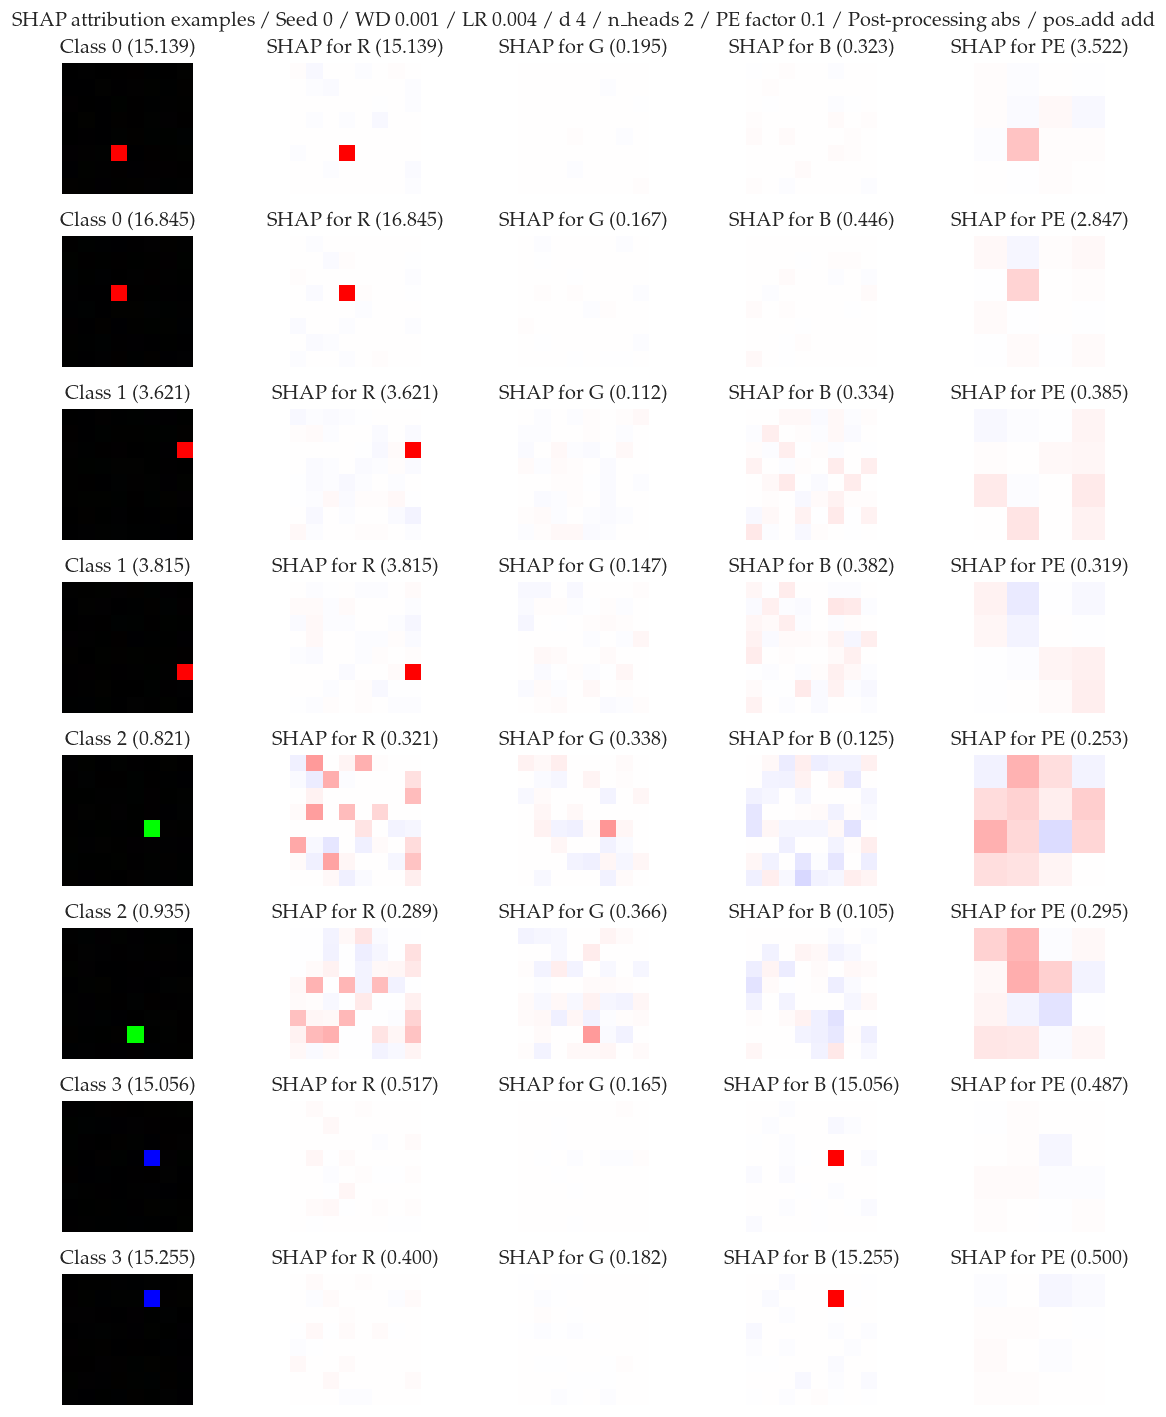

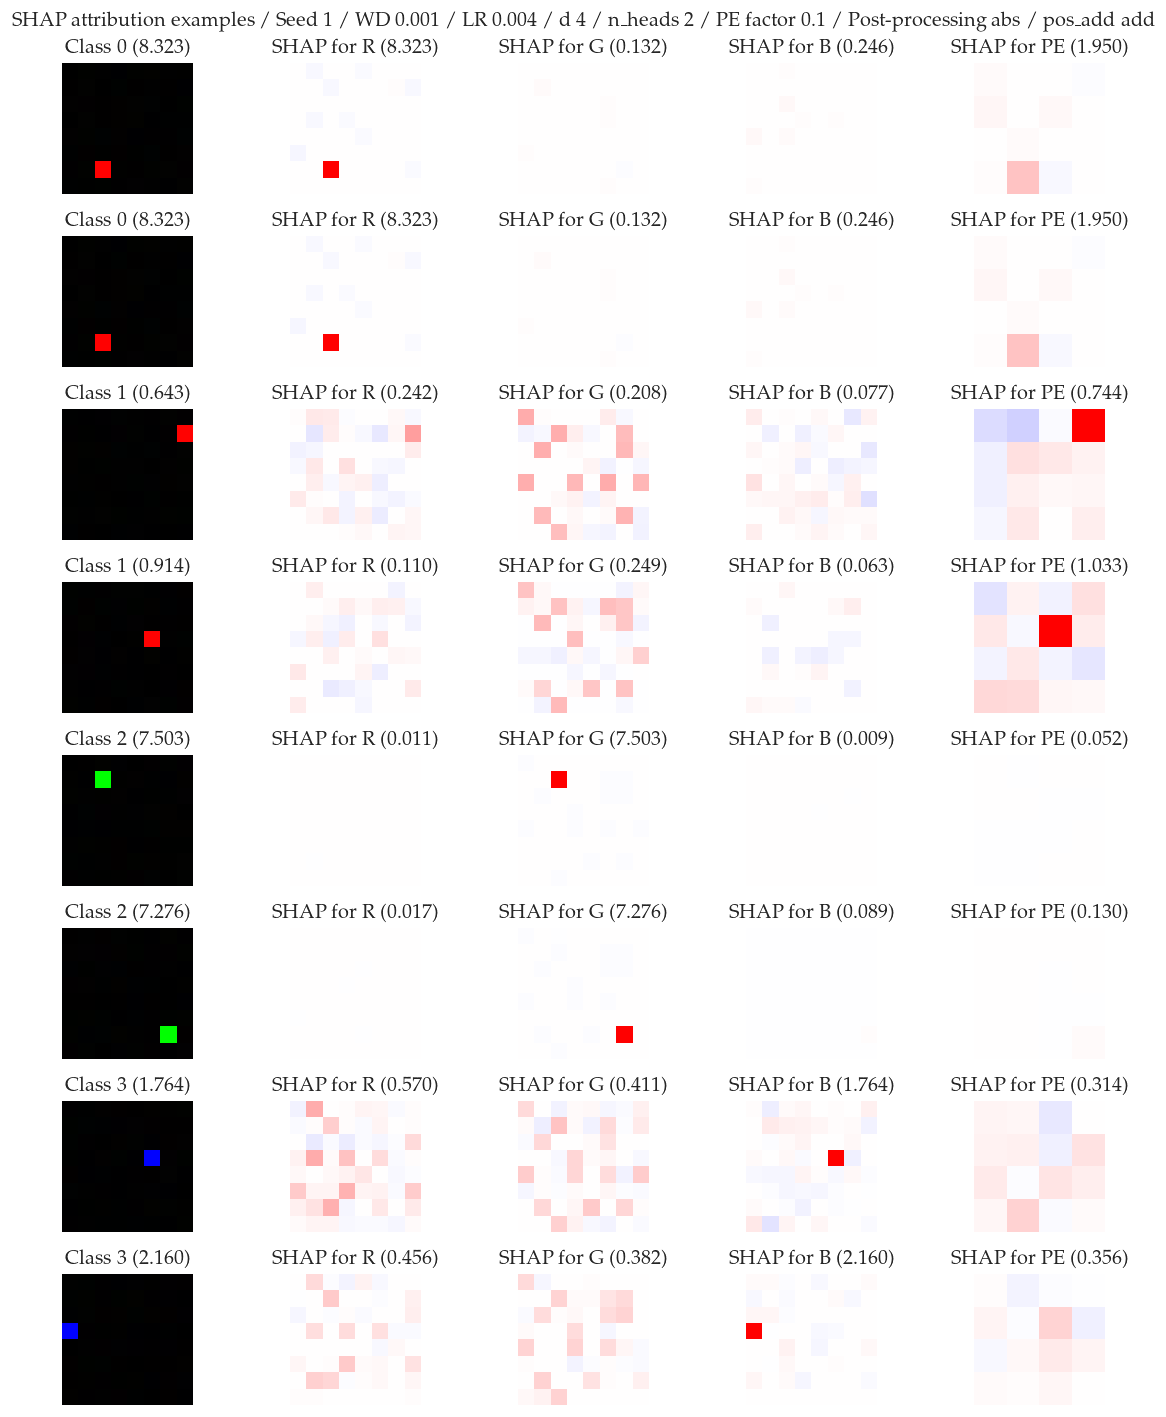

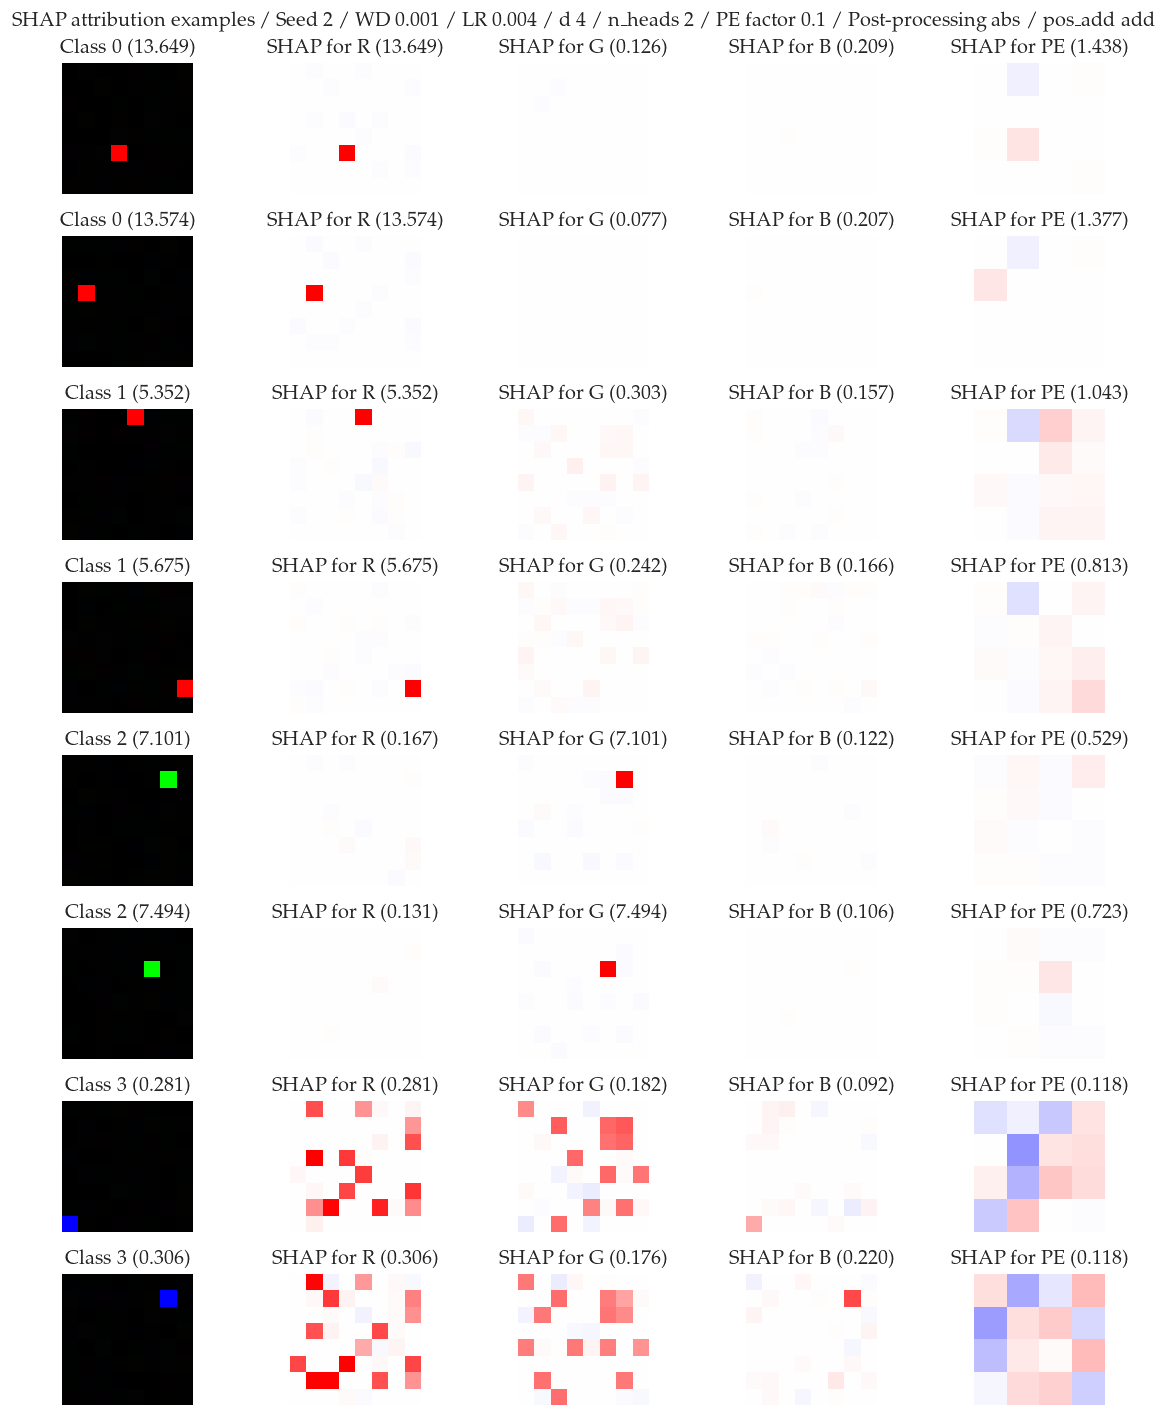

In [14]:
import torch

#
# Plot k example SHAP values for each class
#
k = 2

for seed in seeds:
    seed_image_shaps = image_shap_values[seed]
    seed_pe_shaps = pe_shap_values[seed]

    fig, axs = plt.subplots(k * n_classes, 5, figsize=(5 * 2, 2 * k * c), dpi=120)
    fig.suptitle(f"SHAP attribution examples / Seed {seed} / WD {weight_decay} / LR {lr} / d {d} / n_heads {n_heads} / PE factor {pos_emb_factor} / Post-processing {postprocessing} / pos_add {pos_add}")

    for c in range(n_classes):
        # seed_image_shaps = (N, Cin, H, W, Cout)
        class_mask = test_labels == c

        class_images = test_images[class_mask]
        class_image_shaps = seed_image_shaps[:,:,:,:,c]
        class_image_shaps = class_image_shaps[class_mask]
        # class_image_shaps = (N_c, Cin, H, W)

        class_pe_shaps = seed_pe_shaps[:,:,:,:,c]
        class_pe_shaps = class_pe_shaps[class_mask]

        # Sample k examples
        inds = torch.randint(0, len(class_images), (k,))
        sample_images = class_images[inds]
        sample_image_shaps = class_image_shaps[inds]
        sample_pe_shaps = class_pe_shaps[inds]

        for ik in range(k):
            image = sample_images[ik]
            image_shap = sample_image_shaps[ik]
            pe_shap = sample_pe_shaps[ik]
            shap_max = torch.cat([image_shap.reshape(-1), pe_shap.reshape(-1)], dim=0).abs().max()

            # Sum over PE dimensions, because they do not correspond to color
            # channels but rather should be aggregated
            pe_shap = pe_shap.sum(dim=0)

            axs[k*c + ik, 0].imshow(image.permute(1, 2, 0))
            axs[k*c + ik, 0].set_title(f"Class {c} ({shap_max:.3f})")
            axs[k*c + ik, 0].axis('off')

            axs[k*c + ik, 1].imshow(image_shap[0], cmap='bwr', vmin=-shap_max, vmax=shap_max)
            axs[k*c + ik, 1].set_title(f"SHAP for R ({image_shap[0].abs().max():.3f})")
            axs[k*c + ik, 1].axis('off')

            axs[k*c + ik, 2].imshow(image_shap[1], cmap='bwr', vmin=-shap_max, vmax=shap_max)
            axs[k*c + ik, 2].set_title(f"SHAP for G ({image_shap[1].abs().max():.3f})")
            axs[k*c + ik, 2].axis('off')

            axs[k*c + ik, 3].imshow(image_shap[2], cmap='bwr', vmin=-shap_max, vmax=shap_max)
            axs[k*c + ik, 3].set_title(f"SHAP for B ({image_shap[2].abs().max():.3f})")
            axs[k*c + ik, 3].axis('off')

            axs[k*c + ik, 4].imshow(pe_shap, cmap='bwr', vmin=-shap_max, vmax=shap_max)
            axs[k*c + ik, 4].set_title(f"SHAP for PE ({pe_shap.abs().max():.3f})")
            axs[k*c + ik, 4].axis('off')

    plt.tight_layout()

### SHAP Scatterplots

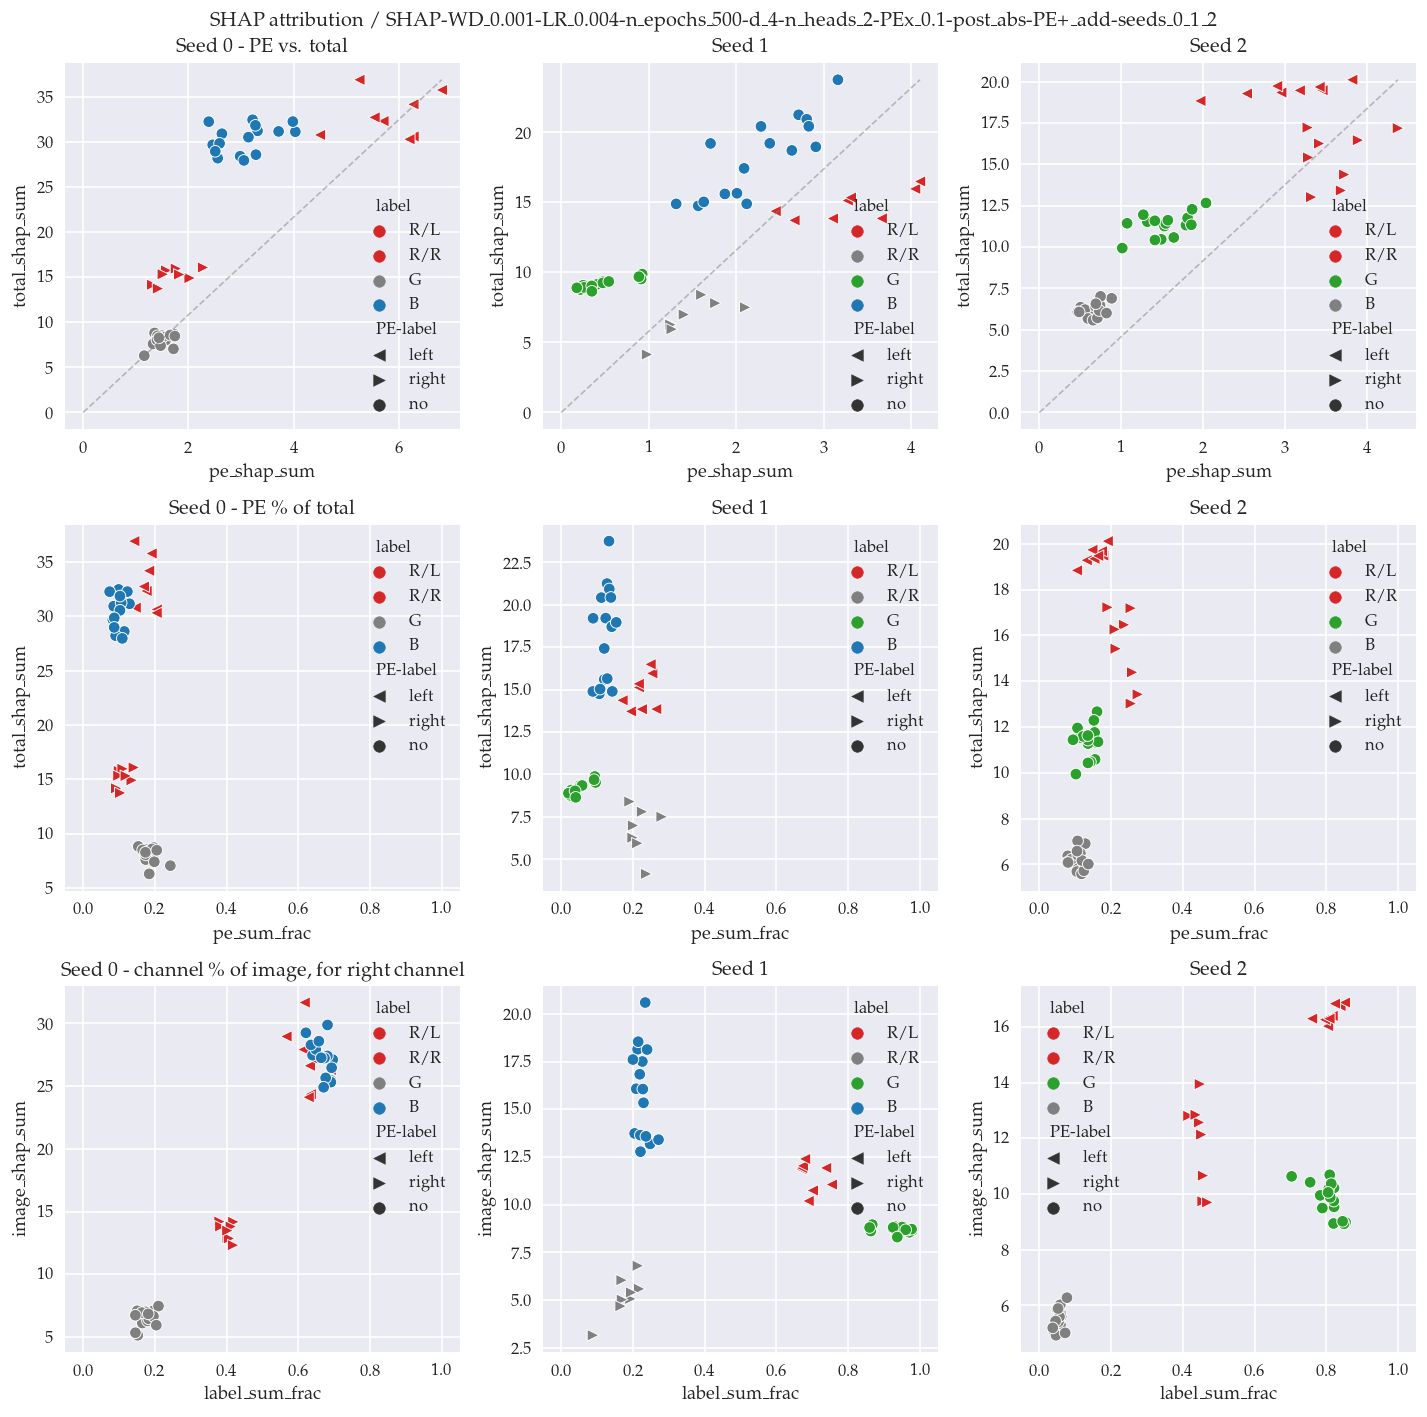

In [48]:
#
# Plot scatterplots
#
fig, axs = plt.subplots(3, len(seeds), figsize=(4 * len(seeds), 4 * 3), dpi=120)
plot_name = f"SHAP-WD_{weight_decay}-LR_{lr}-n_epochs_{n_epochs}-d_{d}-n_heads_{n_heads}-PEx_{pos_emb_factor}-post_{postprocessing}-PE+_{pos_add}-seeds_{'_'.join(map(str, seeds))}"
shap_scatterplots(image_shap_values, pe_shap_values, seeds, axs, start_row=0, plot_pe_shap_sum=True, plot_pe_sum_frac=True, plot_label_sum_frac=True)
plt.tight_layout()
# plt.savefig(f"debug-attribution-variance-plots/{run_name}/{plot_name}.pdf")
# plt.close()

# Double toy setting: No position + only position

Runs a two-class appearance-only and a two-class position-only setting in sequence, then plots the results in the same graphs, to contrast against a four-class mixed position and appearance setting.

## Dataset: no position + only position

2 classes
36 training samples
36 test samples
36 analysis samples
2 classes
72 training samples
72 test samples
72 analysis samples


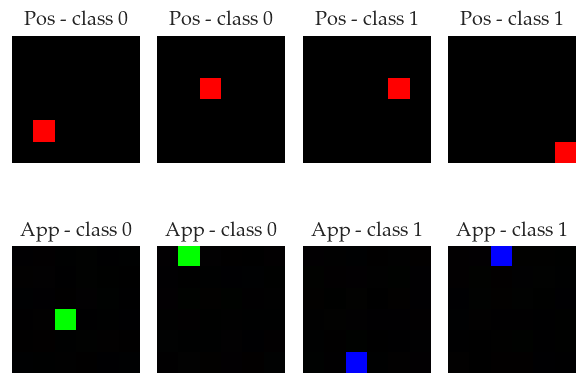

In [7]:
%autoreload
import datasets

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

size = 6
patch_size = 1

images, labels, n_classes = datasets.dataset_absolute_position(size=[size, size], color=0)
print(f"{n_classes} classes")
train_images_pos, train_labels_pos, test_images_pos, test_labels_pos, analysis_images_pos, analysis_labels_pos = datasets.split_appearance(images, labels)

images, labels, n_classes = datasets.dataset_appearance(size=[size, size], colors=[1, 2])
print(f"{n_classes} classes")
train_images_app, train_labels_app, test_images_app, test_labels_app, analysis_images_app, analysis_labels_app = datasets.split_appearance(images, labels)


fig, axs = plt.subplots(2, n_classes * 2, figsize=(1 + n_classes * 2, 4), dpi=120)
j = 0
for c in range(n_classes):
    for i in range(2):
        inds = train_labels_pos == c
        axs[0,j].imshow(train_images_pos[inds][i].permute((1, 2, 0)))
        axs[0,j].set_title(f"Pos - class {train_labels_pos[inds][i]}")
        axs[0,j].axis('off')

        inds = train_labels_app == c
        axs[1,j].imshow(train_images_app[inds][i].permute((1, 2, 0)))
        axs[1,j].set_title(f"App - class {train_labels_app[inds][i]}")
        axs[1,j].axis('off')

        j += 1

plt.tight_layout()
pass

## Run

In [9]:
%autoreload
from toy_models import TriViTalAbsolutePosition
from experiments import run

import pandas as pd
import seaborn as sns
import tqdm

# n_epochs = 4000
n_epochs = 500
report_every_n = 100
pos_emb = 'absolute'
use_rel_pos = False
save_raw = 'debug'

# Debug
# debug = True
# seeds = range(3)
# lrs = [4e-3]
# weight_decays = [1e-3]
# ds = [16]
# ns_heads = [4]
# pos_emb_factors = [0.02]
# postprocessings = ['abs']
# pos_adds = ['add']

# Run 11: wide search on new setting with test set
run_name = "run11-app+pos"
debug = False
lrs = [4e-2, 4e-3, 4e-4]
weight_decays = [1e-3, 1e-4]
ds = [16, 16]
ns_heads = [8, 4]
pos_emb_factors = [0.1, 0.02]
seeds = range(5)
postprocessings = ['abs', 'none', 'max']
pos_adds = ['add', 'concat_equald']


# Plot?
plots = False

# seeds = seeds[:1]
if plots and len(seeds) > 1:
    raise ValueError("Only one seed supported for visualizing samples. Turn off `plots` or override `seeds = seeds[:1]`")

for weight_decay in tqdm.notebook.tqdm(weight_decays, desc='weight_decays'):
    for lr in tqdm.notebook.tqdm(lrs, desc='lrs'):
        for d, n_heads in tqdm.notebook.tqdm(zip(ds, ns_heads), desc='d/n_heads', total=len(ds)):
            for pos_emb_factor in tqdm.notebook.tqdm(pos_emb_factors, desc='pos_emb_factors'):
                for postprocessing in tqdm.notebook.tqdm(postprocessings, desc='postprocessings'):
                    for pos_add in tqdm.notebook.tqdm(pos_adds, desc='pos_adds'):
                        #
                        # TRAIN
                        #

                        print(f"\n\nWeight decay: {weight_decay} / LR: {lr} / d: {d} / n_heads: {n_heads} / PE factor: {pos_emb_factor} / Post-processing: {postprocessing} / pos_add: {pos_add}")

                        _, accs_pos, _, _, shap_values = run('absolute_position', seeds, n_epochs, lr, d, n_heads,
                            n_classes, pos_emb, use_rel_pos, train_images_pos, train_labels_pos,
                            test_images_pos, test_labels_pos, test_images_pos, test_labels_pos,
                            size=size,
                            report_every_n=report_every_n, weight_decay=weight_decay,
                            pos_emb_factor=pos_emb_factor, pos_add=pos_add,
                            patch_size=patch_size, save_raw=save_raw + '_pos')

                        _, accs_app, _, _,  = run('absolute_position', seeds, n_epochs, lr, d, n_heads,
                            n_classes, pos_emb, use_rel_pos, train_images_app, train_labels_app,
                            test_images_app, test_labels_app, test_images_app, test_labels_app,
                            size=size,
                            report_every_n=report_every_n, weight_decay=weight_decay,
                            pos_emb_factor=pos_emb_factor, pos_add=pos_add,
                            patch_size=patch_size, save_raw=save_raw + '_app')

                        #
                        # ANALYSE
                        #

                        batched = False
                        # Use the filepath composed in the training cell
                        image_source = 'saved'
                        dataset_images = None
                        pos_emb_emb_dim = 0

                        # Sort all entries by the magnitude of the pos_emb saliency map
                        # Visualize the top n and bottom n
                        top_n = 5
                        bot_n = 5

                        # Normalize saliency maps by the maximum over all maps or by itself
                        normalize_global = True
                        rank_by = 'pos_emb'

                        # Plot
                        fig, axs = plt.subplots(3, len(seeds), figsize=(4 * len(seeds), 4 * 3), dpi=120)
                        plot_name = f"WD_{weight_decay}-LR_{lr}-n_epochs_{n_epochs}-d_{d}-n_heads_{n_heads}-PEx_{pos_emb_factor}-post_{postprocessing}-PE+_{pos_add}-seeds_{'_'.join(map(str, seeds))}"
                        # If either task failed to reach 100% accuracy, mark
                        # this in the name and prevent the seed from being
                        # marked as a success
                        seeds_fail = []
                        for i, acc in enumerate(accs_pos):
                            if acc < 1.0:
                                plot_name += f"-S{i}POS{acc:.3f}"
                                seeds_fail.append(i)
                        for i, acc in enumerate(accs_app):
                            if acc < 1.0:
                                plot_name += f"-S{i}APP{acc:.3f}"
                                seeds_fail.append(i)
                        fig.suptitle(f"PE vs. non-PE attribution / {plot_name}")

                        for i, seed in enumerate(seeds):
                            filepath = f"./toy_saliency_maps/debug_pos_{seed}.pt"
                            index_pos = \
                                attribution_stats(filepath, batched, rank_by=rank_by, postprocessing=postprocessing)
                                # visualize_ranked(filepath, batched, image_source,
                                #                 dataset_images, top_n, bot_n,
                                #                 normalize_global, rank_by=rank_by,
                                #                 pos_emb_emb_dim=pos_emb_emb_dim,
                                #                 postprocessing=postprocessing,
                                #                 plots=plots)

                            filepath = f"./toy_saliency_maps/debug_app_{seed}.pt"
                            index_app = \
                                attribution_stats(filepath, batched, rank_by=rank_by, postprocessing=postprocessing)
                                # visualize_ranked(filepath, batched, image_source,
                                #                 dataset_images, top_n, bot_n,
                                #                 normalize_global, rank_by=rank_by,
                                #                 pos_emb_emb_dim=pos_emb_emb_dim,
                                #                 postprocessing=postprocessing,
                                #                 plots=plots)

                            df_pos = pd.DataFrame(index_pos, columns=['rank', 'index', 'batch', 'index_in_batch', 'image', 'bias', 'pos_emb', 'pos_emb_all', 'label'])
                            df_app = pd.DataFrame(index_app, columns=['rank', 'index', 'batch', 'index_in_batch', 'image', 'bias', 'pos_emb', 'pos_emb_all', 'label'])

                            df_pos['uses-PE'] = True
                            df_pos['label'] = df_pos['label'].apply(lambda x: str(x.item()) + "_pos")
                            df_app['uses-PE'] = False
                            df_app['label'] = df_app['label'].apply(lambda x: str(x.item()) + "_app")

                            df = pd.concat([df_pos, df_app])

                            # Convert columns from tensor to float
                            df['image'] = df['image'].apply(lambda x: x.item())
                            df['bias'] = df['bias'].apply(lambda x: x.item())
                            df['pos_emb'] = df['pos_emb'].apply(lambda x: x.item())
                            df['pos_emb (frac. of all)'] = df['pos_emb_all'].apply(lambda x: x.item())

                            df['image + bias'] = df['image'] + df['bias']
                            df['all'] = df['image'] + df['bias'] + df['pos_emb']

                            # pos_emb percentage of all vs. all
                            sns.scatterplot(data=df, x='pos_emb (frac. of all)', y='all', hue='label', style='uses-PE', style_order=[True, False], ax=axs[0,i])

                            # Scatterplot with identical limits on x and y axes
                            sns.scatterplot(data=df, x='pos_emb', y='image + bias', hue='label', style='uses-PE', style_order=[True, False], ax=axs[1,i])
                            axs[1,i].set_title(f"Seed {seed}")
                            # Set axs[i] axes to same range
                            limit = max(axs[1,i].get_xlim()[1], axs[1,i].get_ylim()[1])
                            axs[1,i].set_xlim(0, limit)
                            axs[1,i].set_ylim(0, limit)

                            # Same plot with fitted axes, for better visual discrimination
                            sns.scatterplot(data=df, x='pos_emb', y='image + bias', hue='label', style='uses-PE', style_order=[True, False], ax=axs[2,i])

                            # If the average fraction of pos_emb is higher for both PE-using classes than for both PE-not-using classes, mark this in the name and on the plot
                            class_0_mean = df[df['label'] == "0_pos"]['pos_emb (frac. of all)'].mean()
                            class_1_mean = df[df['label'] == "1_pos"]['pos_emb (frac. of all)'].mean()
                            class_2_mean = df[df['label'] == "0_app"]['pos_emb (frac. of all)'].mean()
                            class_3_mean = df[df['label'] == "1_app"]['pos_emb (frac. of all)'].mean()
                            if i in seeds_fail:
                                axs[0,i].set_title(f"Seed {seed} (TR. FAIL: {accs_pos[i]:.2f} / {accs_app[i]:.2f})")
                            elif class_0_mean > class_2_mean and class_1_mean > class_2_mean and class_0_mean > class_3_mean and class_1_mean > class_3_mean:
                                plot_name += f"-S{seed}SUCCESS"
                                axs[0,i].set_title(f"Seed {seed} (SUCCESS)")
                            else:
                                axs[0,i].set_title(f"Seed {seed}")

                        plt.tight_layout()

                        if not debug:
                            plt.savefig(f"debug-attribution-variance-plots/{run_name}/{plot_name}.pdf")
                            plt.close()

weight_decays:   0%|          | 0/2 [00:00<?, ?it/s]

lrs:   0%|          | 0/3 [00:00<?, ?it/s]

d/n_heads:   0%|          | 0/2 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.7966063618659973
Epoch 200: 2.31795826977077e-08
Epoch 300: 3.2493444450665265e-05
Epoch 400: 7.896634633652866e-05
Epoch 499: 1.866599202156067
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6931485533714294
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931468844413757
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.693

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0: 0.725999116897583
Epoch 100: 6.126032303654938e-08
Epoch 200: 8.019295637495816e-05
Epoch 300: 0.00012447111657820642
Epoch 400: 0.0001261597208213061
Epoch 499: 0.00012927860370837152
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 2.9917324354755692e-05
Epoch 200: 0.00023924655397422612
Epoch 300: 0.0
Epoch 400: 3.6157456634100527e-05
Epoch 499: 0.00011954957153648138
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 5.443860572995618e-06
Epoch 200: 0.00010523341916268691
Epoch 300: 0.0001419707405148074
Epoch 400: 0.0001328524376731366
Epoch 499: 0.0001298858260270208
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.0
Epoch 200: 0.0002024540153797716
Epoch 300: 0.0001723062596283853
Epoch 400: 0.00016065221279859543
Epoch 499: 0.00012843920558225363
Accuracy: 1.0
Saved saliency maps to ./t

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6931474208831787
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931470632553101
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 1.9228888750076294
Epoch 200: 7.410371472360566e-05
Epoch 300: 0.0002247559023089707
Epoch 400: 0.0004305957700125873
Epoch 499: 0.0004460016789380461
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6931480169296265
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
E

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 8.775127469107247e-08
Epoch 200: 0.00013304949970915914
Epoch 300: 0.00017640189616940916
Epoch 400: 0.0001552230241941288
Epoch 499: 0.00014239673328120261
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.0
Epoch 200: 0.0002009699383052066
Epoch 300: 0.0001992079196497798
Epoch 400: 0.00011712743435055017
Epoch 499: 0.00013958188355900347
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 1.1920927533992653e-07
Epoch 200: 0.00019694381626322865
Epoch 300: 0.00013540337386075407
Epoch 400: 0.00013057600881438702
Epoch 499: 0.000130600921693258
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 2.7103483262180816e-06
Epoch 200: 7.957017078297213e-05
Epoch 300: 0.000128455096273683
Epoch 400: 0.00014298780297394842
Epoch 499: 0.00013736094115301967
Accuracy: 1.0
Saved saliency maps to ./toy_salienc

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.7966063618659973
Epoch 200: 2.31795826977077e-08
Epoch 300: 3.2493444450665265e-05
Epoch 400: 7.896634633652866e-05
Epoch 499: 1.866599202156067
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6931485533714294
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931468844413757
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.69

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.126032303654938e-08
Epoch 200: 8.019295637495816e-05
Epoch 300: 0.00012447111657820642
Epoch 400: 0.0001261597208213061
Epoch 499: 0.00012927860370837152
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 2.9917324354755692e-05
Epoch 200: 0.00023924655397422612
Epoch 300: 0.0
Epoch 400: 3.6157456634100527e-05
Epoch 499: 0.00011954957153648138
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 5.443860572995618e-06
Epoch 200: 0.00010523341916268691
Epoch 300: 0.0001419707405148074
Epoch 400: 0.0001328524376731366
Epoch 499: 0.0001298858260270208
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.0
Epoch 200: 0.0002024540153797716
Epoch 300: 0.0001723062596283853
Epoch 400: 0.00016065221279859543
Epoch 499: 0.00012843920558225363
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6931474208831787
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931470632553101
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 1.9228888750076294
Epoch 200: 7.410371472360566e-05
Epoch 300: 0.0002247559023089707
Epoch 400: 0.0004305957700125873
Epoch 499: 0.0004460016789380461
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6931480169296265
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996


/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 8.775127469107247e-08
Epoch 200: 0.00013304949970915914
Epoch 300: 0.00017640189616940916
Epoch 400: 0.0001552230241941288
Epoch 499: 0.00014239673328120261
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.0
Epoch 200: 0.0002009699383052066
Epoch 300: 0.0001992079196497798
Epoch 400: 0.00011712743435055017
Epoch 499: 0.00013958188355900347
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 1.1920927533992653e-07
Epoch 200: 0.00019694381626322865
Epoch 300: 0.00013540337386075407
Epoch 400: 0.00013057600881438702
Epoch 499: 0.000130600921693258
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 2.7103483262180816e-06
Epoch 200: 7.957017078297213e-05
Epoch 300: 0.000128455096273683
Epoch 400: 0.00014298780297394842
Epoch 499: 0.00013736094115301967
Accuracy: 1.0
Saved saliency maps to ./toy_salienc

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.7966063618659973
Epoch 200: 2.31795826977077e-08
Epoch 300: 3.2493444450665265e-05
Epoch 400: 7.896634633652866e-05
Epoch 499: 1.866599202156067
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6931485533714294
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931468844413757
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.693

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.126032303654938e-08
Epoch 200: 8.019295637495816e-05
Epoch 300: 0.00012447111657820642
Epoch 400: 0.0001261597208213061
Epoch 499: 0.00012927860370837152
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 2.9917324354755692e-05
Epoch 200: 0.00023924655397422612
Epoch 300: 0.0
Epoch 400: 3.6157456634100527e-05
Epoch 499: 0.00011954957153648138
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 5.443860572995618e-06
Epoch 200: 0.00010523341916268691
Epoch 300: 0.0001419707405148074
Epoch 400: 0.0001328524376731366
Epoch 499: 0.0001298858260270208
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.0
Epoch 200: 0.0002024540153797716
Epoch 300: 0.0001723062596283853
Epoch 400: 0.00016065221279859543
Epoch 499: 0.00012843920558225363
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6931474208831787
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931470632553101
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 1.9228888750076294
Epoch 200: 7.410371472360566e-05
Epoch 300: 0.0002247559023089707
Epoch 400: 0.0004305957700125873
Epoch 499: 0.0004460016789380461
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6931480169296265
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
E

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 8.775127469107247e-08
Epoch 200: 0.00013304949970915914
Epoch 300: 0.00017640189616940916
Epoch 400: 0.0001552230241941288
Epoch 499: 0.00014239673328120261
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.0
Epoch 200: 0.0002009699383052066
Epoch 300: 0.0001992079196497798
Epoch 400: 0.00011712743435055017
Epoch 499: 0.00013958188355900347
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 1.1920927533992653e-07
Epoch 200: 0.00019694381626322865
Epoch 300: 0.00013540337386075407
Epoch 400: 0.00013057600881438702
Epoch 499: 0.000130600921693258
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 2.7103483262180816e-06
Epoch 200: 7.957017078297213e-05
Epoch 300: 0.000128455096273683
Epoch 400: 0.00014298780297394842
Epoch 499: 0.00013736094115301967
Accuracy: 1.0
Saved saliency maps to ./toy_salienc

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.5948439836502075
Epoch 200: 5.4351072321878746e-05
Epoch 300: 0.0003178982879035175
Epoch 400: 0.0002631974930409342
Epoch 499: 0.0002221367321908474
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6931478977203369
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931471228599548
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6931460499763489
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.00012890325160697103
Epoch 200: 0.0001456539030186832
Epoch 300: 0.00014108048344496638
Epoch 400: 0.00013470050180330873
Epoch 499: 0.00013475514424499124
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 1.3237022358225659e-05
Epoch 200: 0.000143381257657893
Epoch 300: 8.06477419246221e-06
Epoch 400: 0.00015831002383492887
Epoch 499: 0.00013879429025109857
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 2.1273437596391886e-05
Epoch 200: 8.733160211704671e-05
Epoch 300: 3.6425056748612405e-08
Epoch 400: 1.5613077266607434e-06
Epoch 499: 0.00013884469808544964
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 4.59340080851689e-05
Epoch 200: 0.011397789232432842
Epoch 300: 7.458407344529405e-05
Epoch 400: 0.00013565759581979364
Epoch 499: 0.00013222417328506708
Accuracy: 1.0
Saved saliency maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931470632553101
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931470632553101
Epoch 499: 0.6931471228599548
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6931480765342712
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471228599548
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931473016738892
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6931480169296265
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.228645816008793e-06
Epoch 200: 9.026196494232863e-05
Epoch 300: 0.00017117882089223713
Epoch 400: 0.00016675096412654966
Epoch 499: 0.00014429203292820603
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.0
Epoch 200: 0.00019970705034211278
Epoch 300: 0.00016440531180705875
Epoch 400: 0.0001286687474930659
Epoch 499: 0.0001325250486843288
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 2.3841855067985307e-07
Epoch 200: 0.00020293543639127165
Epoch 300: 0.00016711617354303598
Epoch 400: 0.0001484634558437392
Epoch 499: 0.0001388090313412249
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 3.943825504393317e-06
Epoch 200: 0.00012249821156729013
Epoch 300: 8.305712981382385e-05
Epoch 400: 0.00010979027865687385
Epoch 499: 0.00014009089500177652
Accuracy: 1.0
Saved saliency maps to ./toy_sali

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.5948439836502075
Epoch 200: 5.4351072321878746e-05
Epoch 300: 0.0003178982879035175
Epoch 400: 0.0002631974930409342
Epoch 499: 0.0002221367321908474
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6931478977203369
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931471228599548
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6931460499763489
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 40

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.00012890325160697103
Epoch 200: 0.0001456539030186832
Epoch 300: 0.00014108048344496638
Epoch 400: 0.00013470050180330873
Epoch 499: 0.00013475514424499124
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 1.3237022358225659e-05
Epoch 200: 0.000143381257657893
Epoch 300: 8.06477419246221e-06
Epoch 400: 0.00015831002383492887
Epoch 499: 0.00013879429025109857
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 2.1273437596391886e-05
Epoch 200: 8.733160211704671e-05
Epoch 300: 3.6425056748612405e-08
Epoch 400: 1.5613077266607434e-06
Epoch 499: 0.00013884469808544964
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 4.59340080851689e-05
Epoch 200: 0.011397789232432842
Epoch 300: 7.458407344529405e-05
Epoch 400: 0.00013565759581979364
Epoch 499: 0.00013222417328506708
Accuracy: 1.0
Saved saliency maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931470632553101
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931470632553101
Epoch 499: 0.6931471228599548
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6931480765342712
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471228599548
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931473016738892
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6931480169296265
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.228645816008793e-06
Epoch 200: 9.026196494232863e-05
Epoch 300: 0.00017117882089223713
Epoch 400: 0.00016675096412654966
Epoch 499: 0.00014429203292820603
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.0
Epoch 200: 0.00019970705034211278
Epoch 300: 0.00016440531180705875
Epoch 400: 0.0001286687474930659
Epoch 499: 0.0001325250486843288
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 2.3841855067985307e-07
Epoch 200: 0.00020293543639127165
Epoch 300: 0.00016711617354303598
Epoch 400: 0.0001484634558437392
Epoch 499: 0.0001388090313412249
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 3.943825504393317e-06
Epoch 200: 0.00012249821156729013
Epoch 300: 8.305712981382385e-05
Epoch 400: 0.00010979027865687385
Epoch 499: 0.00014009089500177652
Accuracy: 1.0
Saved saliency maps to ./toy_sali

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.5948439836502075
Epoch 200: 5.4351072321878746e-05
Epoch 300: 0.0003178982879035175
Epoch 400: 0.0002631974930409342
Epoch 499: 0.0002221367321908474
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6931478977203369
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931471228599548
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6931460499763489
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.00012890325160697103
Epoch 200: 0.0001456539030186832
Epoch 300: 0.00014108048344496638
Epoch 400: 0.00013470050180330873
Epoch 499: 0.00013475514424499124
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 1.3237022358225659e-05
Epoch 200: 0.000143381257657893
Epoch 300: 8.06477419246221e-06
Epoch 400: 0.00015831002383492887
Epoch 499: 0.00013879429025109857
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 2.1273437596391886e-05
Epoch 200: 8.733160211704671e-05
Epoch 300: 3.6425056748612405e-08
Epoch 400: 1.5613077266607434e-06
Epoch 499: 0.00013884469808544964
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 4.59340080851689e-05
Epoch 200: 0.011397789232432842
Epoch 300: 7.458407344529405e-05
Epoch 400: 0.00013565759581979364
Epoch 499: 0.00013222417328506708
Accuracy: 1.0
Saved saliency maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931470632553101
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931470632553101
Epoch 499: 0.6931471228599548
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6931480765342712
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471228599548
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931473016738892
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6931480169296265
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.228645816008793e-06
Epoch 200: 9.026196494232863e-05
Epoch 300: 0.00017117882089223713
Epoch 400: 0.00016675096412654966
Epoch 499: 0.00014429203292820603
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.0
Epoch 200: 0.00019970705034211278
Epoch 300: 0.00016440531180705875
Epoch 400: 0.0001286687474930659
Epoch 499: 0.0001325250486843288
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 2.3841855067985307e-07
Epoch 200: 0.00020293543639127165
Epoch 300: 0.00016711617354303598
Epoch 400: 0.0001484634558437392
Epoch 499: 0.0001388090313412249
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 3.943825504393317e-06
Epoch 200: 0.00012249821156729013
Epoch 300: 8.305712981382385e-05
Epoch 400: 0.00010979027865687385
Epoch 499: 0.00014009089500177652
Accuracy: 1.0
Saved saliency maps to ./toy_sali

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6931473016738892
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931472420692444
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.6931477785110474
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6931467652320862
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931471228599548
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931470632

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.00010222296987194568
Epoch 200: 0.00010782769095385447
Epoch 300: 0.00011958035611314699
Epoch 400: 5.033278966948274e-07
Epoch 499: 5.4861404350958765e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 2.7046531613450497e-05
Epoch 200: 0.0002828564902301878
Epoch 300: 0.00022959729540161788
Epoch 400: 0.00015200332563836128
Epoch 499: 0.00014844404358882457
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.0
Epoch 200: 0.00017179672431666404
Epoch 300: 5.165732659406785e-07
Epoch 400: 0.00010795402340590954
Epoch 499: 0.00016491516726091504
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 1.4429080692934804e-05
Epoch 200: 0.00014313295832835138
Epoch 300: 0.00016802240861579776
Epoch 400: 0.0001321923773502931
Epoch 499: 0.00012735500058624893
Accuracy: 1.0
Saved saliency maps to ./toy_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6931473016738892
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931473016738892
Epoch 499: 0.6931471228599548
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 1.4901151246249356e-07
Epoch 200: 7.215423465822823e-06
Epoch 300: 0.00021421270503196865
Epoch 400: 1.145702838897705
Epoch 499: 0.00041707101627252996
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6931469440460205
Epoch 200: 0.6931473016738892
Epoch 300: 0.6931471824645996

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.8378096910964814e-07
Epoch 200: 0.00016114306345116347
Epoch 300: 0.0001978413638425991
Epoch 400: 0.00015860452549532056
Epoch 499: 0.00014361001376528293
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.0
Epoch 200: 0.00022014424030203372
Epoch 300: 0.00017108312749769539
Epoch 400: 0.00013753089297097176
Epoch 499: 0.0001317914284300059
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 9.828047041082755e-06
Epoch 200: 0.0001849187392508611
Epoch 300: 0.00016462865460198373
Epoch 400: 0.00015787975280545652
Epoch 499: 0.00013878283789381385
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 1.0727064363891259e-05
Epoch 200: 0.00017165954341180623
Epoch 300: 0.0001367352087981999
Epoch 400: 0.00013320572907105088
Epoch 499: 0.00013404169294517487
Accuracy: 1.0
Saved saliency maps to ./toy_s

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6931473016738892
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931472420692444
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.6931477785110474
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6931467652320862
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931471228599548
Epoch 300: 0.6931471824645996
Epoch 400: 0.693147063

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.00010222296987194568
Epoch 200: 0.00010782769095385447
Epoch 300: 0.00011958035611314699
Epoch 400: 5.033278966948274e-07
Epoch 499: 5.4861404350958765e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 2.7046531613450497e-05
Epoch 200: 0.0002828564902301878
Epoch 300: 0.00022959729540161788
Epoch 400: 0.00015200332563836128
Epoch 499: 0.00014844404358882457
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.0
Epoch 200: 0.00017179672431666404
Epoch 300: 5.165732659406785e-07
Epoch 400: 0.00010795402340590954
Epoch 499: 0.00016491516726091504
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 1.4429080692934804e-05
Epoch 200: 0.00014313295832835138
Epoch 300: 0.00016802240861579776
Epoch 400: 0.0001321923773502931
Epoch 499: 0.00012735500058624893
Accuracy: 1.0
Saved saliency maps to ./toy_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6931473016738892
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931473016738892
Epoch 499: 0.6931471228599548
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 1.4901151246249356e-07
Epoch 200: 7.215423465822823e-06
Epoch 300: 0.00021421270503196865
Epoch 400: 1.145702838897705
Epoch 499: 0.00041707101627252996
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6931469440460205
Epoch 200: 0.6931473016738892
Epoch 300: 0.693147182464599

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.8378096910964814e-07
Epoch 200: 0.00016114306345116347
Epoch 300: 0.0001978413638425991
Epoch 400: 0.00015860452549532056
Epoch 499: 0.00014361001376528293
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.0
Epoch 200: 0.00022014424030203372
Epoch 300: 0.00017108312749769539
Epoch 400: 0.00013753089297097176
Epoch 499: 0.0001317914284300059
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 9.828047041082755e-06
Epoch 200: 0.0001849187392508611
Epoch 300: 0.00016462865460198373
Epoch 400: 0.00015787975280545652
Epoch 499: 0.00013878283789381385
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 1.0727064363891259e-05
Epoch 200: 0.00017165954341180623
Epoch 300: 0.0001367352087981999
Epoch 400: 0.00013320572907105088
Epoch 499: 0.00013404169294517487
Accuracy: 1.0
Saved saliency maps to ./toy_s

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6931473016738892
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931472420692444
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.6931477785110474
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6931467652320862
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931471228599548
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931470632

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.00010222296987194568
Epoch 200: 0.00010782769095385447
Epoch 300: 0.00011958035611314699
Epoch 400: 5.033278966948274e-07
Epoch 499: 5.4861404350958765e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 2.7046531613450497e-05
Epoch 200: 0.0002828564902301878
Epoch 300: 0.00022959729540161788
Epoch 400: 0.00015200332563836128
Epoch 499: 0.00014844404358882457
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.0
Epoch 200: 0.00017179672431666404
Epoch 300: 5.165732659406785e-07
Epoch 400: 0.00010795402340590954
Epoch 499: 0.00016491516726091504
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 1.4429080692934804e-05
Epoch 200: 0.00014313295832835138
Epoch 300: 0.00016802240861579776
Epoch 400: 0.0001321923773502931
Epoch 499: 0.00012735500058624893
Accuracy: 1.0
Saved saliency maps to ./toy_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6931471824645996
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6931473016738892
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931473016738892
Epoch 499: 0.6931471228599548
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 1.4901151246249356e-07
Epoch 200: 7.215423465822823e-06
Epoch 300: 0.00021421270503196865
Epoch 400: 1.145702838897705
Epoch 499: 0.00041707101627252996
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6931469440460205
Epoch 200: 0.6931473016738892
Epoch 300: 0.6931471824645996

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.8378096910964814e-07
Epoch 200: 0.00016114306345116347
Epoch 300: 0.0001978413638425991
Epoch 400: 0.00015860452549532056
Epoch 499: 0.00014361001376528293
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.0
Epoch 200: 0.00022014424030203372
Epoch 300: 0.00017108312749769539
Epoch 400: 0.00013753089297097176
Epoch 499: 0.0001317914284300059
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 9.828047041082755e-06
Epoch 200: 0.0001849187392508611
Epoch 300: 0.00016462865460198373
Epoch 400: 0.00015787975280545652
Epoch 499: 0.00013878283789381385
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 1.0727064363891259e-05
Epoch 200: 0.00017165954341180623
Epoch 300: 0.0001367352087981999
Epoch 400: 0.00013320572907105088
Epoch 499: 0.00013404169294517487
Accuracy: 1.0
Saved saliency maps to ./toy_s

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.9008044004440308
Epoch 200: 0.6564217209815979
Epoch 300: 0.6929768919944763
Epoch 400: 0.6926582455635071
Epoch 499: 0.6710280776023865
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6931475400924683
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931470632553101
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931473016738892
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.0
Epoch 200: 3.5437566111795604e-05
Epoch 300: 5.960463766996327e-08
Epoch 400: 1.7963922800845467e

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.44324130815221e-05
Epoch 200: 6.694111652905121e-05
Epoch 300: 7.926341640995815e-05
Epoch 400: 8.290986443171278e-05
Epoch 499: 8.711332338862121e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 1.1920927533992653e-07
Epoch 200: 0.00018742682004813105
Epoch 300: 0.00021269757417030632
Epoch 400: 0.00018996073049493134
Epoch 499: 0.00014923838898539543
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 2.99678845294693e-07
Epoch 200: 0.0001998702937271446
Epoch 300: 0.00018344413547310978
Epoch 400: 0.0001408855023328215
Epoch 499: 0.00012868009798694402
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 9.297706856159493e-05
Epoch 200: 0.00022601841192226857
Epoch 300: 0.0
Epoch 400: 0.00011279570026090369
Epoch 499: 0.00014853171887807548
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6931473612785339
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.6931474208831787
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931472420692444
Epoch 400: 0.6931473016738892
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6931475400924683
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471228599548
Epoch 400: 0.

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 2.2172436729306355e-05
Epoch 300: 0.00017321945051662624
Epoch 400: 0.00017444661352783442
Epoch 499: 0.00016330274229403585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.0
Epoch 200: 0.00011023346451111138
Epoch 300: 0.00016741795116104186
Epoch 400: 0.00014041803660802543
Epoch 499: 0.00013231295451987535
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 1.0551567356742453e-05
Epoch 200: 0.00018568542145658284
Epoch 300: 0.00016591825988143682
Epoch 400: 0.00016216395306400955
Epoch 499: 0.00016251823399215937
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 8.989228081190959e-05
Epoch 200: 0.00015093485126271844
Epoch 300: 0.00013784909970127046
Epoch 400: 0.00013353167742025107
Epoch 499: 0.00013144573313184083
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/de

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.9008044004440308
Epoch 200: 0.6564217209815979
Epoch 300: 0.6929768919944763
Epoch 400: 0.6926582455635071
Epoch 499: 0.6710280776023865
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6931475400924683
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931470632553101
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931473016738892
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.0
Epoch 200: 3.5437566111795604e-05
Epoch 300: 5.960463766996327e-08
Epoch 400: 1.7963922800845467

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.44324130815221e-05
Epoch 200: 6.694111652905121e-05
Epoch 300: 7.926341640995815e-05
Epoch 400: 8.290986443171278e-05
Epoch 499: 8.711332338862121e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 1.1920927533992653e-07
Epoch 200: 0.00018742682004813105
Epoch 300: 0.00021269757417030632
Epoch 400: 0.00018996073049493134
Epoch 499: 0.00014923838898539543
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 2.99678845294693e-07
Epoch 200: 0.0001998702937271446
Epoch 300: 0.00018344413547310978
Epoch 400: 0.0001408855023328215
Epoch 499: 0.00012868009798694402
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 9.297706856159493e-05
Epoch 200: 0.00022601841192226857
Epoch 300: 0.0
Epoch 400: 0.00011279570026090369
Epoch 499: 0.00014853171887807548
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_

/tmp/ipykernel_205865/1844324156.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(3, len(seeds), figsize=(4 * len(seeds), 4 * 3), dpi=120)


Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6931473612785339
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.6931474208831787
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931472420692444
Epoch 400: 0.6931473016738892
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6931475400924683
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471228599548
Epoch 400: 0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 2.2172436729306355e-05
Epoch 300: 0.00017321945051662624
Epoch 400: 0.00017444661352783442
Epoch 499: 0.00016330274229403585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.0
Epoch 200: 0.00011023346451111138
Epoch 300: 0.00016741795116104186
Epoch 400: 0.00014041803660802543
Epoch 499: 0.00013231295451987535
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 1.0551567356742453e-05
Epoch 200: 0.00018568542145658284
Epoch 300: 0.00016591825988143682
Epoch 400: 0.00016216395306400955
Epoch 499: 0.00016251823399215937
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 8.989228081190959e-05
Epoch 200: 0.00015093485126271844
Epoch 300: 0.00013784909970127046
Epoch 400: 0.00013353167742025107
Epoch 499: 0.00013144573313184083
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/de

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.9008044004440308
Epoch 200: 0.6564217209815979
Epoch 300: 0.6929768919944763
Epoch 400: 0.6926582455635071
Epoch 499: 0.6710280776023865
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6931475400924683
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471228599548
Epoch 499: 0.6931470632553101
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6931472420692444
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931473016738892
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.0
Epoch 200: 3.5437566111795604e-05
Epoch 300: 5.960463766996327e-08
Epoch 400: 1.7963922800845467e

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.44324130815221e-05
Epoch 200: 6.694111652905121e-05
Epoch 300: 7.926341640995815e-05
Epoch 400: 8.290986443171278e-05
Epoch 499: 8.711332338862121e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 1.1920927533992653e-07
Epoch 200: 0.00018742682004813105
Epoch 300: 0.00021269757417030632
Epoch 400: 0.00018996073049493134
Epoch 499: 0.00014923838898539543
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 2.99678845294693e-07
Epoch 200: 0.0001998702937271446
Epoch 300: 0.00018344413547310978
Epoch 400: 0.0001408855023328215
Epoch 499: 0.00012868009798694402
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 9.297706856159493e-05
Epoch 200: 0.00022601841192226857
Epoch 300: 0.0
Epoch 400: 0.00011279570026090369
Epoch 499: 0.00014853171887807548
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6931476593017578
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931471824645996
Epoch 499: 0.6931471824645996
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6931473612785339
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471824645996
Epoch 400: 0.6931472420692444
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.6931474208831787
Epoch 200: 0.6931471824645996
Epoch 300: 0.6931472420692444
Epoch 400: 0.6931473016738892
Epoch 499: 0.6931472420692444
Accuracy: 0.5
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6931475400924683
Epoch 200: 0.6931472420692444
Epoch 300: 0.6931471228599548
Epoch 400: 0.

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 2.2172436729306355e-05
Epoch 300: 0.00017321945051662624
Epoch 400: 0.00017444661352783442
Epoch 499: 0.00016330274229403585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.0
Epoch 200: 0.00011023346451111138
Epoch 300: 0.00016741795116104186
Epoch 400: 0.00014041803660802543
Epoch 499: 0.00013231295451987535
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 1.0551567356742453e-05
Epoch 200: 0.00018568542145658284
Epoch 300: 0.00016591825988143682
Epoch 400: 0.00016216395306400955
Epoch 499: 0.00016251823399215937
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 8.989228081190959e-05
Epoch 200: 0.00015093485126271844
Epoch 300: 0.00013784909970127046
Epoch 400: 0.00013353167742025107
Epoch 499: 0.00013144573313184083
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/de

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

d/n_heads:   0%|          | 0/2 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6385641098022461
Epoch 200: 0.0009580095065757632
Epoch 300: 0.0005512675852514803
Epoch 400: 0.00046931454562582076
Epoch 499: 0.0003776692319661379
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6920450925827026
Epoch 200: 0.5882159471511841
Epoch 300: 0.00019228772725909948
Epoch 400: 0.00027438619872555137
Epoch 499: 0.0002813413448166102
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6929504871368408
Epoch 200: 0.6917199492454529
Epoch 300: 0.3666311800479889
Epoch 400: 0.0004166532016824931
Epoch 499: 0.00039770102011971176
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.692939281463623
Epoch 200: 0.38468101620674133
Epoch 300: 0.002598168

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.478804425569251e-05
Epoch 200: 0.0003368002944625914
Epoch 300: 0.0004107562708668411
Epoch 400: 0.0004175931680947542
Epoch 499: 0.00040547040407545865
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 8.032542245928198e-05
Epoch 200: 0.00023607333423569798
Epoch 300: 0.00035560104879550636
Epoch 400: 0.0003989624383393675
Epoch 499: 0.00039970583748072386
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.00011247233487665653
Epoch 200: 0.00035375490551814437
Epoch 300: 0.00044789339881390333
Epoch 400: 0.00045064848382025957
Epoch 499: 0.00043284811545163393
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 8.213621913455427e-05
Epoch 200: 0.00031491019763052464
Epoch 300: 0.0003704052360262722
Epoch 400: 0.0003775233926717192
Epoch 499: 0.0003697529318742454
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.693010151386261
Epoch 200: 0.6925264000892639
Epoch 300: 0.027660630643367767
Epoch 400: 0.002835267223417759
Epoch 499: 0.002807565964758396
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6761717200279236
Epoch 200: 0.00011306385567877442
Epoch 300: 2.9500140954041854e-05
Epoch 400: 4.972829992766492e-05
Epoch 499: 0.00010492476576473564
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6929280757904053
Epoch 200: 0.007441861089318991
Epoch 300: 4.3911040847888216e-05
Epoch 400: 0.0003689610166475177
Epoch 499: 0.00045542523730546236
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6921097636222839
Epoch 200: 0.07838901877403259
Epoch 30

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 4.773482942255214e-05
Epoch 200: 0.000267847441136837
Epoch 300: 0.00037479313323274255
Epoch 400: 0.0003727144794538617
Epoch 499: 0.00037447159411385655
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.00013898189354222268
Epoch 200: 0.00023474647605326027
Epoch 300: 0.0002820830559358001
Epoch 400: 0.00031695360667072237
Epoch 499: 0.0003408433112781495
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 6.522851617773995e-05
Epoch 200: 0.0003327566955704242
Epoch 300: 0.0004020113265141845
Epoch 400: 0.0004023408400826156
Epoch 499: 0.00038708618376404047
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 4.870720295002684e-05
Epoch 200: 0.00029175306553952396
Epoch 300: 0.00039379819645546377
Epoch 400: 0.0004072269657626748
Epoch 499: 0.0003975484287366271
Accuracy: 1.0
Saved saliency maps t

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6385641098022461
Epoch 200: 0.0009580095065757632
Epoch 300: 0.0005512675852514803
Epoch 400: 0.00046931454562582076
Epoch 499: 0.0003776692319661379
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6920450925827026
Epoch 200: 0.5882159471511841
Epoch 300: 0.00019228772725909948
Epoch 400: 0.00027438619872555137
Epoch 499: 0.0002813413448166102
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6929504871368408
Epoch 200: 0.6917199492454529
Epoch 300: 0.3666311800479889
Epoch 400: 0.0004166532016824931
Epoch 499: 0.00039770102011971176
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.692939281463623
Epoch 200: 0.38468101620674133
Epoch 300: 0.00259816

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.478804425569251e-05
Epoch 200: 0.0003368002944625914
Epoch 300: 0.0004107562708668411
Epoch 400: 0.0004175931680947542
Epoch 499: 0.00040547040407545865
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 8.032542245928198e-05
Epoch 200: 0.00023607333423569798
Epoch 300: 0.00035560104879550636
Epoch 400: 0.0003989624383393675
Epoch 499: 0.00039970583748072386
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.00011247233487665653
Epoch 200: 0.00035375490551814437
Epoch 300: 0.00044789339881390333
Epoch 400: 0.00045064848382025957
Epoch 499: 0.00043284811545163393
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 8.213621913455427e-05
Epoch 200: 0.00031491019763052464
Epoch 300: 0.0003704052360262722
Epoch 400: 0.0003775233926717192
Epoch 499: 0.0003697529318742454
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.693010151386261
Epoch 200: 0.6925264000892639
Epoch 300: 0.027660630643367767
Epoch 400: 0.002835267223417759
Epoch 499: 0.002807565964758396
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6761717200279236
Epoch 200: 0.00011306385567877442
Epoch 300: 2.9500140954041854e-05
Epoch 400: 4.972829992766492e-05
Epoch 499: 0.00010492476576473564
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6929280757904053
Epoch 200: 0.007441861089318991
Epoch 300: 4.3911040847888216e-05
Epoch 400: 0.0003689610166475177
Epoch 499: 0.00045542523730546236
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6921097636222839
Epoch 200: 0.07838901877403259
Epoch 3

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 4.773482942255214e-05
Epoch 200: 0.000267847441136837
Epoch 300: 0.00037479313323274255
Epoch 400: 0.0003727144794538617
Epoch 499: 0.00037447159411385655
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.00013898189354222268
Epoch 200: 0.00023474647605326027
Epoch 300: 0.0002820830559358001
Epoch 400: 0.00031695360667072237
Epoch 499: 0.0003408433112781495
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 6.522851617773995e-05
Epoch 200: 0.0003327566955704242
Epoch 300: 0.0004020113265141845
Epoch 400: 0.0004023408400826156
Epoch 499: 0.00038708618376404047
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 4.870720295002684e-05
Epoch 200: 0.00029175306553952396
Epoch 300: 0.00039379819645546377
Epoch 400: 0.0004072269657626748
Epoch 499: 0.0003975484287366271
Accuracy: 1.0
Saved saliency maps t

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6385641098022461
Epoch 200: 0.0009580095065757632
Epoch 300: 0.0005512675852514803
Epoch 400: 0.00046931454562582076
Epoch 499: 0.0003776692319661379
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6920450925827026
Epoch 200: 0.5882159471511841
Epoch 300: 0.00019228772725909948
Epoch 400: 0.00027438619872555137
Epoch 499: 0.0002813413448166102
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6929504871368408
Epoch 200: 0.6917199492454529
Epoch 300: 0.3666311800479889
Epoch 400: 0.0004166532016824931
Epoch 499: 0.00039770102011971176
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.692939281463623
Epoch 200: 0.38468101620674133
Epoch 300: 0.002598168

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.478804425569251e-05
Epoch 200: 0.0003368002944625914
Epoch 300: 0.0004107562708668411
Epoch 400: 0.0004175931680947542
Epoch 499: 0.00040547040407545865
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 8.032542245928198e-05
Epoch 200: 0.00023607333423569798
Epoch 300: 0.00035560104879550636
Epoch 400: 0.0003989624383393675
Epoch 499: 0.00039970583748072386
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.00011247233487665653
Epoch 200: 0.00035375490551814437
Epoch 300: 0.00044789339881390333
Epoch 400: 0.00045064848382025957
Epoch 499: 0.00043284811545163393
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 8.213621913455427e-05
Epoch 200: 0.00031491019763052464
Epoch 300: 0.0003704052360262722
Epoch 400: 0.0003775233926717192
Epoch 499: 0.0003697529318742454
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.693010151386261
Epoch 200: 0.6925264000892639
Epoch 300: 0.027660630643367767
Epoch 400: 0.002835267223417759
Epoch 499: 0.002807565964758396
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6761717200279236
Epoch 200: 0.00011306385567877442
Epoch 300: 2.9500140954041854e-05
Epoch 400: 4.972829992766492e-05
Epoch 499: 0.00010492476576473564
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6929280757904053
Epoch 200: 0.007441861089318991
Epoch 300: 4.3911040847888216e-05
Epoch 400: 0.0003689610166475177
Epoch 499: 0.00045542523730546236
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6921097636222839
Epoch 200: 0.07838901877403259
Epoch 30

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 4.773482942255214e-05
Epoch 200: 0.000267847441136837
Epoch 300: 0.00037479313323274255
Epoch 400: 0.0003727144794538617
Epoch 499: 0.00037447159411385655
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.00013898189354222268
Epoch 200: 0.00023474647605326027
Epoch 300: 0.0002820830559358001
Epoch 400: 0.00031695360667072237
Epoch 499: 0.0003408433112781495
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 6.522851617773995e-05
Epoch 200: 0.0003327566955704242
Epoch 300: 0.0004020113265141845
Epoch 400: 0.0004023408400826156
Epoch 499: 0.00038708618376404047
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 4.870720295002684e-05
Epoch 200: 0.00029175306553952396
Epoch 300: 0.00039379819645546377
Epoch 400: 0.0004072269657626748
Epoch 499: 0.0003975484287366271
Accuracy: 1.0
Saved saliency maps t

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.6900194883346558
Epoch 200: 0.0004548272117972374
Epoch 300: 4.303348760004155e-05
Epoch 400: 8.839953079586849e-05
Epoch 499: 0.00013506427058018744
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6922438144683838
Epoch 200: 0.4261651933193207
Epoch 300: 4.579514643410221e-05
Epoch 400: 0.00010290540376445279
Epoch 499: 0.0001850943808676675
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.692971408367157
Epoch 200: 0.6926924586296082
Epoch 300: 0.679175615310669
Epoch 400: 0.004186118952929974
Epoch 499: 4.430759872775525e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6768373250961304
Epoch 200: 5.2092633268330246e-05
Epoch 300: 9.64377541

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 5.8354518841952085e-05
Epoch 200: 0.00032517887302674353
Epoch 300: 0.00041692450759001076
Epoch 400: 0.0004223908472340554
Epoch 499: 0.00040870418888516724
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 9.546841465635225e-05
Epoch 200: 0.00025060062762349844
Epoch 300: 0.0003630122810136527
Epoch 400: 0.0004025373491458595
Epoch 499: 0.00039654632564634085
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.00018746170098893344
Epoch 200: 0.0003695341001730412
Epoch 300: 0.0004392382688820362
Epoch 400: 0.0004370292881503701
Epoch 499: 0.00042234163265675306
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.00010257316171191633
Epoch 200: 0.0003324461868032813
Epoch 300: 0.00039419339736923575
Epoch 400: 0.0003978136519435793
Epoch 499: 0.00038693397073075175
Accuracy: 1.0
Saved saliency ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6927354335784912
Epoch 200: 0.45941078662872314
Epoch 300: 0.0004132484318688512
Epoch 400: 0.0003785099252127111
Epoch 499: 0.00030847234302200377
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6864603161811829
Epoch 200: 0.00017819843196775764
Epoch 300: 0.0001448254333809018
Epoch 400: 0.00016553158638998866
Epoch 499: 0.0002206086937803775
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6929981708526611
Epoch 200: 0.6649044156074524
Epoch 300: 5.784298264188692e-05
Epoch 400: 0.0003332266060169786
Epoch 499: 0.0003722721303347498
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6849457025527954
Epoch 200: 0.5873160362243652
Epoch 30

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 7.990765880094841e-05
Epoch 200: 0.0003068333608098328
Epoch 300: 0.0003672781749628484
Epoch 400: 0.00036269318661652505
Epoch 499: 0.0003694036277011037
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.0001614553912077099
Epoch 200: 0.00027931627118960023
Epoch 300: 0.0002749398408923298
Epoch 400: 0.00029813882429152727
Epoch 499: 0.00033425138099119067
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 7.417355664074421e-05
Epoch 200: 0.0003372804494574666
Epoch 300: 0.00041248754132539034
Epoch 400: 0.00041105414857156575
Epoch 499: 0.00038956955540925264
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 5.949503247393295e-05
Epoch 200: 0.000304268003674224
Epoch 300: 0.0003972588456235826
Epoch 400: 0.00040795179666019976
Epoch 499: 0.00039659178582951427
Accuracy: 1.0
Saved saliency map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.6900194883346558
Epoch 200: 0.0004548272117972374
Epoch 300: 4.303348760004155e-05
Epoch 400: 8.839953079586849e-05
Epoch 499: 0.00013506427058018744
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6922438144683838
Epoch 200: 0.4261651933193207
Epoch 300: 4.579514643410221e-05
Epoch 400: 0.00010290540376445279
Epoch 499: 0.0001850943808676675
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.692971408367157
Epoch 200: 0.6926924586296082
Epoch 300: 0.679175615310669
Epoch 400: 0.004186118952929974
Epoch 499: 4.430759872775525e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6768373250961304
Epoch 200: 5.2092633268330246e-05
Epoch 300: 9.6437754

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 5.8354518841952085e-05
Epoch 200: 0.00032517887302674353
Epoch 300: 0.00041692450759001076
Epoch 400: 0.0004223908472340554
Epoch 499: 0.00040870418888516724
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 9.546841465635225e-05
Epoch 200: 0.00025060062762349844
Epoch 300: 0.0003630122810136527
Epoch 400: 0.0004025373491458595
Epoch 499: 0.00039654632564634085
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.00018746170098893344
Epoch 200: 0.0003695341001730412
Epoch 300: 0.0004392382688820362
Epoch 400: 0.0004370292881503701
Epoch 499: 0.00042234163265675306
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.00010257316171191633
Epoch 200: 0.0003324461868032813
Epoch 300: 0.00039419339736923575
Epoch 400: 0.0003978136519435793
Epoch 499: 0.00038693397073075175
Accuracy: 1.0
Saved saliency ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6927354335784912
Epoch 200: 0.45941078662872314
Epoch 300: 0.0004132484318688512
Epoch 400: 0.0003785099252127111
Epoch 499: 0.00030847234302200377
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6864603161811829
Epoch 200: 0.00017819843196775764
Epoch 300: 0.0001448254333809018
Epoch 400: 0.00016553158638998866
Epoch 499: 0.0002206086937803775
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6929981708526611
Epoch 200: 0.6649044156074524
Epoch 300: 5.784298264188692e-05
Epoch 400: 0.0003332266060169786
Epoch 499: 0.0003722721303347498
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6849457025527954
Epoch 200: 0.5873160362243652
Epoch 3

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 7.990765880094841e-05
Epoch 200: 0.0003068333608098328
Epoch 300: 0.0003672781749628484
Epoch 400: 0.00036269318661652505
Epoch 499: 0.0003694036277011037
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.0001614553912077099
Epoch 200: 0.00027931627118960023
Epoch 300: 0.0002749398408923298
Epoch 400: 0.00029813882429152727
Epoch 499: 0.00033425138099119067
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 7.417355664074421e-05
Epoch 200: 0.0003372804494574666
Epoch 300: 0.00041248754132539034
Epoch 400: 0.00041105414857156575
Epoch 499: 0.00038956955540925264
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 5.949503247393295e-05
Epoch 200: 0.000304268003674224
Epoch 300: 0.0003972588456235826
Epoch 400: 0.00040795179666019976
Epoch 499: 0.00039659178582951427
Accuracy: 1.0
Saved saliency map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.6900194883346558
Epoch 200: 0.0004548272117972374
Epoch 300: 4.303348760004155e-05
Epoch 400: 8.839953079586849e-05
Epoch 499: 0.00013506427058018744
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6922438144683838
Epoch 200: 0.4261651933193207
Epoch 300: 4.579514643410221e-05
Epoch 400: 0.00010290540376445279
Epoch 499: 0.0001850943808676675
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.692971408367157
Epoch 200: 0.6926924586296082
Epoch 300: 0.679175615310669
Epoch 400: 0.004186118952929974
Epoch 499: 4.430759872775525e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6768373250961304
Epoch 200: 5.2092633268330246e-05
Epoch 300: 9.64377541

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 5.8354518841952085e-05
Epoch 200: 0.00032517887302674353
Epoch 300: 0.00041692450759001076
Epoch 400: 0.0004223908472340554
Epoch 499: 0.00040870418888516724
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 9.546841465635225e-05
Epoch 200: 0.00025060062762349844
Epoch 300: 0.0003630122810136527
Epoch 400: 0.0004025373491458595
Epoch 499: 0.00039654632564634085
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.00018746170098893344
Epoch 200: 0.0003695341001730412
Epoch 300: 0.0004392382688820362
Epoch 400: 0.0004370292881503701
Epoch 499: 0.00042234163265675306
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.00010257316171191633
Epoch 200: 0.0003324461868032813
Epoch 300: 0.00039419339736923575
Epoch 400: 0.0003978136519435793
Epoch 499: 0.00038693397073075175
Accuracy: 1.0
Saved saliency ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6927354335784912
Epoch 200: 0.45941078662872314
Epoch 300: 0.0004132484318688512
Epoch 400: 0.0003785099252127111
Epoch 499: 0.00030847234302200377
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6864603161811829
Epoch 200: 0.00017819843196775764
Epoch 300: 0.0001448254333809018
Epoch 400: 0.00016553158638998866
Epoch 499: 0.0002206086937803775
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6929981708526611
Epoch 200: 0.6649044156074524
Epoch 300: 5.784298264188692e-05
Epoch 400: 0.0003332266060169786
Epoch 499: 0.0003722721303347498
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6849457025527954
Epoch 200: 0.5873160362243652
Epoch 30

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 7.990765880094841e-05
Epoch 200: 0.0003068333608098328
Epoch 300: 0.0003672781749628484
Epoch 400: 0.00036269318661652505
Epoch 499: 0.0003694036277011037
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.0001614553912077099
Epoch 200: 0.00027931627118960023
Epoch 300: 0.0002749398408923298
Epoch 400: 0.00029813882429152727
Epoch 499: 0.00033425138099119067
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 7.417355664074421e-05
Epoch 200: 0.0003372804494574666
Epoch 300: 0.00041248754132539034
Epoch 400: 0.00041105414857156575
Epoch 499: 0.00038956955540925264
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 5.949503247393295e-05
Epoch 200: 0.000304268003674224
Epoch 300: 0.0003972588456235826
Epoch 400: 0.00040795179666019976
Epoch 499: 0.00039659178582951427
Accuracy: 1.0
Saved saliency map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6490515470504761
Epoch 200: 0.0002677037555258721
Epoch 300: 0.00014342025679070503
Epoch 400: 0.00018814881332218647
Epoch 499: 0.00022532317962031811
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.6915407180786133
Epoch 200: 3.9741491491440684e-05
Epoch 300: 0.00010824494529515505
Epoch 400: 0.0002637356228660792
Epoch 499: 0.00031324595329351723
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6929699182510376
Epoch 200: 0.6920376420021057
Epoch 300: 0.32613909244537354
Epoch 400: 0.0027091195806860924
Epoch 499: 0.00017150372150354087
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6928336024284363
Epoch 200: 0.008895957842469215
Epoch 300: 0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.9581557100755163e-05
Epoch 200: 0.0003237288910895586
Epoch 300: 0.0003932212421204895
Epoch 400: 0.00040255862404592335
Epoch 499: 0.0003856444382108748
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 4.022565553896129e-05
Epoch 200: 0.00024997227592393756
Epoch 300: 0.00035463282256387174
Epoch 400: 0.0004026508249808103
Epoch 499: 0.00038879961357451975
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 8.854356565279886e-05
Epoch 200: 0.0003169700503349304
Epoch 300: 0.00039362075040116906
Epoch 400: 0.0004085209802724421
Epoch 499: 0.00039417369407601655
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 8.221453754231334e-05
Epoch 200: 0.0003743322449736297
Epoch 300: 0.00043044763151556253
Epoch 400: 0.00040083995554596186
Epoch 499: 0.00036968241329304874
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6930093169212341
Epoch 200: 0.6923806667327881
Epoch 300: 0.031229747459292412
Epoch 400: 0.0018379294779151678
Epoch 499: 0.0013171886093914509
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6648114919662476
Epoch 200: 2.555981518526096e-05
Epoch 300: 1.6444020729977638e-05
Epoch 400: 7.014095899648964e-05
Epoch 499: 0.00013936181494500488
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6929591298103333
Epoch 200: 0.0002343442029086873
Epoch 300: 6.940837920410559e-05
Epoch 400: 0.00036481639835983515
Epoch 499: 0.0004681952123064548
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6895743012428284
Epoch 200: 0.0002298659092048183
Epoc

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 4.243509465595707e-05
Epoch 200: 0.0002163784229196608
Epoch 300: 0.000371684436686337
Epoch 400: 0.00038707529893144965
Epoch 499: 0.0003758301609195769
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 6.578474130947143e-05
Epoch 200: 0.000286511261947453
Epoch 300: 0.0002862772671505809
Epoch 400: 0.00030223184148781
Epoch 499: 0.0003342531272210181
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 6.844308518338948e-05
Epoch 200: 0.0003332071646582335
Epoch 300: 0.0003910341183654964
Epoch 400: 0.0003878265561070293
Epoch 499: 0.0003708918811753392
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.00011369431740604341
Epoch 200: 0.00033614164567552507
Epoch 300: 0.00037071932456456125
Epoch 400: 0.0003733929479494691
Epoch 499: 0.0003647722187452018
Accuracy: 1.0
Saved saliency maps to ./t

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6490515470504761
Epoch 200: 0.0002677037555258721
Epoch 300: 0.00014342025679070503
Epoch 400: 0.00018814881332218647
Epoch 499: 0.00022532317962031811
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.6915407180786133
Epoch 200: 3.9741491491440684e-05
Epoch 300: 0.00010824494529515505
Epoch 400: 0.0002637356228660792
Epoch 499: 0.00031324595329351723
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6929699182510376
Epoch 200: 0.6920376420021057
Epoch 300: 0.32613909244537354
Epoch 400: 0.0027091195806860924
Epoch 499: 0.00017150372150354087
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6928336024284363
Epoch 200: 0.008895957842469215
Epoch 300: 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.9581557100755163e-05
Epoch 200: 0.0003237288910895586
Epoch 300: 0.0003932212421204895
Epoch 400: 0.00040255862404592335
Epoch 499: 0.0003856444382108748
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 4.022565553896129e-05
Epoch 200: 0.00024997227592393756
Epoch 300: 0.00035463282256387174
Epoch 400: 0.0004026508249808103
Epoch 499: 0.00038879961357451975
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 8.854356565279886e-05
Epoch 200: 0.0003169700503349304
Epoch 300: 0.00039362075040116906
Epoch 400: 0.0004085209802724421
Epoch 499: 0.00039417369407601655
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 8.221453754231334e-05
Epoch 200: 0.0003743322449736297
Epoch 300: 0.00043044763151556253
Epoch 400: 0.00040083995554596186
Epoch 499: 0.00036968241329304874
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6930093169212341
Epoch 200: 0.6923806667327881
Epoch 300: 0.031229747459292412
Epoch 400: 0.0018379294779151678
Epoch 499: 0.0013171886093914509
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6648114919662476
Epoch 200: 2.555981518526096e-05
Epoch 300: 1.6444020729977638e-05
Epoch 400: 7.014095899648964e-05
Epoch 499: 0.00013936181494500488
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6929591298103333
Epoch 200: 0.0002343442029086873
Epoch 300: 6.940837920410559e-05
Epoch 400: 0.00036481639835983515
Epoch 499: 0.0004681952123064548
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6895743012428284
Epoch 200: 0.0002298659092048183
Epo

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 4.243509465595707e-05
Epoch 200: 0.0002163784229196608
Epoch 300: 0.000371684436686337
Epoch 400: 0.00038707529893144965
Epoch 499: 0.0003758301609195769
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 6.578474130947143e-05
Epoch 200: 0.000286511261947453
Epoch 300: 0.0002862772671505809
Epoch 400: 0.00030223184148781
Epoch 499: 0.0003342531272210181
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 6.844308518338948e-05
Epoch 200: 0.0003332071646582335
Epoch 300: 0.0003910341183654964
Epoch 400: 0.0003878265561070293
Epoch 499: 0.0003708918811753392
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.00011369431740604341
Epoch 200: 0.00033614164567552507
Epoch 300: 0.00037071932456456125
Epoch 400: 0.0003733929479494691
Epoch 499: 0.0003647722187452018
Accuracy: 1.0
Saved saliency maps to ./t

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6490515470504761
Epoch 200: 0.0002677037555258721
Epoch 300: 0.00014342025679070503
Epoch 400: 0.00018814881332218647
Epoch 499: 0.00022532317962031811
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.6915407180786133
Epoch 200: 3.9741491491440684e-05
Epoch 300: 0.00010824494529515505
Epoch 400: 0.0002637356228660792
Epoch 499: 0.00031324595329351723
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6929699182510376
Epoch 200: 0.6920376420021057
Epoch 300: 0.32613909244537354
Epoch 400: 0.0027091195806860924
Epoch 499: 0.00017150372150354087
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6928336024284363
Epoch 200: 0.008895957842469215
Epoch 300: 0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.9581557100755163e-05
Epoch 200: 0.0003237288910895586
Epoch 300: 0.0003932212421204895
Epoch 400: 0.00040255862404592335
Epoch 499: 0.0003856444382108748
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 4.022565553896129e-05
Epoch 200: 0.00024997227592393756
Epoch 300: 0.00035463282256387174
Epoch 400: 0.0004026508249808103
Epoch 499: 0.00038879961357451975
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 8.854356565279886e-05
Epoch 200: 0.0003169700503349304
Epoch 300: 0.00039362075040116906
Epoch 400: 0.0004085209802724421
Epoch 499: 0.00039417369407601655
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 8.221453754231334e-05
Epoch 200: 0.0003743322449736297
Epoch 300: 0.00043044763151556253
Epoch 400: 0.00040083995554596186
Epoch 499: 0.00036968241329304874
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6930093169212341
Epoch 200: 0.6923806667327881
Epoch 300: 0.031229747459292412
Epoch 400: 0.0018379294779151678
Epoch 499: 0.0013171886093914509
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6648114919662476
Epoch 200: 2.555981518526096e-05
Epoch 300: 1.6444020729977638e-05
Epoch 400: 7.014095899648964e-05
Epoch 499: 0.00013936181494500488
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6929591298103333
Epoch 200: 0.0002343442029086873
Epoch 300: 6.940837920410559e-05
Epoch 400: 0.00036481639835983515
Epoch 499: 0.0004681952123064548
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6895743012428284
Epoch 200: 0.0002298659092048183
Epoc

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 4.243509465595707e-05
Epoch 200: 0.0002163784229196608
Epoch 300: 0.000371684436686337
Epoch 400: 0.00038707529893144965
Epoch 499: 0.0003758301609195769
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 6.578474130947143e-05
Epoch 200: 0.000286511261947453
Epoch 300: 0.0002862772671505809
Epoch 400: 0.00030223184148781
Epoch 499: 0.0003342531272210181
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 6.844308518338948e-05
Epoch 200: 0.0003332071646582335
Epoch 300: 0.0003910341183654964
Epoch 400: 0.0003878265561070293
Epoch 499: 0.0003708918811753392
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.00011369431740604341
Epoch 200: 0.00033614164567552507
Epoch 300: 0.00037071932456456125
Epoch 400: 0.0003733929479494691
Epoch 499: 0.0003647722187452018
Accuracy: 1.0
Saved saliency maps to ./t

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.6901451349258423
Epoch 200: 0.0006767097511328757
Epoch 300: 0.0002556803519837558
Epoch 400: 0.00024304009275510907
Epoch 499: 0.00023765937658026814
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6920256614685059
Epoch 200: 0.000545379938557744
Epoch 300: 0.00024148037482518703
Epoch 400: 0.0003490567905828357
Epoch 499: 0.00043593181180767715
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929908990859985
Epoch 200: 0.6927679181098938
Epoch 300: 0.6786070466041565
Epoch 400: 0.6683337688446045
Epoch 499: 9.470058284932747e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6804993748664856
Epoch 200: 6.0223566833883524e-05
Epoch 300: 8.8746

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.620084342197515e-05
Epoch 200: 0.0003139941254630685
Epoch 300: 0.0004001451889052987
Epoch 400: 0.00041258102282881737
Epoch 499: 0.00039164064219221473
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 5.27982774656266e-05
Epoch 200: 0.0002652104594744742
Epoch 300: 0.0003616342437453568
Epoch 400: 0.000400608463678509
Epoch 499: 0.0003835927927866578
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.0001579791132826358
Epoch 200: 0.00035212619695812464
Epoch 300: 0.0004101651138626039
Epoch 400: 0.0004231823841109872
Epoch 499: 0.00040209616417996585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.00010553256288403645
Epoch 200: 0.00037054100539535284
Epoch 300: 0.000418046023696661
Epoch 400: 0.0003907268983311951
Epoch 499: 0.00035975611535832286
Accuracy: 1.0
Saved saliency maps to .

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6927341222763062
Epoch 200: 0.5663453340530396
Epoch 300: 0.000494136125780642
Epoch 400: 0.000594978453591466
Epoch 499: 0.0002791255828924477
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6790198087692261
Epoch 200: 9.834699085331522e-06
Epoch 300: 0.00012080463056918234
Epoch 400: 0.0002563323359936476
Epoch 499: 0.0002825880656018853
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.69301438331604
Epoch 200: 0.6872681379318237
Epoch 300: 5.737707033404149e-05
Epoch 400: 0.00043407134944573045
Epoch 499: 0.00041711339144967496
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.627459704875946
Epoch 200: 1.6295067325700074e-05
Epoch 300:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.0778227634727955e-05
Epoch 200: 0.0002505496668163687
Epoch 300: 0.0003802864230237901
Epoch 400: 0.0003831701760645956
Epoch 499: 0.00037001128657720983
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.00015474320389330387
Epoch 200: 0.00031291318009607494
Epoch 300: 0.00030619825702160597
Epoch 400: 0.00030646933009848
Epoch 499: 0.00032006698893383145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 7.471960998373106e-05
Epoch 200: 0.0003420919820200652
Epoch 300: 0.0003949814126826823
Epoch 400: 0.00038945823325775564
Epoch 499: 0.0003697993524838239
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.0001301829470321536
Epoch 200: 0.00033619458554312587
Epoch 300: 0.00037143603549338877
Epoch 400: 0.00037255219649523497
Epoch 499: 0.00036207109224051237
Accuracy: 1.0
Saved saliency ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.6901451349258423
Epoch 200: 0.0006767097511328757
Epoch 300: 0.0002556803519837558
Epoch 400: 0.00024304009275510907
Epoch 499: 0.00023765937658026814
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6920256614685059
Epoch 200: 0.000545379938557744
Epoch 300: 0.00024148037482518703
Epoch 400: 0.0003490567905828357
Epoch 499: 0.00043593181180767715
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929908990859985
Epoch 200: 0.6927679181098938
Epoch 300: 0.6786070466041565
Epoch 400: 0.6683337688446045
Epoch 499: 9.470058284932747e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6804993748664856
Epoch 200: 6.0223566833883524e-05
Epoch 300: 8.874

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.620084342197515e-05
Epoch 200: 0.0003139941254630685
Epoch 300: 0.0004001451889052987
Epoch 400: 0.00041258102282881737
Epoch 499: 0.00039164064219221473
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 5.27982774656266e-05
Epoch 200: 0.0002652104594744742
Epoch 300: 0.0003616342437453568
Epoch 400: 0.000400608463678509
Epoch 499: 0.0003835927927866578
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.0001579791132826358
Epoch 200: 0.00035212619695812464
Epoch 300: 0.0004101651138626039
Epoch 400: 0.0004231823841109872
Epoch 499: 0.00040209616417996585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.00010553256288403645
Epoch 200: 0.00037054100539535284
Epoch 300: 0.000418046023696661
Epoch 400: 0.0003907268983311951
Epoch 499: 0.00035975611535832286
Accuracy: 1.0
Saved saliency maps to .

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6927341222763062
Epoch 200: 0.5663453340530396
Epoch 300: 0.000494136125780642
Epoch 400: 0.000594978453591466
Epoch 499: 0.0002791255828924477
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6790198087692261
Epoch 200: 9.834699085331522e-06
Epoch 300: 0.00012080463056918234
Epoch 400: 0.0002563323359936476
Epoch 499: 0.0002825880656018853
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.69301438331604
Epoch 200: 0.6872681379318237
Epoch 300: 5.737707033404149e-05
Epoch 400: 0.00043407134944573045
Epoch 499: 0.00041711339144967496
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.627459704875946
Epoch 200: 1.6295067325700074e-05
Epoch 300

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.0778227634727955e-05
Epoch 200: 0.0002505496668163687
Epoch 300: 0.0003802864230237901
Epoch 400: 0.0003831701760645956
Epoch 499: 0.00037001128657720983
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.00015474320389330387
Epoch 200: 0.00031291318009607494
Epoch 300: 0.00030619825702160597
Epoch 400: 0.00030646933009848
Epoch 499: 0.00032006698893383145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 7.471960998373106e-05
Epoch 200: 0.0003420919820200652
Epoch 300: 0.0003949814126826823
Epoch 400: 0.00038945823325775564
Epoch 499: 0.0003697993524838239
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.0001301829470321536
Epoch 200: 0.00033619458554312587
Epoch 300: 0.00037143603549338877
Epoch 400: 0.00037255219649523497
Epoch 499: 0.00036207109224051237
Accuracy: 1.0
Saved saliency ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.6901451349258423
Epoch 200: 0.0006767097511328757
Epoch 300: 0.0002556803519837558
Epoch 400: 0.00024304009275510907
Epoch 499: 0.00023765937658026814
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6920256614685059
Epoch 200: 0.000545379938557744
Epoch 300: 0.00024148037482518703
Epoch 400: 0.0003490567905828357
Epoch 499: 0.00043593181180767715
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929908990859985
Epoch 200: 0.6927679181098938
Epoch 300: 0.6786070466041565
Epoch 400: 0.6683337688446045
Epoch 499: 9.470058284932747e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6804993748664856
Epoch 200: 6.0223566833883524e-05
Epoch 300: 8.8746

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.620084342197515e-05
Epoch 200: 0.0003139941254630685
Epoch 300: 0.0004001451889052987
Epoch 400: 0.00041258102282881737
Epoch 499: 0.00039164064219221473
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 5.27982774656266e-05
Epoch 200: 0.0002652104594744742
Epoch 300: 0.0003616342437453568
Epoch 400: 0.000400608463678509
Epoch 499: 0.0003835927927866578
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.0001579791132826358
Epoch 200: 0.00035212619695812464
Epoch 300: 0.0004101651138626039
Epoch 400: 0.0004231823841109872
Epoch 499: 0.00040209616417996585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.00010553256288403645
Epoch 200: 0.00037054100539535284
Epoch 300: 0.000418046023696661
Epoch 400: 0.0003907268983311951
Epoch 499: 0.00035975611535832286
Accuracy: 1.0
Saved saliency maps to .

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6927341222763062
Epoch 200: 0.5663453340530396
Epoch 300: 0.000494136125780642
Epoch 400: 0.000594978453591466
Epoch 499: 0.0002791255828924477
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6790198087692261
Epoch 200: 9.834699085331522e-06
Epoch 300: 0.00012080463056918234
Epoch 400: 0.0002563323359936476
Epoch 499: 0.0002825880656018853
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.69301438331604
Epoch 200: 0.6872681379318237
Epoch 300: 5.737707033404149e-05
Epoch 400: 0.00043407134944573045
Epoch 499: 0.00041711339144967496
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.627459704875946
Epoch 200: 1.6295067325700074e-05
Epoch 300:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 6.0778227634727955e-05
Epoch 200: 0.0002505496668163687
Epoch 300: 0.0003802864230237901
Epoch 400: 0.0003831701760645956
Epoch 499: 0.00037001128657720983
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.00015474320389330387
Epoch 200: 0.00031291318009607494
Epoch 300: 0.00030619825702160597
Epoch 400: 0.00030646933009848
Epoch 499: 0.00032006698893383145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 7.471960998373106e-05
Epoch 200: 0.0003420919820200652
Epoch 300: 0.0003949814126826823
Epoch 400: 0.00038945823325775564
Epoch 499: 0.0003697993524838239
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.0001301829470321536
Epoch 200: 0.00033619458554312587
Epoch 300: 0.00037143603549338877
Epoch 400: 0.00037255219649523497
Epoch 499: 0.00036207109224051237
Accuracy: 1.0
Saved saliency ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

d/n_heads:   0%|          | 0/2 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6926802396774292
Epoch 200: 0.6918116211891174
Epoch 300: 0.6850012540817261
Epoch 400: 0.005872230976819992
Epoch 499: 0.0017856154590845108
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6928045153617859
Epoch 200: 0.6924110054969788
Epoch 300: 0.6916100382804871
Epoch 400: 0.6875452995300293
Epoch 499: 0.35603171586990356
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931779384613037
Epoch 200: 0.6927000880241394
Epoch 300: 0.6918904781341553
Epoch 400: 0.6879962086677551
Epoch 499: 0.40027672052383423
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6930721402168274
Epoch 200: 0.6927568912506104
Epoch 300: 0.6914433836936951
Epoch 400: 0.56

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.5972248911857605
Epoch 200: 0.008143027313053608
Epoch 300: 0.0027740474324673414
Epoch 400: 0.0015195406740531325
Epoch 499: 0.0010302076116204262
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.6543012857437134
Epoch 200: 0.0025563377421349287
Epoch 300: 0.0012849613558501005
Epoch 400: 0.0008516840171068907
Epoch 499: 0.0006513017578981817
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.6583377718925476
Epoch 200: 0.007425287738442421
Epoch 300: 0.002564114984124899
Epoch 400: 0.0014683090848848224
Epoch 499: 0.0010283003794029355
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.4181855618953705
Epoch 200: 0.0036786918062716722
Epoch 300: 0.001419050502590835
Epoch 400: 0.0008548527839593589
Epoch 499: 0.0006251087761484087
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6930408477783203
Epoch 200: 0.6922082901000977
Epoch 300: 0.688063383102417
Epoch 400: 0.12951917946338654
Epoch 499: 0.002294717123731971
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6929239630699158
Epoch 200: 0.6406939625740051
Epoch 300: 0.002661417704075575
Epoch 400: 0.0011935369111597538
Epoch 499: 0.0008001812966540456
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6930013298988342
Epoch 200: 0.6928246021270752
Epoch 300: 0.6916588544845581
Epoch 400: 0.13337016105651855
Epoch 499: 0.003911474719643593
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6929420828819275
Epoch 200: 0.6922863125801086
Epoch 300: 0.510984420776367

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6638859510421753
Epoch 200: 0.012427515350282192
Epoch 300: 0.0026315844152122736
Epoch 400: 0.001372091006487608
Epoch 499: 0.0009240780491381884
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.5366042852401733
Epoch 200: 0.005034499801695347
Epoch 300: 0.0017098638927564025
Epoch 400: 0.0010126437991857529
Epoch 499: 0.0007434283616021276
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.07203735411167145
Epoch 200: 0.004235649481415749
Epoch 300: 0.0018766766879707575
Epoch 400: 0.001165049965493381
Epoch 499: 0.0008590234792791307
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.1472867876291275
Epoch 200: 0.0030027928296476603
Epoch 300: 0.0013565159169957042
Epoch 400: 0.0008768676198087633
Epoch 499: 0.0006734138005413115
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6926802396774292
Epoch 200: 0.6918116211891174
Epoch 300: 0.6850012540817261
Epoch 400: 0.005872230976819992
Epoch 499: 0.0017856154590845108
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6928045153617859
Epoch 200: 0.6924110054969788
Epoch 300: 0.6916100382804871
Epoch 400: 0.6875452995300293
Epoch 499: 0.35603171586990356
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931779384613037
Epoch 200: 0.6927000880241394
Epoch 300: 0.6918904781341553
Epoch 400: 0.6879962086677551
Epoch 499: 0.40027672052383423
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6930721402168274
Epoch 200: 0.6927568912506104
Epoch 300: 0.6914433836936951
Epoch 400: 0.5

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.5972248911857605
Epoch 200: 0.008143027313053608
Epoch 300: 0.0027740474324673414
Epoch 400: 0.0015195406740531325
Epoch 499: 0.0010302076116204262
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.6543012857437134
Epoch 200: 0.0025563377421349287
Epoch 300: 0.0012849613558501005
Epoch 400: 0.0008516840171068907
Epoch 499: 0.0006513017578981817
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.6583377718925476
Epoch 200: 0.007425287738442421
Epoch 300: 0.002564114984124899
Epoch 400: 0.0014683090848848224
Epoch 499: 0.0010283003794029355
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.4181855618953705
Epoch 200: 0.0036786918062716722
Epoch 300: 0.001419050502590835
Epoch 400: 0.0008548527839593589
Epoch 499: 0.0006251087761484087
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6930408477783203
Epoch 200: 0.6922082901000977
Epoch 300: 0.688063383102417
Epoch 400: 0.12951917946338654
Epoch 499: 0.002294717123731971
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6929239630699158
Epoch 200: 0.6406939625740051
Epoch 300: 0.002661417704075575
Epoch 400: 0.0011935369111597538
Epoch 499: 0.0008001812966540456
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6930013298988342
Epoch 200: 0.6928246021270752
Epoch 300: 0.6916588544845581
Epoch 400: 0.13337016105651855
Epoch 499: 0.003911474719643593
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6929420828819275
Epoch 200: 0.6922863125801086
Epoch 300: 0.51098442077636

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6638859510421753
Epoch 200: 0.012427515350282192
Epoch 300: 0.0026315844152122736
Epoch 400: 0.001372091006487608
Epoch 499: 0.0009240780491381884
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.5366042852401733
Epoch 200: 0.005034499801695347
Epoch 300: 0.0017098638927564025
Epoch 400: 0.0010126437991857529
Epoch 499: 0.0007434283616021276
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.07203735411167145
Epoch 200: 0.004235649481415749
Epoch 300: 0.0018766766879707575
Epoch 400: 0.001165049965493381
Epoch 499: 0.0008590234792791307
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.1472867876291275
Epoch 200: 0.0030027928296476603
Epoch 300: 0.0013565159169957042
Epoch 400: 0.0008768676198087633
Epoch 499: 0.0006734138005413115
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6926802396774292
Epoch 200: 0.6918116211891174
Epoch 300: 0.6850012540817261
Epoch 400: 0.005872230976819992
Epoch 499: 0.0017856154590845108
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6928045153617859
Epoch 200: 0.6924110054969788
Epoch 300: 0.6916100382804871
Epoch 400: 0.6875452995300293
Epoch 499: 0.35603171586990356
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931779384613037
Epoch 200: 0.6927000880241394
Epoch 300: 0.6918904781341553
Epoch 400: 0.6879962086677551
Epoch 499: 0.40027672052383423
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6930721402168274
Epoch 200: 0.6927568912506104
Epoch 300: 0.6914433836936951
Epoch 400: 0.56

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.5972248911857605
Epoch 200: 0.008143027313053608
Epoch 300: 0.0027740474324673414
Epoch 400: 0.0015195406740531325
Epoch 499: 0.0010302076116204262
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.6543012857437134
Epoch 200: 0.0025563377421349287
Epoch 300: 0.0012849613558501005
Epoch 400: 0.0008516840171068907
Epoch 499: 0.0006513017578981817
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.6583377718925476
Epoch 200: 0.007425287738442421
Epoch 300: 0.002564114984124899
Epoch 400: 0.0014683090848848224
Epoch 499: 0.0010283003794029355
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.4181855618953705
Epoch 200: 0.0036786918062716722
Epoch 300: 0.001419050502590835
Epoch 400: 0.0008548527839593589
Epoch 499: 0.0006251087761484087
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6930408477783203
Epoch 200: 0.6922082901000977
Epoch 300: 0.688063383102417
Epoch 400: 0.12951917946338654
Epoch 499: 0.002294717123731971
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6929239630699158
Epoch 200: 0.6406939625740051
Epoch 300: 0.002661417704075575
Epoch 400: 0.0011935369111597538
Epoch 499: 0.0008001812966540456
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6930013298988342
Epoch 200: 0.6928246021270752
Epoch 300: 0.6916588544845581
Epoch 400: 0.13337016105651855
Epoch 499: 0.003911474719643593
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6929420828819275
Epoch 200: 0.6922863125801086
Epoch 300: 0.510984420776367

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6638859510421753
Epoch 200: 0.012427515350282192
Epoch 300: 0.0026315844152122736
Epoch 400: 0.001372091006487608
Epoch 499: 0.0009240780491381884
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.5366042852401733
Epoch 200: 0.005034499801695347
Epoch 300: 0.0017098638927564025
Epoch 400: 0.0010126437991857529
Epoch 499: 0.0007434283616021276
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.07203735411167145
Epoch 200: 0.004235649481415749
Epoch 300: 0.0018766766879707575
Epoch 400: 0.001165049965493381
Epoch 499: 0.0008590234792791307
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.1472867876291275
Epoch 200: 0.0030027928296476603
Epoch 300: 0.0013565159169957042
Epoch 400: 0.0008768676198087633
Epoch 499: 0.0006734138005413115
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.6927142143249512
Epoch 200: 0.6909639835357666
Epoch 300: 0.3460456132888794
Epoch 400: 0.003555523930117488
Epoch 499: 0.0015582788037136197
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6928357481956482
Epoch 200: 0.6921765804290771
Epoch 300: 0.026736285537481308
Epoch 400: 0.0013458509929478168
Epoch 499: 0.0008513252250850201
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6929816007614136
Epoch 200: 0.6925492286682129
Epoch 300: 0.6913522481918335
Epoch 400: 0.6741170883178711
Epoch 499: 0.0053185271099209785
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6928374171257019
Epoch 200: 0.691791296005249
Epoch 300: 0.1710086315870285
Epoch

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.47722068428993225
Epoch 200: 0.00817631371319294
Epoch 300: 0.0029409087728708982
Epoch 400: 0.0016379192238673568
Epoch 499: 0.0011174619430676103
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.6377736330032349
Epoch 200: 0.0024197292514145374
Epoch 300: 0.0012248232960700989
Epoch 400: 0.0008198803407140076
Epoch 499: 0.0006353126955218613
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.6315272450447083
Epoch 200: 0.006624284200370312
Epoch 300: 0.0025882923509925604
Epoch 400: 0.001515705487690866
Epoch 499: 0.0010684344451874495
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.2830354571342468
Epoch 200: 0.003224003128707409
Epoch 300: 0.0013581379316747189
Epoch 400: 0.0008451992180198431
Epoch 499: 0.000628175912424922
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/de

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6926186680793762
Epoch 200: 0.6902691721916199
Epoch 300: 0.3956955671310425
Epoch 400: 0.007135688327252865
Epoch 499: 0.0029392812866717577
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6927834153175354
Epoch 200: 0.14839021861553192
Epoch 300: 0.002684416016563773
Epoch 400: 0.001317301532253623
Epoch 499: 0.0009041608427651227
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6930286884307861
Epoch 200: 0.6928153038024902
Epoch 300: 0.6907747387886047
Epoch 400: 0.023062078282237053
Epoch 499: 0.0036177390720695257
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6929196119308472
Epoch 200: 0.6908829808235168
Epoch 300: 0.0214397199

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6574020385742188
Epoch 200: 0.009797371923923492
Epoch 300: 0.0024097091518342495
Epoch 400: 0.0012845281744375825
Epoch 499: 0.0008792607113718987
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.22272628545761108
Epoch 200: 0.005312854424118996
Epoch 300: 0.002153715817257762
Epoch 400: 0.0012614480219781399
Epoch 499: 0.0008901365799829364
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.04875950887799263
Epoch 200: 0.004279347136616707
Epoch 300: 0.0018959189765155315
Epoch 400: 0.0011717242887243629
Epoch 499: 0.0008601790759712458
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.09272364526987076
Epoch 200: 0.0028511465061455965
Epoch 300: 0.0012815335066989064
Epoch 400: 0.0008350020507350564
Epoch 499: 0.0006496947607956827
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.6927142143249512
Epoch 200: 0.6909639835357666
Epoch 300: 0.3460456132888794
Epoch 400: 0.003555523930117488
Epoch 499: 0.0015582788037136197
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6928357481956482
Epoch 200: 0.6921765804290771
Epoch 300: 0.026736285537481308
Epoch 400: 0.0013458509929478168
Epoch 499: 0.0008513252250850201
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6929816007614136
Epoch 200: 0.6925492286682129
Epoch 300: 0.6913522481918335
Epoch 400: 0.6741170883178711
Epoch 499: 0.0053185271099209785
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6928374171257019
Epoch 200: 0.691791296005249
Epoch 300: 0.1710086315870285
Epoc

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.47722068428993225
Epoch 200: 0.00817631371319294
Epoch 300: 0.0029409087728708982
Epoch 400: 0.0016379192238673568
Epoch 499: 0.0011174619430676103
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.6377736330032349
Epoch 200: 0.0024197292514145374
Epoch 300: 0.0012248232960700989
Epoch 400: 0.0008198803407140076
Epoch 499: 0.0006353126955218613
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.6315272450447083
Epoch 200: 0.006624284200370312
Epoch 300: 0.0025882923509925604
Epoch 400: 0.001515705487690866
Epoch 499: 0.0010684344451874495
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.2830354571342468
Epoch 200: 0.003224003128707409
Epoch 300: 0.0013581379316747189
Epoch 400: 0.0008451992180198431
Epoch 499: 0.000628175912424922
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/de

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6926186680793762
Epoch 200: 0.6902691721916199
Epoch 300: 0.3956955671310425
Epoch 400: 0.007135688327252865
Epoch 499: 0.0029392812866717577
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6927834153175354
Epoch 200: 0.14839021861553192
Epoch 300: 0.002684416016563773
Epoch 400: 0.001317301532253623
Epoch 499: 0.0009041608427651227
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6930286884307861
Epoch 200: 0.6928153038024902
Epoch 300: 0.6907747387886047
Epoch 400: 0.023062078282237053
Epoch 499: 0.0036177390720695257
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6929196119308472
Epoch 200: 0.6908829808235168
Epoch 300: 0.021439719

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6574020385742188
Epoch 200: 0.009797371923923492
Epoch 300: 0.0024097091518342495
Epoch 400: 0.0012845281744375825
Epoch 499: 0.0008792607113718987
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.22272628545761108
Epoch 200: 0.005312854424118996
Epoch 300: 0.002153715817257762
Epoch 400: 0.0012614480219781399
Epoch 499: 0.0008901365799829364
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.04875950887799263
Epoch 200: 0.004279347136616707
Epoch 300: 0.0018959189765155315
Epoch 400: 0.0011717242887243629
Epoch 499: 0.0008601790759712458
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.09272364526987076
Epoch 200: 0.0028511465061455965
Epoch 300: 0.0012815335066989064
Epoch 400: 0.0008350020507350564
Epoch 499: 0.0006496947607956827
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.6927142143249512
Epoch 200: 0.6909639835357666
Epoch 300: 0.3460456132888794
Epoch 400: 0.003555523930117488
Epoch 499: 0.0015582788037136197
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6928357481956482
Epoch 200: 0.6921765804290771
Epoch 300: 0.026736285537481308
Epoch 400: 0.0013458509929478168
Epoch 499: 0.0008513252250850201
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6929816007614136
Epoch 200: 0.6925492286682129
Epoch 300: 0.6913522481918335
Epoch 400: 0.6741170883178711
Epoch 499: 0.0053185271099209785
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6928374171257019
Epoch 200: 0.691791296005249
Epoch 300: 0.1710086315870285
Epoch

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.47722068428993225
Epoch 200: 0.00817631371319294
Epoch 300: 0.0029409087728708982
Epoch 400: 0.0016379192238673568
Epoch 499: 0.0011174619430676103
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.6377736330032349
Epoch 200: 0.0024197292514145374
Epoch 300: 0.0012248232960700989
Epoch 400: 0.0008198803407140076
Epoch 499: 0.0006353126955218613
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.6315272450447083
Epoch 200: 0.006624284200370312
Epoch 300: 0.0025882923509925604
Epoch 400: 0.001515705487690866
Epoch 499: 0.0010684344451874495
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.2830354571342468
Epoch 200: 0.003224003128707409
Epoch 300: 0.0013581379316747189
Epoch 400: 0.0008451992180198431
Epoch 499: 0.000628175912424922
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/de

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.6926186680793762
Epoch 200: 0.6902691721916199
Epoch 300: 0.3956955671310425
Epoch 400: 0.007135688327252865
Epoch 499: 0.0029392812866717577
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6927834153175354
Epoch 200: 0.14839021861553192
Epoch 300: 0.002684416016563773
Epoch 400: 0.001317301532253623
Epoch 499: 0.0009041608427651227
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6930286884307861
Epoch 200: 0.6928153038024902
Epoch 300: 0.6907747387886047
Epoch 400: 0.023062078282237053
Epoch 499: 0.0036177390720695257
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.6929196119308472
Epoch 200: 0.6908829808235168
Epoch 300: 0.0214397199

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6574020385742188
Epoch 200: 0.009797371923923492
Epoch 300: 0.0024097091518342495
Epoch 400: 0.0012845281744375825
Epoch 499: 0.0008792607113718987
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.22272628545761108
Epoch 200: 0.005312854424118996
Epoch 300: 0.002153715817257762
Epoch 400: 0.0012614480219781399
Epoch 499: 0.0008901365799829364
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.04875950887799263
Epoch 200: 0.004279347136616707
Epoch 300: 0.0018959189765155315
Epoch 400: 0.0011717242887243629
Epoch 499: 0.0008601790759712458
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.09272364526987076
Epoch 200: 0.0028511465061455965
Epoch 300: 0.0012815335066989064
Epoch 400: 0.0008350020507350564
Epoch 499: 0.0006496947607956827
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6926989555358887
Epoch 200: 0.6917151212692261
Epoch 300: 0.6833944916725159
Epoch 400: 0.0036599254235625267
Epoch 499: 0.0014263265766203403
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.692769467830658
Epoch 200: 0.692270040512085
Epoch 300: 0.6909278035163879
Epoch 400: 0.6800617575645447
Epoch 499: 0.0057183969765901566
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6931102275848389
Epoch 200: 0.692651629447937
Epoch 300: 0.6919307708740234
Epoch 400: 0.6892884969711304
Epoch 499: 0.6222820281982422
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6930451393127441
Epoch 200: 0.6927201151847839
Epoch 300: 0.6912502646446228
Epoch 400: 0.53

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6778295040130615
Epoch 200: 0.01005309447646141
Epoch 300: 0.002841114765033126
Epoch 400: 0.0015140766045078635
Epoch 499: 0.0010237848618999124
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.6557235717773438
Epoch 200: 0.002177181653678417
Epoch 300: 0.0011439655208960176
Epoch 400: 0.0007826923974789679
Epoch 499: 0.0006151743000373244
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.6729523539543152
Epoch 200: 0.007758378982543945
Epoch 300: 0.00242222030647099
Epoch 400: 0.0014106417074799538
Epoch 499: 0.0009962855838239193
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.22594308853149414
Epoch 200: 0.0032690810039639473
Epoch 300: 0.0013528948184102774
Epoch 400: 0.0008516546804457903
Epoch 499: 0.0006494145491160452
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6930424571037292
Epoch 200: 0.6921302676200867
Epoch 300: 0.6860030889511108
Epoch 400: 0.056628935039043427
Epoch 499: 0.0034939823672175407
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6928302645683289
Epoch 200: 0.09305761009454727
Epoch 300: 0.002746215322986245
Epoch 400: 0.0012302134418860078
Epoch 499: 0.0008212112006731331
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6930253505706787
Epoch 200: 0.6928694248199463
Epoch 300: 0.6920416355133057
Epoch 400: 0.25847840309143066
Epoch 499: 0.004315252881497145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6928727626800537
Epoch 200: 0.6909721493721008
Epoch 300: 0.00233267201

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6622097492218018
Epoch 200: 0.011745616793632507
Epoch 300: 0.002575804479420185
Epoch 400: 0.0013302857987582684
Epoch 499: 0.0008902509580366313
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.506053626537323
Epoch 200: 0.0041172015480697155
Epoch 300: 0.0016243482241407037
Epoch 400: 0.0010014984291046858
Epoch 499: 0.0007508656708523631
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.0687318965792656
Epoch 200: 0.004259835928678513
Epoch 300: 0.001902587478980422
Epoch 400: 0.0011966396123170853
Epoch 499: 0.0008931772317737341
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.0346570648252964
Epoch 200: 0.002821794245392084
Epoch 300: 0.0012985747307538986
Epoch 400: 0.0008508608443662524
Epoch 499: 0.0006616442115046084
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6926989555358887
Epoch 200: 0.6917151212692261
Epoch 300: 0.6833944916725159
Epoch 400: 0.0036599254235625267
Epoch 499: 0.0014263265766203403
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.692769467830658
Epoch 200: 0.692270040512085
Epoch 300: 0.6909278035163879
Epoch 400: 0.6800617575645447
Epoch 499: 0.0057183969765901566
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6931102275848389
Epoch 200: 0.692651629447937
Epoch 300: 0.6919307708740234
Epoch 400: 0.6892884969711304
Epoch 499: 0.6222820281982422
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6930451393127441
Epoch 200: 0.6927201151847839
Epoch 300: 0.6912502646446228
Epoch 400: 0.5

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6778295040130615
Epoch 200: 0.01005309447646141
Epoch 300: 0.002841114765033126
Epoch 400: 0.0015140766045078635
Epoch 499: 0.0010237848618999124
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.6557235717773438
Epoch 200: 0.002177181653678417
Epoch 300: 0.0011439655208960176
Epoch 400: 0.0007826923974789679
Epoch 499: 0.0006151743000373244
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.6729523539543152
Epoch 200: 0.007758378982543945
Epoch 300: 0.00242222030647099
Epoch 400: 0.0014106417074799538
Epoch 499: 0.0009962855838239193
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.22594308853149414
Epoch 200: 0.0032690810039639473
Epoch 300: 0.0013528948184102774
Epoch 400: 0.0008516546804457903
Epoch 499: 0.0006494145491160452
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6930424571037292
Epoch 200: 0.6921302676200867
Epoch 300: 0.6860030889511108
Epoch 400: 0.056628935039043427
Epoch 499: 0.0034939823672175407
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6928302645683289
Epoch 200: 0.09305761009454727
Epoch 300: 0.002746215322986245
Epoch 400: 0.0012302134418860078
Epoch 499: 0.0008212112006731331
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6930253505706787
Epoch 200: 0.6928694248199463
Epoch 300: 0.6920416355133057
Epoch 400: 0.25847840309143066
Epoch 499: 0.004315252881497145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6928727626800537
Epoch 200: 0.6909721493721008
Epoch 300: 0.0023326720

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6622097492218018
Epoch 200: 0.011745616793632507
Epoch 300: 0.002575804479420185
Epoch 400: 0.0013302857987582684
Epoch 499: 0.0008902509580366313
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.506053626537323
Epoch 200: 0.0041172015480697155
Epoch 300: 0.0016243482241407037
Epoch 400: 0.0010014984291046858
Epoch 499: 0.0007508656708523631
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.0687318965792656
Epoch 200: 0.004259835928678513
Epoch 300: 0.001902587478980422
Epoch 400: 0.0011966396123170853
Epoch 499: 0.0008931772317737341
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.0346570648252964
Epoch 200: 0.002821794245392084
Epoch 300: 0.0012985747307538986
Epoch 400: 0.0008508608443662524
Epoch 499: 0.0006616442115046084
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6926989555358887
Epoch 200: 0.6917151212692261
Epoch 300: 0.6833944916725159
Epoch 400: 0.0036599254235625267
Epoch 499: 0.0014263265766203403
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.692769467830658
Epoch 200: 0.692270040512085
Epoch 300: 0.6909278035163879
Epoch 400: 0.6800617575645447
Epoch 499: 0.0057183969765901566
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6931102275848389
Epoch 200: 0.692651629447937
Epoch 300: 0.6919307708740234
Epoch 400: 0.6892884969711304
Epoch 499: 0.6222820281982422
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6930451393127441
Epoch 200: 0.6927201151847839
Epoch 300: 0.6912502646446228
Epoch 400: 0.53

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6778295040130615
Epoch 200: 0.01005309447646141
Epoch 300: 0.002841114765033126
Epoch 400: 0.0015140766045078635
Epoch 499: 0.0010237848618999124
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.6557235717773438
Epoch 200: 0.002177181653678417
Epoch 300: 0.0011439655208960176
Epoch 400: 0.0007826923974789679
Epoch 499: 0.0006151743000373244
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.6729523539543152
Epoch 200: 0.007758378982543945
Epoch 300: 0.00242222030647099
Epoch 400: 0.0014106417074799538
Epoch 499: 0.0009962855838239193
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.22594308853149414
Epoch 200: 0.0032690810039639473
Epoch 300: 0.0013528948184102774
Epoch 400: 0.0008516546804457903
Epoch 499: 0.0006494145491160452
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6930424571037292
Epoch 200: 0.6921302676200867
Epoch 300: 0.6860030889511108
Epoch 400: 0.056628935039043427
Epoch 499: 0.0034939823672175407
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6928302645683289
Epoch 200: 0.09305761009454727
Epoch 300: 0.002746215322986245
Epoch 400: 0.0012302134418860078
Epoch 499: 0.0008212112006731331
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6930253505706787
Epoch 200: 0.6928694248199463
Epoch 300: 0.6920416355133057
Epoch 400: 0.25847840309143066
Epoch 499: 0.004315252881497145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6928727626800537
Epoch 200: 0.6909721493721008
Epoch 300: 0.00233267201

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6622097492218018
Epoch 200: 0.011745616793632507
Epoch 300: 0.002575804479420185
Epoch 400: 0.0013302857987582684
Epoch 499: 0.0008902509580366313
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.506053626537323
Epoch 200: 0.0041172015480697155
Epoch 300: 0.0016243482241407037
Epoch 400: 0.0010014984291046858
Epoch 499: 0.0007508656708523631
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.0687318965792656
Epoch 200: 0.004259835928678513
Epoch 300: 0.001902587478980422
Epoch 400: 0.0011966396123170853
Epoch 499: 0.0008931772317737341
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.0346570648252964
Epoch 200: 0.002821794245392084
Epoch 300: 0.0012985747307538986
Epoch 400: 0.0008508608443662524
Epoch 499: 0.0006616442115046084
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.6926802396774292
Epoch 200: 0.690709114074707
Epoch 300: 0.04552144557237625
Epoch 400: 0.0023731691762804985
Epoch 499: 0.001230541616678238
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6928346753120422
Epoch 200: 0.6923326849937439
Epoch 300: 0.6909732818603516
Epoch 400: 0.27660995721817017
Epoch 499: 0.001167052541859448
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929864883422852
Epoch 200: 0.6926062107086182
Epoch 300: 0.6917449831962585
Epoch 400: 0.6857476830482483
Epoch 499: 0.008856384083628654
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6928825378417969
Epoch 200: 0.6921213269233704
Epoch 300: 0.6796172857284546
Epoch 400:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6700969934463501
Epoch 200: 0.009995000436902046
Epoch 300: 0.0029391932766884565
Epoch 400: 0.0015620194608345628
Epoch 499: 0.0010499118361622095
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.6359018087387085
Epoch 200: 0.0020583276636898518
Epoch 300: 0.0011175059480592608
Epoch 400: 0.0007747145718894899
Epoch 499: 0.0006145206862129271
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.6675078272819519
Epoch 200: 0.006641174200922251
Epoch 300: 0.0024583213962614536
Epoch 400: 0.001454272074624896
Epoch 499: 0.0010293901432305574
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.1317807286977768
Epoch 200: 0.0031787175685167313
Epoch 300: 0.0013087412808090448
Epoch 400: 0.0008165801409631968
Epoch 499: 0.0006187304970808327
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6926300525665283
Epoch 200: 0.6901453733444214
Epoch 300: 0.2801957428455353
Epoch 400: 0.006353624630719423
Epoch 499: 0.0028593000024557114
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6925947070121765
Epoch 200: 0.022341465577483177
Epoch 300: 0.003281916258856654
Epoch 400: 0.0015563138294965029
Epoch 499: 0.001006149803288281
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.693043053150177
Epoch 200: 0.6928293704986572
Epoch 300: 0.6909964084625244
Epoch 400: 0.026015300303697586
Epoch 499: 0.0035522968973964453
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6928223967552185
Epoch 200: 0.6631388664245605
Epoch 300: 0.0019118618

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6550002098083496
Epoch 200: 0.00996954832226038
Epoch 300: 0.0024000881239771843
Epoch 400: 0.001262072240933776
Epoch 499: 0.0008581572328694165
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.18018239736557007
Epoch 200: 0.005634067580103874
Epoch 300: 0.0021752340253442526
Epoch 400: 0.0012541465694084764
Epoch 499: 0.000880634703207761
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.052332665771245956
Epoch 200: 0.004408597480505705
Epoch 300: 0.001954078208655119
Epoch 400: 0.001218336750753224
Epoch 499: 0.000902858970221132
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.029088446870446205
Epoch 200: 0.00282231904566288
Epoch 300: 0.0012824909063056111
Epoch 400: 0.0008378433412872255
Epoch 499: 0.0006523520569317043
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.6926802396774292
Epoch 200: 0.690709114074707
Epoch 300: 0.04552144557237625
Epoch 400: 0.0023731691762804985
Epoch 499: 0.001230541616678238
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6928346753120422
Epoch 200: 0.6923326849937439
Epoch 300: 0.6909732818603516
Epoch 400: 0.27660995721817017
Epoch 499: 0.001167052541859448
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929864883422852
Epoch 200: 0.6926062107086182
Epoch 300: 0.6917449831962585
Epoch 400: 0.6857476830482483
Epoch 499: 0.008856384083628654
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6928825378417969
Epoch 200: 0.6921213269233704
Epoch 300: 0.6796172857284546
Epoch 400

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6700969934463501
Epoch 200: 0.009995000436902046
Epoch 300: 0.0029391932766884565
Epoch 400: 0.0015620194608345628
Epoch 499: 0.0010499118361622095
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.6359018087387085
Epoch 200: 0.0020583276636898518
Epoch 300: 0.0011175059480592608
Epoch 400: 0.0007747145718894899
Epoch 499: 0.0006145206862129271
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.6675078272819519
Epoch 200: 0.006641174200922251
Epoch 300: 0.0024583213962614536
Epoch 400: 0.001454272074624896
Epoch 499: 0.0010293901432305574
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.1317807286977768
Epoch 200: 0.0031787175685167313
Epoch 300: 0.0013087412808090448
Epoch 400: 0.0008165801409631968
Epoch 499: 0.0006187304970808327
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6926300525665283
Epoch 200: 0.6901453733444214
Epoch 300: 0.2801957428455353
Epoch 400: 0.006353624630719423
Epoch 499: 0.0028593000024557114
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6925947070121765
Epoch 200: 0.022341465577483177
Epoch 300: 0.003281916258856654
Epoch 400: 0.0015563138294965029
Epoch 499: 0.001006149803288281
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.693043053150177
Epoch 200: 0.6928293704986572
Epoch 300: 0.6909964084625244
Epoch 400: 0.026015300303697586
Epoch 499: 0.0035522968973964453
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6928223967552185
Epoch 200: 0.6631388664245605
Epoch 300: 0.001911861

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6550002098083496
Epoch 200: 0.00996954832226038
Epoch 300: 0.0024000881239771843
Epoch 400: 0.001262072240933776
Epoch 499: 0.0008581572328694165
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.18018239736557007
Epoch 200: 0.005634067580103874
Epoch 300: 0.0021752340253442526
Epoch 400: 0.0012541465694084764
Epoch 499: 0.000880634703207761
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.052332665771245956
Epoch 200: 0.004408597480505705
Epoch 300: 0.001954078208655119
Epoch 400: 0.001218336750753224
Epoch 499: 0.000902858970221132
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.029088446870446205
Epoch 200: 0.00282231904566288
Epoch 300: 0.0012824909063056111
Epoch 400: 0.0008378433412872255
Epoch 499: 0.0006523520569317043
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.6926802396774292
Epoch 200: 0.690709114074707
Epoch 300: 0.04552144557237625
Epoch 400: 0.0023731691762804985
Epoch 499: 0.001230541616678238
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6928346753120422
Epoch 200: 0.6923326849937439
Epoch 300: 0.6909732818603516
Epoch 400: 0.27660995721817017
Epoch 499: 0.001167052541859448
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929864883422852
Epoch 200: 0.6926062107086182
Epoch 300: 0.6917449831962585
Epoch 400: 0.6857476830482483
Epoch 499: 0.008856384083628654
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6928825378417969
Epoch 200: 0.6921213269233704
Epoch 300: 0.6796172857284546
Epoch 400:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6700969934463501
Epoch 200: 0.009995000436902046
Epoch 300: 0.0029391932766884565
Epoch 400: 0.0015620194608345628
Epoch 499: 0.0010499118361622095
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.6359018087387085
Epoch 200: 0.0020583276636898518
Epoch 300: 0.0011175059480592608
Epoch 400: 0.0007747145718894899
Epoch 499: 0.0006145206862129271
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.6675078272819519
Epoch 200: 0.006641174200922251
Epoch 300: 0.0024583213962614536
Epoch 400: 0.001454272074624896
Epoch 499: 0.0010293901432305574
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.1317807286977768
Epoch 200: 0.0031787175685167313
Epoch 300: 0.0013087412808090448
Epoch 400: 0.0008165801409631968
Epoch 499: 0.0006187304970808327
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6926300525665283
Epoch 200: 0.6901453733444214
Epoch 300: 0.2801957428455353
Epoch 400: 0.006353624630719423
Epoch 499: 0.0028593000024557114
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6925947070121765
Epoch 200: 0.022341465577483177
Epoch 300: 0.003281916258856654
Epoch 400: 0.0015563138294965029
Epoch 499: 0.001006149803288281
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.693043053150177
Epoch 200: 0.6928293704986572
Epoch 300: 0.6909964084625244
Epoch 400: 0.026015300303697586
Epoch 499: 0.0035522968973964453
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6928223967552185
Epoch 200: 0.6631388664245605
Epoch 300: 0.0019118618

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6550002098083496
Epoch 200: 0.00996954832226038
Epoch 300: 0.0024000881239771843
Epoch 400: 0.001262072240933776
Epoch 499: 0.0008581572328694165
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.18018239736557007
Epoch 200: 0.005634067580103874
Epoch 300: 0.0021752340253442526
Epoch 400: 0.0012541465694084764
Epoch 499: 0.000880634703207761
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.052332665771245956
Epoch 200: 0.004408597480505705
Epoch 300: 0.001954078208655119
Epoch 400: 0.001218336750753224
Epoch 499: 0.000902858970221132
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.029088446870446205
Epoch 200: 0.00282231904566288
Epoch 300: 0.0012824909063056111
Epoch 400: 0.0008378433412872255
Epoch 499: 0.0006523520569317043
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/d

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

lrs:   0%|          | 0/3 [00:00<?, ?it/s]

d/n_heads:   0%|          | 0/2 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.0
Epoch 200: 4.0034005905909e-06
Epoch 300: 2.308016519236844e-06
Epoch 400: 3.7484542190213688e-06
Epoch 499: 1.3304975254868623e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.0
Epoch 200: 1.9868208411821797e-08
Epoch 300: 2.2186162595971837e-07
Epoch 400: 3.781572559091728e-06
Epoch 499: 1.0043328984465916e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.0
Epoch 200: 3.9736416823643594e-08
Epoch 300: 2.728516165007022e-06
Epoch 400: 3.168931925756624e-06
Epoch 499: 7.053176886984147e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 1.4536531125486363e-06
Epoch 200: 3.642481942733866e-07
Epoch 300: 9.371064493279846e-07
Epoch 400: 8.60949

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.2020225312880939e-06
Epoch 499: 1.122548610510421e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.0
Epoch 200: 7.069681942084571e-07
Epoch 300: 1.2351316627245978e-06
Epoch 400: 2.723591933317948e-06
Epoch 499: 6.265074716793606e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 2.4835266287936975e-08
Epoch 400: 3.235195435991045e-06
Epoch 499: 4.58788099422236e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.789791554074327e-06
Epoch 400: 2.1374844436650164e-06
Epoch 499: 4.415691364556551e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7008830904960632
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 8.443990395790024e-08
Epo

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 2.983927151944954e-05
Epoch 200: 2.844322125383769e-06
Epoch 300: 2.9006214390392415e-06
Epoch 400: 3.225136197215761e-06
Epoch 499: 3.5529883462004364e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.0
Epoch 200: 2.4504078055542777e-07
Epoch 300: 4.096141765330685e-06
Epoch 400: 8.179040378308855e-06
Epoch 499: 1.341415372735355e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 7.94727483821589e-08
Epoch 400: 1.0993678642989835e-06
Epoch 499: 7.331320375669748e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 4.374285708763637e-06
Epoch 200: 3.718623020176892e-06
Epoch 300: 4.41399288320099e-06
Epoch 400:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.7881392011531716e-07
Epoch 499: 1.1722238468792057e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.125864287132572e-06
Epoch 499: 9.443976523471065e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 7.470395303244004e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 3.119300117759849e-06
Epoch 499: 8.910814358387142e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.694483757019043
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 1.3725612006965093e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_4.pt
Sorting b

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.0
Epoch 200: 4.0034005905909e-06
Epoch 300: 2.308016519236844e-06
Epoch 400: 3.7484542190213688e-06
Epoch 499: 1.3304975254868623e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.0
Epoch 200: 1.9868208411821797e-08
Epoch 300: 2.2186162595971837e-07
Epoch 400: 3.781572559091728e-06
Epoch 499: 1.0043328984465916e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.0
Epoch 200: 3.9736416823643594e-08
Epoch 300: 2.728516165007022e-06
Epoch 400: 3.168931925756624e-06
Epoch 499: 7.053176886984147e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 1.4536531125486363e-06
Epoch 200: 3.642481942733866e-07
Epoch 300: 9.371064493279846e-07
Epoch 400: 8.6094

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.2020225312880939e-06
Epoch 499: 1.122548610510421e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.0
Epoch 200: 7.069681942084571e-07
Epoch 300: 1.2351316627245978e-06
Epoch 400: 2.723591933317948e-06
Epoch 499: 6.265074716793606e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 2.4835266287936975e-08
Epoch 400: 3.235195435991045e-06
Epoch 499: 4.58788099422236e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.789791554074327e-06
Epoch 400: 2.1374844436650164e-06
Epoch 499: 4.415691364556551e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7008830904960632
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 8.443990395790024e-08
Epo

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 2.983927151944954e-05
Epoch 200: 2.844322125383769e-06
Epoch 300: 2.9006214390392415e-06
Epoch 400: 3.225136197215761e-06
Epoch 499: 3.5529883462004364e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.0
Epoch 200: 2.4504078055542777e-07
Epoch 300: 4.096141765330685e-06
Epoch 400: 8.179040378308855e-06
Epoch 499: 1.341415372735355e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 7.94727483821589e-08
Epoch 400: 1.0993678642989835e-06
Epoch 499: 7.331320375669748e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 4.374285708763637e-06
Epoch 200: 3.718623020176892e-06
Epoch 300: 4.41399288320099e-06
Epoch 400

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.7881392011531716e-07
Epoch 499: 1.1722238468792057e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.125864287132572e-06
Epoch 499: 9.443976523471065e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 7.470395303244004e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 3.119300117759849e-06
Epoch 499: 8.910814358387142e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.694483757019043
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 1.3725612006965093e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_4.pt
Sorting b

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.0
Epoch 200: 4.0034005905909e-06
Epoch 300: 2.308016519236844e-06
Epoch 400: 3.7484542190213688e-06
Epoch 499: 1.3304975254868623e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.0
Epoch 200: 1.9868208411821797e-08
Epoch 300: 2.2186162595971837e-07
Epoch 400: 3.781572559091728e-06
Epoch 499: 1.0043328984465916e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.0
Epoch 200: 3.9736416823643594e-08
Epoch 300: 2.728516165007022e-06
Epoch 400: 3.168931925756624e-06
Epoch 499: 7.053176886984147e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 1.4536531125486363e-06
Epoch 200: 3.642481942733866e-07
Epoch 300: 9.371064493279846e-07
Epoch 400: 8.60949

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.2020225312880939e-06
Epoch 499: 1.122548610510421e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.0
Epoch 200: 7.069681942084571e-07
Epoch 300: 1.2351316627245978e-06
Epoch 400: 2.723591933317948e-06
Epoch 499: 6.265074716793606e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 2.4835266287936975e-08
Epoch 400: 3.235195435991045e-06
Epoch 499: 4.58788099422236e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.789791554074327e-06
Epoch 400: 2.1374844436650164e-06
Epoch 499: 4.415691364556551e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7008830904960632
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 8.443990395790024e-08
Epo

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 2.983927151944954e-05
Epoch 200: 2.844322125383769e-06
Epoch 300: 2.9006214390392415e-06
Epoch 400: 3.225136197215761e-06
Epoch 499: 3.5529883462004364e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.0
Epoch 200: 2.4504078055542777e-07
Epoch 300: 4.096141765330685e-06
Epoch 400: 8.179040378308855e-06
Epoch 499: 1.341415372735355e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 7.94727483821589e-08
Epoch 400: 1.0993678642989835e-06
Epoch 499: 7.331320375669748e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 4.374285708763637e-06
Epoch 200: 3.718623020176892e-06
Epoch 300: 4.41399288320099e-06
Epoch 400:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.7881392011531716e-07
Epoch 499: 1.1722238468792057e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.125864287132572e-06
Epoch 499: 9.443976523471065e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 7.470395303244004e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 3.119300117759849e-06
Epoch 499: 8.910814358387142e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.694483757019043
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 1.3725612006965093e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_4.pt
Sorting b

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 5.629327048950472e-08
Epoch 200: 2.910684543167008e-06
Epoch 300: 3.0332048481795937e-06
Epoch 400: 2.7351832159183687e-06
Epoch 499: 2.6225973215332488e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 9.636074764785008e-07
Epoch 499: 1.1656006790872198e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.0
Epoch 200: 1.5166050388870644e-06
Epoch 300: 1.2185822697574622e-06
Epoch 400: 9.768530162546085e-07
Epoch 499: 8.907575193006778e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 4.967053257587395e-08
Epoch 200: 4.7849157454038505e-06
Epoch 300: 2.7981022867606953e-06
Epoch 400: 4.308081770432182e-0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 2.3510717994668084e-07
Epoch 400: 5.182290010452562e-07
Epoch 499: 1.3328242403076729e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 7.450578323187074e-07
Epoch 400: 6.218720500328345e-06
Epoch 499: 1.6089754353743047e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.0
Epoch 200: 3.212027195331757e-07
Epoch 300: 2.2715914838045137e-06
Epoch 400: 3.501766059343936e-06
Epoch 499: 6.455490620282944e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 6.864422175567597e-06
Epoch 499: 1.0859569556487259e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7043848633766174
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 2.26497127

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 4.702141609413957e-07
Epoch 400: 6.22537015715352e-07
Epoch 499: 9.106257152780017e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 1.2864501513831783e-05
Epoch 200: 1.4381065739144105e-05
Epoch 300: 1.5543326298939064e-05
Epoch 400: 1.7030079106916673e-05
Epoch 499: 1.8907558114733547e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 3.973624643549556e-06
Epoch 200: 4.0365398490394e-06
Epoch 300: 2.7219305138714844e-06
Epoch 400: 1.6324961507052649e-06
Epoch 499: 1.251691855941317e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 9.238698908120568e-07
Epoch 499: 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.960463766996327e-08
Epoch 499: 1.1887800610566046e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 4.967052991133869e-09
Epoch 200: 1.167256186818122e-06
Epoch 300: 1.6788613947937847e-06
Epoch 400: 5.582945959758945e-06
Epoch 499: 1.3977153685118537e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 6.788306450289383e-08
Epoch 400: 3.317981281725224e-06
Epoch 499: 9.733719707583077e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.7831690684033674e-06
Epoch 400: 4.660737431549933e-06
Epoch 499: 1.548880936752539e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6940575242042542
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 2.9885

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 5.629327048950472e-08
Epoch 200: 2.910684543167008e-06
Epoch 300: 3.0332048481795937e-06
Epoch 400: 2.7351832159183687e-06
Epoch 499: 2.6225973215332488e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 9.636074764785008e-07
Epoch 499: 1.1656006790872198e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.0
Epoch 200: 1.5166050388870644e-06
Epoch 300: 1.2185822697574622e-06
Epoch 400: 9.768530162546085e-07
Epoch 499: 8.907575193006778e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 4.967053257587395e-08
Epoch 200: 4.7849157454038505e-06
Epoch 300: 2.7981022867606953e-06
Epoch 400: 4.308081770432182e-

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 2.3510717994668084e-07
Epoch 400: 5.182290010452562e-07
Epoch 499: 1.3328242403076729e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 7.450578323187074e-07
Epoch 400: 6.218720500328345e-06
Epoch 499: 1.6089754353743047e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.0
Epoch 200: 3.212027195331757e-07
Epoch 300: 2.2715914838045137e-06
Epoch 400: 3.501766059343936e-06
Epoch 499: 6.455490620282944e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 6.864422175567597e-06
Epoch 499: 1.0859569556487259e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7043848633766174
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 2.26497127

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 4.702141609413957e-07
Epoch 400: 6.22537015715352e-07
Epoch 499: 9.106257152780017e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 1.2864501513831783e-05
Epoch 200: 1.4381065739144105e-05
Epoch 300: 1.5543326298939064e-05
Epoch 400: 1.7030079106916673e-05
Epoch 499: 1.8907558114733547e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 3.973624643549556e-06
Epoch 200: 4.0365398490394e-06
Epoch 300: 2.7219305138714844e-06
Epoch 400: 1.6324961507052649e-06
Epoch 499: 1.251691855941317e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 9.238698908120568e-07
Epoch 499:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.960463766996327e-08
Epoch 499: 1.1887800610566046e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 4.967052991133869e-09
Epoch 200: 1.167256186818122e-06
Epoch 300: 1.6788613947937847e-06
Epoch 400: 5.582945959758945e-06
Epoch 499: 1.3977153685118537e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 6.788306450289383e-08
Epoch 400: 3.317981281725224e-06
Epoch 499: 9.733719707583077e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.7831690684033674e-06
Epoch 400: 4.660737431549933e-06
Epoch 499: 1.548880936752539e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6940575242042542
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 2.9885

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 5.629327048950472e-08
Epoch 200: 2.910684543167008e-06
Epoch 300: 3.0332048481795937e-06
Epoch 400: 2.7351832159183687e-06
Epoch 499: 2.6225973215332488e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 9.636074764785008e-07
Epoch 499: 1.1656006790872198e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.0
Epoch 200: 1.5166050388870644e-06
Epoch 300: 1.2185822697574622e-06
Epoch 400: 9.768530162546085e-07
Epoch 499: 8.907575193006778e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 4.967053257587395e-08
Epoch 200: 4.7849157454038505e-06
Epoch 300: 2.7981022867606953e-06
Epoch 400: 4.308081770432182e-0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 2.3510717994668084e-07
Epoch 400: 5.182290010452562e-07
Epoch 499: 1.3328242403076729e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 7.450578323187074e-07
Epoch 400: 6.218720500328345e-06
Epoch 499: 1.6089754353743047e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.0
Epoch 200: 3.212027195331757e-07
Epoch 300: 2.2715914838045137e-06
Epoch 400: 3.501766059343936e-06
Epoch 499: 6.455490620282944e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 6.864422175567597e-06
Epoch 499: 1.0859569556487259e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7043848633766174
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 2.26497127

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 4.702141609413957e-07
Epoch 400: 6.22537015715352e-07
Epoch 499: 9.106257152780017e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 1.2864501513831783e-05
Epoch 200: 1.4381065739144105e-05
Epoch 300: 1.5543326298939064e-05
Epoch 400: 1.7030079106916673e-05
Epoch 499: 1.8907558114733547e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 3.973624643549556e-06
Epoch 200: 4.0365398490394e-06
Epoch 300: 2.7219305138714844e-06
Epoch 400: 1.6324961507052649e-06
Epoch 499: 1.251691855941317e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 9.238698908120568e-07
Epoch 499: 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.960463766996327e-08
Epoch 499: 1.1887800610566046e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 4.967052991133869e-09
Epoch 200: 1.167256186818122e-06
Epoch 300: 1.6788613947937847e-06
Epoch 400: 5.582945959758945e-06
Epoch 499: 1.3977153685118537e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 6.788306450289383e-08
Epoch 400: 3.317981281725224e-06
Epoch 499: 9.733719707583077e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.7831690684033674e-06
Epoch 400: 4.660737431549933e-06
Epoch 499: 1.548880936752539e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6940575242042542
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 2.9885

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.0032185085583478212
Epoch 200: 3.1142473744694144e-05
Epoch 300: 3.8857964682392776e-05
Epoch 400: 4.516320041147992e-05
Epoch 499: 3.9334358007181436e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.0
Epoch 200: 2.6590205379761755e-06
Epoch 300: 8.847880963003263e-06
Epoch 400: 1.1639280273811892e-05
Epoch 499: 1.7629427020438015e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 1.0448989868164062
Epoch 200: 1.1953961802646518e-06
Epoch 300: 1.576206045683648e-06
Epoch 400: 3.563009386198246e-06
Epoch 499: 5.427218638942577e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.7296261191368103
Epoch 200: 4.582901965477504e-06
Epoch 300: 7.36107

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.8097404032887425e-06
Epoch 499: 8.967132998805027e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.655684478407693e-09
Epoch 400: 3.313008392069605e-06
Epoch 499: 7.142578851926373e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 8.791626555648691e-07
Epoch 400: 1.927212224472896e-06
Epoch 499: 3.207050667697331e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.1341426215949468e-06
Epoch 499: 2.735183898039395e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7005279064178467
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.2086483138773474e-06
Epoch 499: 2.3080187929735985e-06
Accur

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 3.4769317380778375e-07
Epoch 400: 8.079725830612006e-07
Epoch 499: 3.728581532413955e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.0265225114380883e-07
Epoch 400: 3.1027432214614237e-06
Epoch 499: 9.271776434616186e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 1.4916823602106888e-05
Epoch 200: 1.4482979167951271e-05
Epoch 300: 2.0360059352242388e-05
Epoch 400: 2.618789585540071e-05
Epoch 499: 2.9896738851675764e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 2.390776216998347e-06
Epoch 200: 1.0414019925519824e-05
Epoch 300: 2.1460380594362505e-05
Epoch 400: 2.37815456

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 6.755188337592699e-07
Epoch 499: 1.7020419136315468e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.2219937768095406e-07
Epoch 499: 8.493653922414524e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.604436981026083e-06
Epoch 499: 9.27837027120404e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.258423698251136e-06
Epoch 499: 6.458785719587468e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6940019130706787
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.960463766996327e-08
Epoch 499: 8.376071491511539e-06
Accuracy: 1.0
Saved saliency maps to ./toy_s

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.0032185085583478212
Epoch 200: 3.1142473744694144e-05
Epoch 300: 3.8857964682392776e-05
Epoch 400: 4.516320041147992e-05
Epoch 499: 3.9334358007181436e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.0
Epoch 200: 2.6590205379761755e-06
Epoch 300: 8.847880963003263e-06
Epoch 400: 1.1639280273811892e-05
Epoch 499: 1.7629427020438015e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 1.0448989868164062
Epoch 200: 1.1953961802646518e-06
Epoch 300: 1.576206045683648e-06
Epoch 400: 3.563009386198246e-06
Epoch 499: 5.427218638942577e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.7296261191368103
Epoch 200: 4.582901965477504e-06
Epoch 300: 7.3610

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.8097404032887425e-06
Epoch 499: 8.967132998805027e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.655684478407693e-09
Epoch 400: 3.313008392069605e-06
Epoch 499: 7.142578851926373e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 8.791626555648691e-07
Epoch 400: 1.927212224472896e-06
Epoch 499: 3.207050667697331e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.1341426215949468e-06
Epoch 499: 2.735183898039395e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7005279064178467
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.2086483138773474e-06
Epoch 499: 2.3080187929735985e-06
Accur

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 3.4769317380778375e-07
Epoch 400: 8.079725830612006e-07
Epoch 499: 3.728581532413955e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.0265225114380883e-07
Epoch 400: 3.1027432214614237e-06
Epoch 499: 9.271776434616186e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 1.4916823602106888e-05
Epoch 200: 1.4482979167951271e-05
Epoch 300: 2.0360059352242388e-05
Epoch 400: 2.618789585540071e-05
Epoch 499: 2.9896738851675764e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 2.390776216998347e-06
Epoch 200: 1.0414019925519824e-05
Epoch 300: 2.1460380594362505e-05
Epoch 400: 2.3781545

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 6.755188337592699e-07
Epoch 499: 1.7020419136315468e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.2219937768095406e-07
Epoch 499: 8.493653922414524e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.604436981026083e-06
Epoch 499: 9.27837027120404e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.258423698251136e-06
Epoch 499: 6.458785719587468e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6940019130706787
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.960463766996327e-08
Epoch 499: 8.376071491511539e-06
Accuracy: 1.0
Saved saliency maps to ./toy_s

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.0032185085583478212
Epoch 200: 3.1142473744694144e-05
Epoch 300: 3.8857964682392776e-05
Epoch 400: 4.516320041147992e-05
Epoch 499: 3.9334358007181436e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.0
Epoch 200: 2.6590205379761755e-06
Epoch 300: 8.847880963003263e-06
Epoch 400: 1.1639280273811892e-05
Epoch 499: 1.7629427020438015e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 1.0448989868164062
Epoch 200: 1.1953961802646518e-06
Epoch 300: 1.576206045683648e-06
Epoch 400: 3.563009386198246e-06
Epoch 499: 5.427218638942577e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.7296261191368103
Epoch 200: 4.582901965477504e-06
Epoch 300: 7.36107

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.8097404032887425e-06
Epoch 499: 8.967132998805027e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.655684478407693e-09
Epoch 400: 3.313008392069605e-06
Epoch 499: 7.142578851926373e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 8.791626555648691e-07
Epoch 400: 1.927212224472896e-06
Epoch 499: 3.207050667697331e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.1341426215949468e-06
Epoch 499: 2.735183898039395e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7005279064178467
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 1.2086483138773474e-06
Epoch 499: 2.3080187929735985e-06
Accur

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 3.4769317380778375e-07
Epoch 400: 8.079725830612006e-07
Epoch 499: 3.728581532413955e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.0265225114380883e-07
Epoch 400: 3.1027432214614237e-06
Epoch 499: 9.271776434616186e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 1.4916823602106888e-05
Epoch 200: 1.4482979167951271e-05
Epoch 300: 2.0360059352242388e-05
Epoch 400: 2.618789585540071e-05
Epoch 499: 2.9896738851675764e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 2.390776216998347e-06
Epoch 200: 1.0414019925519824e-05
Epoch 300: 2.1460380594362505e-05
Epoch 400: 2.37815456

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 6.755188337592699e-07
Epoch 499: 1.7020419136315468e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.2219937768095406e-07
Epoch 499: 8.493653922414524e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 4.604436981026083e-06
Epoch 499: 9.27837027120404e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.258423698251136e-06
Epoch 499: 6.458785719587468e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6940019130706787
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.960463766996327e-08
Epoch 499: 8.376071491511539e-06
Accuracy: 1.0
Saved saliency maps to ./toy_s

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.0
Epoch 200: 6.622737913630772e-09
Epoch 300: 5.132606929691974e-06
Epoch 400: 7.298227046703687e-06
Epoch 499: 6.450522050727159e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 1.7426858903490938e-05
Epoch 200: 1.2443753803381696e-05
Epoch 300: 3.2234369427897036e-05
Epoch 400: 3.9368809666484594e-05
Epoch 499: 4.379988968139514e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.0
Epoch 200: 4.1392058847122826e-07
Epoch 300: 4.569683369481936e-07
Epoch 400: 6.622728392358113e-07
Epoch 499: 1.4007066511112498e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 1.9868136860168306e-06
Epoch 200: 1.8146246247852105e-06
Epoch 300: 1.165596700047899

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 1.178845991489652e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 5.781632808066206e-06
Epoch 400: 8.018447260838002e-06
Epoch 499: 9.177416359307244e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 5.794867661279568e-07
Epoch 400: 1.089435386347759e-06
Epoch 499: 2.038142156379763e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 3.576278118089249e-07
Epoch 499: 1.4359632587002125e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7039101123809814
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 4.645828994398471e-06
Accuracy: 1.0
Saved saliency maps to ./toy_sal

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.0
Epoch 200: 1.1391083489797893e-06
Epoch 300: 1.887475946205086e-06
Epoch 400: 2.4239154754468473e-06
Epoch 499: 3.1656581995775923e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.7616416698729154e-06
Epoch 400: 9.440648682357278e-06
Epoch 499: 1.1980455383309163e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.0
Epoch 200: 1.9868200240580336e-07
Epoch 300: 3.086158358200919e-06
Epoch 400: 6.304765065578977e-06
Epoch 499: 1.4818196177657228e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 7.907480721769389e-06
Epoch 200: 6.467058483394794e-06
Epoch 300: 7.976985216373578e-06
Epoch 400: 1.0771702363

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 1.6556837678649572e-08
Epoch 300: 2.3179566710496147e-07
Epoch 400: 3.857743422486237e-07
Epoch 499: 6.126028893049806e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 6.45716937697216e-08
Epoch 400: 9.096247595152818e-06
Epoch 499: 1.3298317753651645e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.0
Epoch 200: 2.698764944852883e-07
Epoch 300: 9.718860383145511e-07
Epoch 400: 3.160691676384886e-06
Epoch 499: 7.803186235832982e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.364415187614213e-07
Epoch 499: 7.034953796392074e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6934543251991272
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 2.904062

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.0
Epoch 200: 6.622737913630772e-09
Epoch 300: 5.132606929691974e-06
Epoch 400: 7.298227046703687e-06
Epoch 499: 6.450522050727159e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 1.7426858903490938e-05
Epoch 200: 1.2443753803381696e-05
Epoch 300: 3.2234369427897036e-05
Epoch 400: 3.9368809666484594e-05
Epoch 499: 4.379988968139514e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.0
Epoch 200: 4.1392058847122826e-07
Epoch 300: 4.569683369481936e-07
Epoch 400: 6.622728392358113e-07
Epoch 499: 1.4007066511112498e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 1.9868136860168306e-06
Epoch 200: 1.8146246247852105e-06
Epoch 300: 1.16559670004789

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 1.178845991489652e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 5.781632808066206e-06
Epoch 400: 8.018447260838002e-06
Epoch 499: 9.177416359307244e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 5.794867661279568e-07
Epoch 400: 1.089435386347759e-06
Epoch 499: 2.038142156379763e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 3.576278118089249e-07
Epoch 499: 1.4359632587002125e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7039101123809814
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 4.645828994398471e-06
Accuracy: 1.0
Saved saliency maps to ./toy_sal

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.0
Epoch 200: 1.1391083489797893e-06
Epoch 300: 1.887475946205086e-06
Epoch 400: 2.4239154754468473e-06
Epoch 499: 3.1656581995775923e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.7616416698729154e-06
Epoch 400: 9.440648682357278e-06
Epoch 499: 1.1980455383309163e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.0
Epoch 200: 1.9868200240580336e-07
Epoch 300: 3.086158358200919e-06
Epoch 400: 6.304765065578977e-06
Epoch 499: 1.4818196177657228e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 7.907480721769389e-06
Epoch 200: 6.467058483394794e-06
Epoch 300: 7.976985216373578e-06
Epoch 400: 1.077170236

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 1.6556837678649572e-08
Epoch 300: 2.3179566710496147e-07
Epoch 400: 3.857743422486237e-07
Epoch 499: 6.126028893049806e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 6.45716937697216e-08
Epoch 400: 9.096247595152818e-06
Epoch 499: 1.3298317753651645e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.0
Epoch 200: 2.698764944852883e-07
Epoch 300: 9.718860383145511e-07
Epoch 400: 3.160691676384886e-06
Epoch 499: 7.803186235832982e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.364415187614213e-07
Epoch 499: 7.034953796392074e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6934543251991272
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 2.904062

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.0
Epoch 200: 6.622737913630772e-09
Epoch 300: 5.132606929691974e-06
Epoch 400: 7.298227046703687e-06
Epoch 499: 6.450522050727159e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 1.7426858903490938e-05
Epoch 200: 1.2443753803381696e-05
Epoch 300: 3.2234369427897036e-05
Epoch 400: 3.9368809666484594e-05
Epoch 499: 4.379988968139514e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.0
Epoch 200: 4.1392058847122826e-07
Epoch 300: 4.569683369481936e-07
Epoch 400: 6.622728392358113e-07
Epoch 499: 1.4007066511112498e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 1.9868136860168306e-06
Epoch 200: 1.8146246247852105e-06
Epoch 300: 1.165596700047899

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 1.178845991489652e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 5.781632808066206e-06
Epoch 400: 8.018447260838002e-06
Epoch 499: 9.177416359307244e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 5.794867661279568e-07
Epoch 400: 1.089435386347759e-06
Epoch 499: 2.038142156379763e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 3.576278118089249e-07
Epoch 499: 1.4359632587002125e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.7039101123809814
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 0.0
Epoch 499: 4.645828994398471e-06
Accuracy: 1.0
Saved saliency maps to ./toy_sal

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.04 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.0
Epoch 200: 1.1391083489797893e-06
Epoch 300: 1.887475946205086e-06
Epoch 400: 2.4239154754468473e-06
Epoch 499: 3.1656581995775923e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 1.7616416698729154e-06
Epoch 400: 9.440648682357278e-06
Epoch 499: 1.1980455383309163e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.0
Epoch 200: 1.9868200240580336e-07
Epoch 300: 3.086158358200919e-06
Epoch 400: 6.304765065578977e-06
Epoch 499: 1.4818196177657228e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 7.907480721769389e-06
Epoch 200: 6.467058483394794e-06
Epoch 300: 7.976985216373578e-06
Epoch 400: 1.0771702363

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.0
Epoch 200: 1.6556837678649572e-08
Epoch 300: 2.3179566710496147e-07
Epoch 400: 3.857743422486237e-07
Epoch 499: 6.126028893049806e-07
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 6.45716937697216e-08
Epoch 400: 9.096247595152818e-06
Epoch 499: 1.3298317753651645e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.0
Epoch 200: 2.698764944852883e-07
Epoch 300: 9.718860383145511e-07
Epoch 400: 3.160691676384886e-06
Epoch 499: 7.803186235832982e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 5.364415187614213e-07
Epoch 499: 7.034953796392074e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_3.pt
Epoch 0: 0.6934543251991272
Epoch 100: 0.0
Epoch 200: 0.0
Epoch 300: 0.0
Epoch 400: 2.904062

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

d/n_heads:   0%|          | 0/2 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 3.278254894212296e-07
Epoch 200: 3.543164552866074e-07
Epoch 300: 1.2285172488191165e-06
Epoch 400: 5.440560016722884e-06
Epoch 499: 1.1596337571972981e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 8.22207766759675e-06
Epoch 200: 5.453802714328049e-06
Epoch 300: 6.62933052808512e-06
Epoch 400: 9.19892863748828e-06
Epoch 499: 1.4417570127989165e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6920843720436096
Epoch 200: 1.6656167645123787e-06
Epoch 300: 2.3510683604399674e-06
Epoch 400: 3.4868639886553865e-06
Epoch 499: 5.337912170944037e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 3.212027479548851e-07
Epoch 200: 2.682208730675484e-07
E

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.622225136088673e-05
Epoch 200: 2.158490133297164e-05
Epoch 300: 2.733163273660466e-05
Epoch 400: 3.130847107968293e-05
Epoch 499: 3.431509685469791e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 1.955006882781163e-05
Epoch 200: 1.9593133401940577e-05
Epoch 300: 2.2894520952831954e-05
Epoch 400: 2.8513775760075077e-05
Epoch 499: 3.100717003690079e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 4.118752258364111e-05
Epoch 200: 3.9219012251123786e-05
Epoch 300: 3.962133632740006e-05
Epoch 400: 4.100212754565291e-05
Epoch 499: 4.2745490645756945e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 2.0574882000801153e-05
Epoch 200: 2.3492135369451717e-05
Epoch 300: 2.670244430191815e-05
Epoch 400: 3.0008775866008364e-05
Epoch 499: 3.291111715952866e-05
Accuracy: 1.0
Saved saliency map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6772228479385376
Epoch 200: 7.440611625497695e-06
Epoch 300: 8.483686542604119e-06
Epoch 400: 9.957233487511985e-06
Epoch 499: 1.1655948583211284e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 5.202139163884567e-06
Epoch 200: 7.745245966361836e-06
Epoch 300: 1.3440720067592338e-05
Epoch 400: 2.2798463760409504e-05
Epoch 499: 2.8570028007379733e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.00022392233950085938
Epoch 200: 1.2672428965743165e-05
Epoch 300: 1.1371107575541828e-05
Epoch 400: 1.1831385563709773e-05
Epoch 499: 1.3093000234221108e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 7.483690751541872e-07
Epoch 200: 1.2483

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.9646140572149307e-05
Epoch 200: 1.9945773601648398e-05
Epoch 300: 2.3290123863262124e-05
Epoch 400: 2.734472400334198e-05
Epoch 499: 3.092084443778731e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 1.4338107575895265e-05
Epoch 200: 1.6866288206074387e-05
Epoch 300: 1.9793475075857714e-05
Epoch 400: 2.2132906451588497e-05
Epoch 499: 2.3714050257694907e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 1.0503605153644457e-05
Epoch 200: 1.5306684872484766e-05
Epoch 300: 2.1142865080037154e-05
Epoch 400: 2.683000457182061e-05
Epoch 499: 3.135982478852384e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 6.5101180553028826e-06
Epoch 200: 9.407537618244532e-06
Epoch 300: 1.4088098396314308e-05
Epoch 400: 2.0207411580486223e-05
Epoch 499: 2.5707478926051408e-05
Accuracy: 1.0
Saved salienc

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 3.278254894212296e-07
Epoch 200: 3.543164552866074e-07
Epoch 300: 1.2285172488191165e-06
Epoch 400: 5.440560016722884e-06
Epoch 499: 1.1596337571972981e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 8.22207766759675e-06
Epoch 200: 5.453802714328049e-06
Epoch 300: 6.62933052808512e-06
Epoch 400: 9.19892863748828e-06
Epoch 499: 1.4417570127989165e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6920843720436096
Epoch 200: 1.6656167645123787e-06
Epoch 300: 2.3510683604399674e-06
Epoch 400: 3.4868639886553865e-06
Epoch 499: 5.337912170944037e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 3.212027479548851e-07
Epoch 200: 2.682208730675484e-07


/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.622225136088673e-05
Epoch 200: 2.158490133297164e-05
Epoch 300: 2.733163273660466e-05
Epoch 400: 3.130847107968293e-05
Epoch 499: 3.431509685469791e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 1.955006882781163e-05
Epoch 200: 1.9593133401940577e-05
Epoch 300: 2.2894520952831954e-05
Epoch 400: 2.8513775760075077e-05
Epoch 499: 3.100717003690079e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 4.118752258364111e-05
Epoch 200: 3.9219012251123786e-05
Epoch 300: 3.962133632740006e-05
Epoch 400: 4.100212754565291e-05
Epoch 499: 4.2745490645756945e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 2.0574882000801153e-05
Epoch 200: 2.3492135369451717e-05
Epoch 300: 2.670244430191815e-05
Epoch 400: 3.0008775866008364e-05
Epoch 499: 3.291111715952866e-05
Accuracy: 1.0
Saved saliency map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6772228479385376
Epoch 200: 7.440611625497695e-06
Epoch 300: 8.483686542604119e-06
Epoch 400: 9.957233487511985e-06
Epoch 499: 1.1655948583211284e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 5.202139163884567e-06
Epoch 200: 7.745245966361836e-06
Epoch 300: 1.3440720067592338e-05
Epoch 400: 2.2798463760409504e-05
Epoch 499: 2.8570028007379733e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.00022392233950085938
Epoch 200: 1.2672428965743165e-05
Epoch 300: 1.1371107575541828e-05
Epoch 400: 1.1831385563709773e-05
Epoch 499: 1.3093000234221108e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 7.483690751541872e-07
Epoch 200: 1.248

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.9646140572149307e-05
Epoch 200: 1.9945773601648398e-05
Epoch 300: 2.3290123863262124e-05
Epoch 400: 2.734472400334198e-05
Epoch 499: 3.092084443778731e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 1.4338107575895265e-05
Epoch 200: 1.6866288206074387e-05
Epoch 300: 1.9793475075857714e-05
Epoch 400: 2.2132906451588497e-05
Epoch 499: 2.3714050257694907e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 1.0503605153644457e-05
Epoch 200: 1.5306684872484766e-05
Epoch 300: 2.1142865080037154e-05
Epoch 400: 2.683000457182061e-05
Epoch 499: 3.135982478852384e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 6.5101180553028826e-06
Epoch 200: 9.407537618244532e-06
Epoch 300: 1.4088098396314308e-05
Epoch 400: 2.0207411580486223e-05
Epoch 499: 2.5707478926051408e-05
Accuracy: 1.0
Saved salienc

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 3.278254894212296e-07
Epoch 200: 3.543164552866074e-07
Epoch 300: 1.2285172488191165e-06
Epoch 400: 5.440560016722884e-06
Epoch 499: 1.1596337571972981e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 8.22207766759675e-06
Epoch 200: 5.453802714328049e-06
Epoch 300: 6.62933052808512e-06
Epoch 400: 9.19892863748828e-06
Epoch 499: 1.4417570127989165e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6920843720436096
Epoch 200: 1.6656167645123787e-06
Epoch 300: 2.3510683604399674e-06
Epoch 400: 3.4868639886553865e-06
Epoch 499: 5.337912170944037e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 3.212027479548851e-07
Epoch 200: 2.682208730675484e-07
E

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.622225136088673e-05
Epoch 200: 2.158490133297164e-05
Epoch 300: 2.733163273660466e-05
Epoch 400: 3.130847107968293e-05
Epoch 499: 3.431509685469791e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 1.955006882781163e-05
Epoch 200: 1.9593133401940577e-05
Epoch 300: 2.2894520952831954e-05
Epoch 400: 2.8513775760075077e-05
Epoch 499: 3.100717003690079e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 4.118752258364111e-05
Epoch 200: 3.9219012251123786e-05
Epoch 300: 3.962133632740006e-05
Epoch 400: 4.100212754565291e-05
Epoch 499: 4.2745490645756945e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 2.0574882000801153e-05
Epoch 200: 2.3492135369451717e-05
Epoch 300: 2.670244430191815e-05
Epoch 400: 3.0008775866008364e-05
Epoch 499: 3.291111715952866e-05
Accuracy: 1.0
Saved saliency map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6772228479385376
Epoch 200: 7.440611625497695e-06
Epoch 300: 8.483686542604119e-06
Epoch 400: 9.957233487511985e-06
Epoch 499: 1.1655948583211284e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 5.202139163884567e-06
Epoch 200: 7.745245966361836e-06
Epoch 300: 1.3440720067592338e-05
Epoch 400: 2.2798463760409504e-05
Epoch 499: 2.8570028007379733e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.00022392233950085938
Epoch 200: 1.2672428965743165e-05
Epoch 300: 1.1371107575541828e-05
Epoch 400: 1.1831385563709773e-05
Epoch 499: 1.3093000234221108e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 7.483690751541872e-07
Epoch 200: 1.2483

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.9646140572149307e-05
Epoch 200: 1.9945773601648398e-05
Epoch 300: 2.3290123863262124e-05
Epoch 400: 2.734472400334198e-05
Epoch 499: 3.092084443778731e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 1.4338107575895265e-05
Epoch 200: 1.6866288206074387e-05
Epoch 300: 1.9793475075857714e-05
Epoch 400: 2.2132906451588497e-05
Epoch 499: 2.3714050257694907e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 1.0503605153644457e-05
Epoch 200: 1.5306684872484766e-05
Epoch 300: 2.1142865080037154e-05
Epoch 400: 2.683000457182061e-05
Epoch 499: 3.135982478852384e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 6.5101180553028826e-06
Epoch 200: 9.407537618244532e-06
Epoch 300: 1.4088098396314308e-05
Epoch 400: 2.0207411580486223e-05
Epoch 499: 2.5707478926051408e-05
Accuracy: 1.0
Saved salienc

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 5.430645160231506e-07
Epoch 200: 1.0199013331657625e-06
Epoch 300: 2.7484320526127703e-06
Epoch 400: 6.900867447257042e-06
Epoch 499: 1.3705659512197599e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 7.334643214562675e-06
Epoch 200: 6.629330982832471e-06
Epoch 300: 9.162512469629291e-06
Epoch 400: 1.3705663150176406e-05
Epoch 499: 1.8725615518633276e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.12855635583400726
Epoch 200: 1.1238668776059058e-05
Epoch 300: 1.4377782463270705e-05
Epoch 400: 1.829172470024787e-05
Epoch 499: 2.28016942855902e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 3.2716229725338053e-06
Epoch 200: 3.14910448651062

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.5510331650148146e-05
Epoch 200: 1.9831591998809017e-05
Epoch 300: 2.4563427359680645e-05
Epoch 400: 2.906511326727923e-05
Epoch 499: 3.306512371636927e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 2.0252095055184327e-05
Epoch 200: 2.1642852516379207e-05
Epoch 300: 2.8782000299543142e-05
Epoch 400: 3.323731289128773e-05
Epoch 499: 3.535982614266686e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 7.783831097185612e-05
Epoch 200: 6.0917103837709874e-05
Epoch 300: 5.129826604388654e-05
Epoch 400: 4.618913590093143e-05
Epoch 499: 4.369250746094622e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 2.338948252145201e-05
Epoch 200: 2.619745646370575e-05
Epoch 300: 3.007993655046448e-05
Epoch 400: 3.4313394280616194e-05
Epoch 499: 3.7831599911442026e-05
Accuracy: 1.0
Saved saliency maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.00021208070393186063
Epoch 200: 3.099431523878593e-06
Epoch 300: 5.8114183048019186e-06
Epoch 400: 7.579668363177916e-06
Epoch 499: 9.579704965290148e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 7.410795660689473e-06
Epoch 200: 9.341298209619708e-06
Epoch 300: 1.4500328688882291e-05
Epoch 400: 2.2828249711892568e-05
Epoch 499: 3.1308405596064404e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 2.7881678761332296e-06
Epoch 200: 1.8543643136581522e-06
Epoch 300: 5.172335477254819e-06
Epoch 400: 1.1814840945589822e-05
Epoch 499: 1.6795029296190478e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 1.7947600099432748e-06
Epoch 200: 3.

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 3.849206768791191e-05
Epoch 200: 3.7566423998214304e-05
Epoch 300: 3.855311297229491e-05
Epoch 400: 3.8289894291665405e-05
Epoch 499: 3.74985538655892e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 2.685649087652564e-05
Epoch 200: 2.6785301088239066e-05
Epoch 300: 2.7934314857702702e-05
Epoch 400: 2.8853188268840313e-05
Epoch 499: 2.9214117603260092e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 1.353016068605939e-05
Epoch 200: 1.8079910660162568e-05
Epoch 300: 2.3217393390950747e-05
Epoch 400: 2.813961691572331e-05
Epoch 499: 3.215618562535383e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 8.975404853117652e-06
Epoch 200: 1.2174147741461638e-05
Epoch 300: 1.681331377767492e-05
Epoch 400: 2.2583275494980626e-05
Epoch 499: 2.7603187845670618e-05
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 5.430645160231506e-07
Epoch 200: 1.0199013331657625e-06
Epoch 300: 2.7484320526127703e-06
Epoch 400: 6.900867447257042e-06
Epoch 499: 1.3705659512197599e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 7.334643214562675e-06
Epoch 200: 6.629330982832471e-06
Epoch 300: 9.162512469629291e-06
Epoch 400: 1.3705663150176406e-05
Epoch 499: 1.8725615518633276e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.12855635583400726
Epoch 200: 1.1238668776059058e-05
Epoch 300: 1.4377782463270705e-05
Epoch 400: 1.829172470024787e-05
Epoch 499: 2.28016942855902e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 3.2716229725338053e-06
Epoch 200: 3.1491044865106

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.5510331650148146e-05
Epoch 200: 1.9831591998809017e-05
Epoch 300: 2.4563427359680645e-05
Epoch 400: 2.906511326727923e-05
Epoch 499: 3.306512371636927e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 2.0252095055184327e-05
Epoch 200: 2.1642852516379207e-05
Epoch 300: 2.8782000299543142e-05
Epoch 400: 3.323731289128773e-05
Epoch 499: 3.535982614266686e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 7.783831097185612e-05
Epoch 200: 6.0917103837709874e-05
Epoch 300: 5.129826604388654e-05
Epoch 400: 4.618913590093143e-05
Epoch 499: 4.369250746094622e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 2.338948252145201e-05
Epoch 200: 2.619745646370575e-05
Epoch 300: 3.007993655046448e-05
Epoch 400: 3.4313394280616194e-05
Epoch 499: 3.7831599911442026e-05
Accuracy: 1.0
Saved saliency maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.00021208070393186063
Epoch 200: 3.099431523878593e-06
Epoch 300: 5.8114183048019186e-06
Epoch 400: 7.579668363177916e-06
Epoch 499: 9.579704965290148e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 7.410795660689473e-06
Epoch 200: 9.341298209619708e-06
Epoch 300: 1.4500328688882291e-05
Epoch 400: 2.2828249711892568e-05
Epoch 499: 3.1308405596064404e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 2.7881678761332296e-06
Epoch 200: 1.8543643136581522e-06
Epoch 300: 5.172335477254819e-06
Epoch 400: 1.1814840945589822e-05
Epoch 499: 1.6795029296190478e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 1.7947600099432748e-06
Epoch 200: 3

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 3.849206768791191e-05
Epoch 200: 3.7566423998214304e-05
Epoch 300: 3.855311297229491e-05
Epoch 400: 3.8289894291665405e-05
Epoch 499: 3.74985538655892e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 2.685649087652564e-05
Epoch 200: 2.6785301088239066e-05
Epoch 300: 2.7934314857702702e-05
Epoch 400: 2.8853188268840313e-05
Epoch 499: 2.9214117603260092e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 1.353016068605939e-05
Epoch 200: 1.8079910660162568e-05
Epoch 300: 2.3217393390950747e-05
Epoch 400: 2.813961691572331e-05
Epoch 499: 3.215618562535383e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 8.975404853117652e-06
Epoch 200: 1.2174147741461638e-05
Epoch 300: 1.681331377767492e-05
Epoch 400: 2.2583275494980626e-05
Epoch 499: 2.7603187845670618e-05
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 5.430645160231506e-07
Epoch 200: 1.0199013331657625e-06
Epoch 300: 2.7484320526127703e-06
Epoch 400: 6.900867447257042e-06
Epoch 499: 1.3705659512197599e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 7.334643214562675e-06
Epoch 200: 6.629330982832471e-06
Epoch 300: 9.162512469629291e-06
Epoch 400: 1.3705663150176406e-05
Epoch 499: 1.8725615518633276e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.12855635583400726
Epoch 200: 1.1238668776059058e-05
Epoch 300: 1.4377782463270705e-05
Epoch 400: 1.829172470024787e-05
Epoch 499: 2.28016942855902e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 3.2716229725338053e-06
Epoch 200: 3.14910448651062

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.5510331650148146e-05
Epoch 200: 1.9831591998809017e-05
Epoch 300: 2.4563427359680645e-05
Epoch 400: 2.906511326727923e-05
Epoch 499: 3.306512371636927e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 2.0252095055184327e-05
Epoch 200: 2.1642852516379207e-05
Epoch 300: 2.8782000299543142e-05
Epoch 400: 3.323731289128773e-05
Epoch 499: 3.535982614266686e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 7.783831097185612e-05
Epoch 200: 6.0917103837709874e-05
Epoch 300: 5.129826604388654e-05
Epoch 400: 4.618913590093143e-05
Epoch 499: 4.369250746094622e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 2.338948252145201e-05
Epoch 200: 2.619745646370575e-05
Epoch 300: 3.007993655046448e-05
Epoch 400: 3.4313394280616194e-05
Epoch 499: 3.7831599911442026e-05
Accuracy: 1.0
Saved saliency maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.00021208070393186063
Epoch 200: 3.099431523878593e-06
Epoch 300: 5.8114183048019186e-06
Epoch 400: 7.579668363177916e-06
Epoch 499: 9.579704965290148e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 7.410795660689473e-06
Epoch 200: 9.341298209619708e-06
Epoch 300: 1.4500328688882291e-05
Epoch 400: 2.2828249711892568e-05
Epoch 499: 3.1308405596064404e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 2.7881678761332296e-06
Epoch 200: 1.8543643136581522e-06
Epoch 300: 5.172335477254819e-06
Epoch 400: 1.1814840945589822e-05
Epoch 499: 1.6795029296190478e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 1.7947600099432748e-06
Epoch 200: 3.

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 3.849206768791191e-05
Epoch 200: 3.7566423998214304e-05
Epoch 300: 3.855311297229491e-05
Epoch 400: 3.8289894291665405e-05
Epoch 499: 3.74985538655892e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 2.685649087652564e-05
Epoch 200: 2.6785301088239066e-05
Epoch 300: 2.7934314857702702e-05
Epoch 400: 2.8853188268840313e-05
Epoch 499: 2.9214117603260092e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 1.353016068605939e-05
Epoch 200: 1.8079910660162568e-05
Epoch 300: 2.3217393390950747e-05
Epoch 400: 2.813961691572331e-05
Epoch 499: 3.215618562535383e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 8.975404853117652e-06
Epoch 200: 1.2174147741461638e-05
Epoch 300: 1.681331377767492e-05
Epoch 400: 2.2583275494980626e-05
Epoch 499: 2.7603187845670618e-05
Accuracy: 1.0
Saved saliency m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 6.324711989691423e-07
Epoch 200: 8.907575193006778e-07
Epoch 300: 2.8312124413787387e-06
Epoch 400: 6.3909037635312416e-06
Epoch 499: 9.751903235155623e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 1.8755261407932267e-05
Epoch 200: 7.22535833119764e-06
Epoch 300: 7.516757705161581e-06
Epoch 400: 8.818117748887744e-06
Epoch 499: 1.1593024282774422e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6610425710678101
Epoch 200: 1.52985069235001e-06
Epoch 300: 2.2881522454554215e-06
Epoch 400: 3.3577207432244904e-06
Epoch 499: 5.063068329036469e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 4.195489509584149e-06
Epoch 200: 4.4835792323283385e-0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 8.586322110204492e-06
Epoch 200: 1.1496975275804289e-05
Epoch 300: 1.6256986782536842e-05
Epoch 400: 2.2442500267061405e-05
Epoch 499: 2.9131300834706053e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 1.4510309483739547e-05
Epoch 200: 2.0285231585148722e-05
Epoch 300: 2.1717374693253078e-05
Epoch 400: 2.3685935957473703e-05
Epoch 499: 2.5987272238126025e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 4.117931530345231e-05
Epoch 200: 3.8985621358733624e-05
Epoch 300: 3.914620901923627e-05
Epoch 400: 3.994752842118032e-05
Epoch 499: 4.105016341782175e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 1.768251786415931e-05
Epoch 200: 2.186139317927882e-05
Epoch 300: 2.708330430323258e-05
Epoch 400: 3.220252983737737e-05
Epoch 499: 3.6010478652315214e-05
Accuracy: 1.0
Saved saliency 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6682695746421814
Epoch 200: 0.0014885786222293973
Epoch 300: 0.00047023454681038857
Epoch 400: 0.00026269248337484896
Epoch 499: 0.00017494104395154864
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 5.066375706519466e-06
Epoch 200: 6.917414793861099e-06
Epoch 300: 1.1404262295400258e-05
Epoch 400: 1.8718927094596438e-05
Epoch 499: 2.610639057820663e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 8.675779099576175e-07
Epoch 200: 1.2748753306368599e-06
Epoch 300: 2.539813749535824e-06
Epoch 400: 5.281604444462573e-06
Epoch 499: 1.0586319149297196e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 6.8280082814453635e-06
Epoch 200: 1.09108

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.4758563338546082e-05
Epoch 200: 1.6851287000463344e-05
Epoch 300: 2.0256915377103724e-05
Epoch 400: 2.3781736672390252e-05
Epoch 499: 2.679000135685783e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 1.3339747056306805e-05
Epoch 200: 1.7353073417325504e-05
Epoch 300: 2.2361426090355963e-05
Epoch 400: 2.6470730517758057e-05
Epoch 499: 2.8737289540003985e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 1.2735386007989291e-05
Epoch 200: 1.591093860042747e-05
Epoch 300: 2.0538507669698447e-05
Epoch 400: 2.5674344215076417e-05
Epoch 499: 3.0167762815835886e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 1.100526969821658e-05
Epoch 200: 1.6424248315161094e-05
Epoch 300: 2.33779865084216e-05
Epoch 400: 2.9336641091504134e-05
Epoch 499: 3.273896436439827e-05
Accuracy: 1.0
Saved salien

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 6.324711989691423e-07
Epoch 200: 8.907575193006778e-07
Epoch 300: 2.8312124413787387e-06
Epoch 400: 6.3909037635312416e-06
Epoch 499: 9.751903235155623e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 1.8755261407932267e-05
Epoch 200: 7.22535833119764e-06
Epoch 300: 7.516757705161581e-06
Epoch 400: 8.818117748887744e-06
Epoch 499: 1.1593024282774422e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6610425710678101
Epoch 200: 1.52985069235001e-06
Epoch 300: 2.2881522454554215e-06
Epoch 400: 3.3577207432244904e-06
Epoch 499: 5.063068329036469e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 4.195489509584149e-06
Epoch 200: 4.4835792323283385e-

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 8.586322110204492e-06
Epoch 200: 1.1496975275804289e-05
Epoch 300: 1.6256986782536842e-05
Epoch 400: 2.2442500267061405e-05
Epoch 499: 2.9131300834706053e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 1.4510309483739547e-05
Epoch 200: 2.0285231585148722e-05
Epoch 300: 2.1717374693253078e-05
Epoch 400: 2.3685935957473703e-05
Epoch 499: 2.5987272238126025e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 4.117931530345231e-05
Epoch 200: 3.8985621358733624e-05
Epoch 300: 3.914620901923627e-05
Epoch 400: 3.994752842118032e-05
Epoch 499: 4.105016341782175e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 1.768251786415931e-05
Epoch 200: 2.186139317927882e-05
Epoch 300: 2.708330430323258e-05
Epoch 400: 3.220252983737737e-05
Epoch 499: 3.6010478652315214e-05
Accuracy: 1.0
Saved saliency 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6682695746421814
Epoch 200: 0.0014885786222293973
Epoch 300: 0.00047023454681038857
Epoch 400: 0.00026269248337484896
Epoch 499: 0.00017494104395154864
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 5.066375706519466e-06
Epoch 200: 6.917414793861099e-06
Epoch 300: 1.1404262295400258e-05
Epoch 400: 1.8718927094596438e-05
Epoch 499: 2.610639057820663e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 8.675779099576175e-07
Epoch 200: 1.2748753306368599e-06
Epoch 300: 2.539813749535824e-06
Epoch 400: 5.281604444462573e-06
Epoch 499: 1.0586319149297196e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 6.8280082814453635e-06
Epoch 200: 1.0910

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.4758563338546082e-05
Epoch 200: 1.6851287000463344e-05
Epoch 300: 2.0256915377103724e-05
Epoch 400: 2.3781736672390252e-05
Epoch 499: 2.679000135685783e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 1.3339747056306805e-05
Epoch 200: 1.7353073417325504e-05
Epoch 300: 2.2361426090355963e-05
Epoch 400: 2.6470730517758057e-05
Epoch 499: 2.8737289540003985e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 1.2735386007989291e-05
Epoch 200: 1.591093860042747e-05
Epoch 300: 2.0538507669698447e-05
Epoch 400: 2.5674344215076417e-05
Epoch 499: 3.0167762815835886e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 1.100526969821658e-05
Epoch 200: 1.6424248315161094e-05
Epoch 300: 2.33779865084216e-05
Epoch 400: 2.9336641091504134e-05
Epoch 499: 3.273896436439827e-05
Accuracy: 1.0
Saved salien

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 6.324711989691423e-07
Epoch 200: 8.907575193006778e-07
Epoch 300: 2.8312124413787387e-06
Epoch 400: 6.3909037635312416e-06
Epoch 499: 9.751903235155623e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 1.8755261407932267e-05
Epoch 200: 7.22535833119764e-06
Epoch 300: 7.516757705161581e-06
Epoch 400: 8.818117748887744e-06
Epoch 499: 1.1593024282774422e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6610425710678101
Epoch 200: 1.52985069235001e-06
Epoch 300: 2.2881522454554215e-06
Epoch 400: 3.3577207432244904e-06
Epoch 499: 5.063068329036469e-06
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 4.195489509584149e-06
Epoch 200: 4.4835792323283385e-0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 8.586322110204492e-06
Epoch 200: 1.1496975275804289e-05
Epoch 300: 1.6256986782536842e-05
Epoch 400: 2.2442500267061405e-05
Epoch 499: 2.9131300834706053e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 1.4510309483739547e-05
Epoch 200: 2.0285231585148722e-05
Epoch 300: 2.1717374693253078e-05
Epoch 400: 2.3685935957473703e-05
Epoch 499: 2.5987272238126025e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 4.117931530345231e-05
Epoch 200: 3.8985621358733624e-05
Epoch 300: 3.914620901923627e-05
Epoch 400: 3.994752842118032e-05
Epoch 499: 4.105016341782175e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 1.768251786415931e-05
Epoch 200: 2.186139317927882e-05
Epoch 300: 2.708330430323258e-05
Epoch 400: 3.220252983737737e-05
Epoch 499: 3.6010478652315214e-05
Accuracy: 1.0
Saved saliency 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6682695746421814
Epoch 200: 0.0014885786222293973
Epoch 300: 0.00047023454681038857
Epoch 400: 0.00026269248337484896
Epoch 499: 0.00017494104395154864
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 5.066375706519466e-06
Epoch 200: 6.917414793861099e-06
Epoch 300: 1.1404262295400258e-05
Epoch 400: 1.8718927094596438e-05
Epoch 499: 2.610639057820663e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 8.675779099576175e-07
Epoch 200: 1.2748753306368599e-06
Epoch 300: 2.539813749535824e-06
Epoch 400: 5.281604444462573e-06
Epoch 499: 1.0586319149297196e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 6.8280082814453635e-06
Epoch 200: 1.09108

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.4758563338546082e-05
Epoch 200: 1.6851287000463344e-05
Epoch 300: 2.0256915377103724e-05
Epoch 400: 2.3781736672390252e-05
Epoch 499: 2.679000135685783e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 1.3339747056306805e-05
Epoch 200: 1.7353073417325504e-05
Epoch 300: 2.2361426090355963e-05
Epoch 400: 2.6470730517758057e-05
Epoch 499: 2.8737289540003985e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 1.2735386007989291e-05
Epoch 200: 1.591093860042747e-05
Epoch 300: 2.0538507669698447e-05
Epoch 400: 2.5674344215076417e-05
Epoch 499: 3.0167762815835886e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 1.100526969821658e-05
Epoch 200: 1.6424248315161094e-05
Epoch 300: 2.33779865084216e-05
Epoch 400: 2.9336641091504134e-05
Epoch 499: 3.273896436439827e-05
Accuracy: 1.0
Saved salien

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 8.874464469954546e-07
Epoch 200: 1.50004859733599e-06
Epoch 300: 3.5762693642027443e-06
Epoch 400: 8.337979124917183e-06
Epoch 499: 1.746396992530208e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 1.4073138117964845e-05
Epoch 200: 8.877712389221415e-06
Epoch 300: 9.993636922445148e-06
Epoch 400: 1.2718868674710393e-05
Epoch 499: 1.7844804460764863e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.5862470269203186
Epoch 200: 3.0795677048445214e-06
Epoch 300: 4.407420419738628e-06
Epoch 400: 6.828015102655627e-06
Epoch 499: 1.0576444765320048e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 5.135910214448813e-06
Epoch 200: 4.361057108326349e-

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.0584732990537304e-05
Epoch 200: 1.3088098967273254e-05
Epoch 300: 1.955012521648314e-05
Epoch 400: 2.7301846785121597e-05
Epoch 499: 3.348728205310181e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 2.3825014068279415e-05
Epoch 200: 2.3808461264707148e-05
Epoch 300: 2.4182634660974145e-05
Epoch 400: 2.5788602215470746e-05
Epoch 499: 2.765946919680573e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 8.482704288326204e-05
Epoch 200: 6.348682654788718e-05
Epoch 300: 5.357149711926468e-05
Epoch 400: 4.861959314439446e-05
Epoch 499: 4.594743950292468e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 2.2108046323410235e-05
Epoch 200: 2.7048510673921555e-05
Epoch 300: 3.225715772714466e-05
Epoch 400: 3.63780272891745e-05
Epoch 499: 3.875550100929104e-05
Accuracy: 1.0
Saved saliency maps 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.00130439642816782
Epoch 200: 7.616142738697818e-07
Epoch 300: 2.7914777547266567e-06
Epoch 400: 8.791637810645625e-06
Epoch 499: 1.2917545063828584e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 9.765171853359789e-06
Epoch 200: 1.167250047728885e-05
Epoch 300: 1.6086494724731892e-05
Epoch 400: 2.1046833353466354e-05
Epoch 499: 2.566939110693056e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 2.5629929041315336e-06
Epoch 200: 2.741806156336679e-06
Epoch 300: 4.11932614952093e-06
Epoch 400: 6.467063030868303e-06
Epoch 499: 1.0947274859063327e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 5.596191840595566e-06
Epoch 200: 9.6790718

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.352512274228502e-05
Epoch 200: 2.5001942049129866e-05
Epoch 300: 2.79174873867305e-05
Epoch 400: 3.0932369554648176e-05
Epoch 499: 3.3482032449683174e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 1.1159250789205544e-05
Epoch 200: 1.605835132068023e-05
Epoch 300: 2.2528634872287512e-05
Epoch 400: 2.8089936677133664e-05
Epoch 499: 3.157339233439416e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 1.4329783880384639e-05
Epoch 200: 1.8194090444012545e-05
Epoch 300: 2.4288561689900234e-05
Epoch 400: 2.983828744618222e-05
Epoch 499: 3.320420000818558e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 1.5202373106149025e-05
Epoch 200: 2.092431896016933e-05
Epoch 300: 2.7025373128708452e-05
Epoch 400: 3.1270425097318366e-05
Epoch 499: 3.348731479491107e-05
Accuracy: 1.0
Saved saliency 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 8.874464469954546e-07
Epoch 200: 1.50004859733599e-06
Epoch 300: 3.5762693642027443e-06
Epoch 400: 8.337979124917183e-06
Epoch 499: 1.746396992530208e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 1.4073138117964845e-05
Epoch 200: 8.877712389221415e-06
Epoch 300: 9.993636922445148e-06
Epoch 400: 1.2718868674710393e-05
Epoch 499: 1.7844804460764863e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.5862470269203186
Epoch 200: 3.0795677048445214e-06
Epoch 300: 4.407420419738628e-06
Epoch 400: 6.828015102655627e-06
Epoch 499: 1.0576444765320048e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 5.135910214448813e-06
Epoch 200: 4.361057108326349e

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.0584732990537304e-05
Epoch 200: 1.3088098967273254e-05
Epoch 300: 1.955012521648314e-05
Epoch 400: 2.7301846785121597e-05
Epoch 499: 3.348728205310181e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 2.3825014068279415e-05
Epoch 200: 2.3808461264707148e-05
Epoch 300: 2.4182634660974145e-05
Epoch 400: 2.5788602215470746e-05
Epoch 499: 2.765946919680573e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 8.482704288326204e-05
Epoch 200: 6.348682654788718e-05
Epoch 300: 5.357149711926468e-05
Epoch 400: 4.861959314439446e-05
Epoch 499: 4.594743950292468e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 2.2108046323410235e-05
Epoch 200: 2.7048510673921555e-05
Epoch 300: 3.225715772714466e-05
Epoch 400: 3.63780272891745e-05
Epoch 499: 3.875550100929104e-05
Accuracy: 1.0
Saved saliency maps 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.00130439642816782
Epoch 200: 7.616142738697818e-07
Epoch 300: 2.7914777547266567e-06
Epoch 400: 8.791637810645625e-06
Epoch 499: 1.2917545063828584e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 9.765171853359789e-06
Epoch 200: 1.167250047728885e-05
Epoch 300: 1.6086494724731892e-05
Epoch 400: 2.1046833353466354e-05
Epoch 499: 2.566939110693056e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 2.5629929041315336e-06
Epoch 200: 2.741806156336679e-06
Epoch 300: 4.11932614952093e-06
Epoch 400: 6.467063030868303e-06
Epoch 499: 1.0947274859063327e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 5.596191840595566e-06
Epoch 200: 9.679071

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.352512274228502e-05
Epoch 200: 2.5001942049129866e-05
Epoch 300: 2.79174873867305e-05
Epoch 400: 3.0932369554648176e-05
Epoch 499: 3.3482032449683174e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 1.1159250789205544e-05
Epoch 200: 1.605835132068023e-05
Epoch 300: 2.2528634872287512e-05
Epoch 400: 2.8089936677133664e-05
Epoch 499: 3.157339233439416e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 1.4329783880384639e-05
Epoch 200: 1.8194090444012545e-05
Epoch 300: 2.4288561689900234e-05
Epoch 400: 2.983828744618222e-05
Epoch 499: 3.320420000818558e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 1.5202373106149025e-05
Epoch 200: 2.092431896016933e-05
Epoch 300: 2.7025373128708452e-05
Epoch 400: 3.1270425097318366e-05
Epoch 499: 3.348731479491107e-05
Accuracy: 1.0
Saved saliency 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 8.874464469954546e-07
Epoch 200: 1.50004859733599e-06
Epoch 300: 3.5762693642027443e-06
Epoch 400: 8.337979124917183e-06
Epoch 499: 1.746396992530208e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 1.4073138117964845e-05
Epoch 200: 8.877712389221415e-06
Epoch 300: 9.993636922445148e-06
Epoch 400: 1.2718868674710393e-05
Epoch 499: 1.7844804460764863e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.5862470269203186
Epoch 200: 3.0795677048445214e-06
Epoch 300: 4.407420419738628e-06
Epoch 400: 6.828015102655627e-06
Epoch 499: 1.0576444765320048e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 5.135910214448813e-06
Epoch 200: 4.361057108326349e-

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 1.0584732990537304e-05
Epoch 200: 1.3088098967273254e-05
Epoch 300: 1.955012521648314e-05
Epoch 400: 2.7301846785121597e-05
Epoch 499: 3.348728205310181e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 2.3825014068279415e-05
Epoch 200: 2.3808461264707148e-05
Epoch 300: 2.4182634660974145e-05
Epoch 400: 2.5788602215470746e-05
Epoch 499: 2.765946919680573e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 8.482704288326204e-05
Epoch 200: 6.348682654788718e-05
Epoch 300: 5.357149711926468e-05
Epoch 400: 4.861959314439446e-05
Epoch 499: 4.594743950292468e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 2.2108046323410235e-05
Epoch 200: 2.7048510673921555e-05
Epoch 300: 3.225715772714466e-05
Epoch 400: 3.63780272891745e-05
Epoch 499: 3.875550100929104e-05
Accuracy: 1.0
Saved saliency maps 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.00130439642816782
Epoch 200: 7.616142738697818e-07
Epoch 300: 2.7914777547266567e-06
Epoch 400: 8.791637810645625e-06
Epoch 499: 1.2917545063828584e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 9.765171853359789e-06
Epoch 200: 1.167250047728885e-05
Epoch 300: 1.6086494724731892e-05
Epoch 400: 2.1046833353466354e-05
Epoch 499: 2.566939110693056e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 2.5629929041315336e-06
Epoch 200: 2.741806156336679e-06
Epoch 300: 4.11932614952093e-06
Epoch 400: 6.467063030868303e-06
Epoch 499: 1.0947274859063327e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 5.596191840595566e-06
Epoch 200: 9.6790718

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 2.352512274228502e-05
Epoch 200: 2.5001942049129866e-05
Epoch 300: 2.79174873867305e-05
Epoch 400: 3.0932369554648176e-05
Epoch 499: 3.3482032449683174e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 1.1159250789205544e-05
Epoch 200: 1.605835132068023e-05
Epoch 300: 2.2528634872287512e-05
Epoch 400: 2.8089936677133664e-05
Epoch 499: 3.157339233439416e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 1.4329783880384639e-05
Epoch 200: 1.8194090444012545e-05
Epoch 300: 2.4288561689900234e-05
Epoch 400: 2.983828744618222e-05
Epoch 499: 3.320420000818558e-05
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 1.5202373106149025e-05
Epoch 200: 2.092431896016933e-05
Epoch 300: 2.7025373128708452e-05
Epoch 400: 3.1270425097318366e-05
Epoch 499: 3.348731479491107e-05
Accuracy: 1.0
Saved saliency 

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

d/n_heads:   0%|          | 0/2 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6923469305038452
Epoch 200: 0.6861712336540222
Epoch 300: 0.0038717559073120356
Epoch 400: 0.0011552063515409827
Epoch 499: 0.0006230969447642565
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6925942897796631
Epoch 200: 0.6898386478424072
Epoch 300: 0.003930161707103252
Epoch 400: 0.0011348233092576265
Epoch 499: 0.0006222871597856283
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931363940238953
Epoch 200: 0.692394495010376
Epoch 300: 0.6897696256637573
Epoch 400: 0.034014325588941574
Epoch 499: 0.002140501281246543
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6928268671035767
Epoch 200: 0.6891148090362549
Epoch 300: 0.00474078394472599


/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.5045218467712402
Epoch 200: 0.007127206306904554
Epoch 300: 0.0023323637433350086
Epoch 400: 0.0011546664172783494
Epoch 499: 0.0006951180403120816
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.6369702816009521
Epoch 200: 0.0021335037890821695
Epoch 300: 0.0010062811197713017
Epoch 400: 0.000598912825807929
Epoch 499: 0.0004019369080197066
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.6546025276184082
Epoch 200: 0.0066584814339876175
Epoch 300: 0.002176697598770261
Epoch 400: 0.0011367081897333264
Epoch 499: 0.0007115916814655066
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.35202816128730774
Epoch 200: 0.0031107307877391577
Epoch 300: 0.0011111595667898655
Epoch 400: 0.0005909170140512288
Epoch 499: 0.0003747034352272749
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6929622292518616
Epoch 200: 0.6907526254653931
Epoch 300: 0.1510961949825287
Epoch 400: 0.0010119187645614147
Epoch 499: 0.0005505476146936417
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6845925450325012
Epoch 200: 0.006047756876796484
Epoch 300: 0.0015527851646766067
Epoch 400: 0.0007180485408753157
Epoch 499: 0.00042081420542672276
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6927818655967712
Epoch 200: 0.6511749625205994
Epoch 300: 0.002736271359026432
Epoch 400: 0.0010679009137675166
Epoch 499: 0.0006038545398041606
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6921707987785339
Epoch 200: 0.019410060718655586
Epoch 300: 0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6609055399894714
Epoch 200: 0.009811468422412872
Epoch 300: 0.0021475006360560656
Epoch 400: 0.0010327985510230064
Epoch 499: 0.0006248290301300585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.5106695294380188
Epoch 200: 0.0039027188904583454
Epoch 300: 0.0012539272429421544
Epoch 400: 0.0006349128088913858
Epoch 499: 0.0003910176455974579
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.05643300712108612
Epoch 200: 0.0036089234054088593
Epoch 300: 0.0014737655874341726
Epoch 400: 0.0008132121874950826
Epoch 499: 0.0005233270931057632
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.11394336819648743
Epoch 200: 0.002448360901325941
Epoch 300: 0.0009710451122373343
Epoch 400: 0.0005363442469388247
Epoch 499: 0.0003480645827949047
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6923469305038452
Epoch 200: 0.6861712336540222
Epoch 300: 0.0038717559073120356
Epoch 400: 0.0011552063515409827
Epoch 499: 0.0006230969447642565
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6925942897796631
Epoch 200: 0.6898386478424072
Epoch 300: 0.003930161707103252
Epoch 400: 0.0011348233092576265
Epoch 499: 0.0006222871597856283
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931363940238953
Epoch 200: 0.692394495010376
Epoch 300: 0.6897696256637573
Epoch 400: 0.034014325588941574
Epoch 499: 0.002140501281246543
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6928268671035767
Epoch 200: 0.6891148090362549
Epoch 300: 0.00474078394472599

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.5045218467712402
Epoch 200: 0.007127206306904554
Epoch 300: 0.0023323637433350086
Epoch 400: 0.0011546664172783494
Epoch 499: 0.0006951180403120816
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.6369702816009521
Epoch 200: 0.0021335037890821695
Epoch 300: 0.0010062811197713017
Epoch 400: 0.000598912825807929
Epoch 499: 0.0004019369080197066
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.6546025276184082
Epoch 200: 0.0066584814339876175
Epoch 300: 0.002176697598770261
Epoch 400: 0.0011367081897333264
Epoch 499: 0.0007115916814655066
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.35202816128730774
Epoch 200: 0.0031107307877391577
Epoch 300: 0.0011111595667898655
Epoch 400: 0.0005909170140512288
Epoch 499: 0.0003747034352272749
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6929622292518616
Epoch 200: 0.6907526254653931
Epoch 300: 0.1510961949825287
Epoch 400: 0.0010119187645614147
Epoch 499: 0.0005505476146936417
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6845925450325012
Epoch 200: 0.006047756876796484
Epoch 300: 0.0015527851646766067
Epoch 400: 0.0007180485408753157
Epoch 499: 0.00042081420542672276
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6927818655967712
Epoch 200: 0.6511749625205994
Epoch 300: 0.002736271359026432
Epoch 400: 0.0010679009137675166
Epoch 499: 0.0006038545398041606
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6921707987785339
Epoch 200: 0.019410060718655586
Epoch 300: 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6609055399894714
Epoch 200: 0.009811468422412872
Epoch 300: 0.0021475006360560656
Epoch 400: 0.0010327985510230064
Epoch 499: 0.0006248290301300585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.5106695294380188
Epoch 200: 0.0039027188904583454
Epoch 300: 0.0012539272429421544
Epoch 400: 0.0006349128088913858
Epoch 499: 0.0003910176455974579
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.05643300712108612
Epoch 200: 0.0036089234054088593
Epoch 300: 0.0014737655874341726
Epoch 400: 0.0008132121874950826
Epoch 499: 0.0005233270931057632
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.11394336819648743
Epoch 200: 0.002448360901325941
Epoch 300: 0.0009710451122373343
Epoch 400: 0.0005363442469388247
Epoch 499: 0.0003480645827949047
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7234172224998474
Epoch 100: 0.6923469305038452
Epoch 200: 0.6861712336540222
Epoch 300: 0.0038717559073120356
Epoch 400: 0.0011552063515409827
Epoch 499: 0.0006230969447642565
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7408201098442078
Epoch 100: 0.6925942897796631
Epoch 200: 0.6898386478424072
Epoch 300: 0.003930161707103252
Epoch 400: 0.0011348233092576265
Epoch 499: 0.0006222871597856283
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9040355682373047
Epoch 100: 0.6931363940238953
Epoch 200: 0.692394495010376
Epoch 300: 0.6897696256637573
Epoch 400: 0.034014325588941574
Epoch 499: 0.002140501281246543
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.725082516670227
Epoch 100: 0.6928268671035767
Epoch 200: 0.6891148090362549
Epoch 300: 0.00474078394472599


/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.5045218467712402
Epoch 200: 0.007127206306904554
Epoch 300: 0.0023323637433350086
Epoch 400: 0.0011546664172783494
Epoch 499: 0.0006951180403120816
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7382979393005371
Epoch 100: 0.6369702816009521
Epoch 200: 0.0021335037890821695
Epoch 300: 0.0010062811197713017
Epoch 400: 0.000598912825807929
Epoch 499: 0.0004019369080197066
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8976178765296936
Epoch 100: 0.6546025276184082
Epoch 200: 0.0066584814339876175
Epoch 300: 0.002176697598770261
Epoch 400: 0.0011367081897333264
Epoch 499: 0.0007115916814655066
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7252097129821777
Epoch 100: 0.35202816128730774
Epoch 200: 0.0031107307877391577
Epoch 300: 0.0011111595667898655
Epoch 400: 0.0005909170140512288
Epoch 499: 0.0003747034352272749
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7476477026939392
Epoch 100: 0.6929622292518616
Epoch 200: 0.6907526254653931
Epoch 300: 0.1510961949825287
Epoch 400: 0.0010119187645614147
Epoch 499: 0.0005505476146936417
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6961840987205505
Epoch 100: 0.6845925450325012
Epoch 200: 0.006047756876796484
Epoch 300: 0.0015527851646766067
Epoch 400: 0.0007180485408753157
Epoch 499: 0.00042081420542672276
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7006220817565918
Epoch 100: 0.6927818655967712
Epoch 200: 0.6511749625205994
Epoch 300: 0.002736271359026432
Epoch 400: 0.0010679009137675166
Epoch 499: 0.0006038545398041606
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977258324623108
Epoch 100: 0.6921707987785339
Epoch 200: 0.019410060718655586
Epoch 300: 0

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6609055399894714
Epoch 200: 0.009811468422412872
Epoch 300: 0.0021475006360560656
Epoch 400: 0.0010327985510230064
Epoch 499: 0.0006248290301300585
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966680288314819
Epoch 100: 0.5106695294380188
Epoch 200: 0.0039027188904583454
Epoch 300: 0.0012539272429421544
Epoch 400: 0.0006349128088913858
Epoch 499: 0.0003910176455974579
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.697250247001648
Epoch 100: 0.05643300712108612
Epoch 200: 0.0036089234054088593
Epoch 300: 0.0014737655874341726
Epoch 400: 0.0008132121874950826
Epoch 499: 0.0005233270931057632
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.697087287902832
Epoch 100: 0.11394336819648743
Epoch 200: 0.002448360901325941
Epoch 300: 0.0009710451122373343
Epoch 400: 0.0005363442469388247
Epoch 499: 0.0003480645827949047
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_ma

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.692477285861969
Epoch 200: 0.09879357367753983
Epoch 300: 0.001996097154915333
Epoch 400: 0.0008105220040306449
Epoch 499: 0.0004565298731904477
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6923716068267822
Epoch 200: 0.017182674258947372
Epoch 300: 0.0012422252912074327
Epoch 400: 0.00065541424555704
Epoch 499: 0.0004202864074613899
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6929486989974976
Epoch 200: 0.6917660236358643
Epoch 300: 0.023642824962735176
Epoch 400: 0.003053471213206649
Epoch 499: 0.0013966658152639866
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6926909685134888
Epoch 200: 0.44183969497680664
Epoch 300: 0.00532693928

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.34360188245773315
Epoch 200: 0.0070438808761537075
Epoch 300: 0.0023486455902457237
Epoch 400: 0.001146022230386734
Epoch 499: 0.0006883517489768565
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.610465943813324
Epoch 200: 0.0020054341293871403
Epoch 300: 0.0009484064648859203
Epoch 400: 0.0005632703541778028
Epoch 499: 0.00037806853652000427
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.6171311140060425
Epoch 200: 0.0061278874054551125
Epoch 300: 0.0022513370495289564
Epoch 400: 0.0012008185731247067
Epoch 499: 0.0007585029234178364
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.22829991579055786
Epoch 200: 0.0026268779765814543
Epoch 300: 0.0010488161351531744
Epoch 400: 0.0005883375415578485
Epoch 499: 0.00038555182982236147
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.692401647567749
Epoch 200: 0.674226701259613
Epoch 300: 0.003649485530331731
Epoch 400: 0.001232336275279522
Epoch 499: 0.000669157481752336
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6905436515808105
Epoch 200: 0.008466371335089207
Epoch 300: 0.0019968331325799227
Epoch 400: 0.0009129538084380329
Epoch 499: 0.0005314286099746823
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6929051876068115
Epoch 200: 0.6333974003791809
Epoch 300: 0.004769517108798027
Epoch 400: 0.0011903519043698907
Epoch 499: 0.0005592384841293097
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.692604660987854
Epoch 200: 0.02787969261407852
Epoch 300: 0.0012

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.653266429901123
Epoch 200: 0.008151963353157043
Epoch 300: 0.001989763928577304
Epoch 400: 0.0009768932359293103
Epoch 499: 0.0005996561958454549
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.1823219209909439
Epoch 200: 0.004616079851984978
Epoch 300: 0.0017084316350519657
Epoch 400: 0.0008978580008260906
Epoch 499: 0.0005584759055636823
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.03904758393764496
Epoch 200: 0.0036685988306999207
Epoch 300: 0.0015057853888720274
Epoch 400: 0.0008319577900692821
Epoch 499: 0.0005355387693271041
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.06759775429964066
Epoch 200: 0.002322934102267027
Epoch 300: 0.0009466659976169467
Epoch 400: 0.000519883818924427
Epoch 499: 0.00033155709388665855
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.692477285861969
Epoch 200: 0.09879357367753983
Epoch 300: 0.001996097154915333
Epoch 400: 0.0008105220040306449
Epoch 499: 0.0004565298731904477
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6923716068267822
Epoch 200: 0.017182674258947372
Epoch 300: 0.0012422252912074327
Epoch 400: 0.00065541424555704
Epoch 499: 0.0004202864074613899
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6929486989974976
Epoch 200: 0.6917660236358643
Epoch 300: 0.023642824962735176
Epoch 400: 0.003053471213206649
Epoch 499: 0.0013966658152639866
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6926909685134888
Epoch 200: 0.44183969497680664
Epoch 300: 0.0053269392

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.34360188245773315
Epoch 200: 0.0070438808761537075
Epoch 300: 0.0023486455902457237
Epoch 400: 0.001146022230386734
Epoch 499: 0.0006883517489768565
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.610465943813324
Epoch 200: 0.0020054341293871403
Epoch 300: 0.0009484064648859203
Epoch 400: 0.0005632703541778028
Epoch 499: 0.00037806853652000427
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.6171311140060425
Epoch 200: 0.0061278874054551125
Epoch 300: 0.0022513370495289564
Epoch 400: 0.0012008185731247067
Epoch 499: 0.0007585029234178364
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.22829991579055786
Epoch 200: 0.0026268779765814543
Epoch 300: 0.0010488161351531744
Epoch 400: 0.0005883375415578485
Epoch 499: 0.00038555182982236147
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.692401647567749
Epoch 200: 0.674226701259613
Epoch 300: 0.003649485530331731
Epoch 400: 0.001232336275279522
Epoch 499: 0.000669157481752336
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6905436515808105
Epoch 200: 0.008466371335089207
Epoch 300: 0.0019968331325799227
Epoch 400: 0.0009129538084380329
Epoch 499: 0.0005314286099746823
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6929051876068115
Epoch 200: 0.6333974003791809
Epoch 300: 0.004769517108798027
Epoch 400: 0.0011903519043698907
Epoch 499: 0.0005592384841293097
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.692604660987854
Epoch 200: 0.02787969261407852
Epoch 300: 0.001

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.653266429901123
Epoch 200: 0.008151963353157043
Epoch 300: 0.001989763928577304
Epoch 400: 0.0009768932359293103
Epoch 499: 0.0005996561958454549
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.1823219209909439
Epoch 200: 0.004616079851984978
Epoch 300: 0.0017084316350519657
Epoch 400: 0.0008978580008260906
Epoch 499: 0.0005584759055636823
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.03904758393764496
Epoch 200: 0.0036685988306999207
Epoch 300: 0.0015057853888720274
Epoch 400: 0.0008319577900692821
Epoch 499: 0.0005355387693271041
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.06759775429964066
Epoch 200: 0.002322934102267027
Epoch 300: 0.0009466659976169467
Epoch 400: 0.000519883818924427
Epoch 499: 0.00033155709388665855
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291539311408997
Epoch 100: 0.692477285861969
Epoch 200: 0.09879357367753983
Epoch 300: 0.001996097154915333
Epoch 400: 0.0008105220040306449
Epoch 499: 0.0004565298731904477
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335984110832214
Epoch 100: 0.6923716068267822
Epoch 200: 0.017182674258947372
Epoch 300: 0.0012422252912074327
Epoch 400: 0.00065541424555704
Epoch 499: 0.0004202864074613899
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9244451522827148
Epoch 100: 0.6929486989974976
Epoch 200: 0.6917660236358643
Epoch 300: 0.023642824962735176
Epoch 400: 0.003053471213206649
Epoch 499: 0.0013966658152639866
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7269198298454285
Epoch 100: 0.6926909685134888
Epoch 200: 0.44183969497680664
Epoch 300: 0.00532693928

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.34360188245773315
Epoch 200: 0.0070438808761537075
Epoch 300: 0.0023486455902457237
Epoch 400: 0.001146022230386734
Epoch 499: 0.0006883517489768565
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7307673692703247
Epoch 100: 0.610465943813324
Epoch 200: 0.0020054341293871403
Epoch 300: 0.0009484064648859203
Epoch 400: 0.0005632703541778028
Epoch 499: 0.00037806853652000427
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91783607006073
Epoch 100: 0.6171311140060425
Epoch 200: 0.0061278874054551125
Epoch 300: 0.0022513370495289564
Epoch 400: 0.0012008185731247067
Epoch 499: 0.0007585029234178364
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7272350788116455
Epoch 100: 0.22829991579055786
Epoch 200: 0.0026268779765814543
Epoch 300: 0.0010488161351531744
Epoch 400: 0.0005883375415578485
Epoch 499: 0.00038555182982236147
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 8 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.740401029586792
Epoch 100: 0.692401647567749
Epoch 200: 0.674226701259613
Epoch 300: 0.003649485530331731
Epoch 400: 0.001232336275279522
Epoch 499: 0.000669157481752336
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963160634040833
Epoch 100: 0.6905436515808105
Epoch 200: 0.008466371335089207
Epoch 300: 0.0019968331325799227
Epoch 400: 0.0009129538084380329
Epoch 499: 0.0005314286099746823
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.6998228430747986
Epoch 100: 0.6929051876068115
Epoch 200: 0.6333974003791809
Epoch 300: 0.004769517108798027
Epoch 400: 0.0011903519043698907
Epoch 499: 0.0005592384841293097
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6977995038032532
Epoch 100: 0.692604660987854
Epoch 200: 0.02787969261407852
Epoch 300: 0.0012

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.653266429901123
Epoch 200: 0.008151963353157043
Epoch 300: 0.001989763928577304
Epoch 400: 0.0009768932359293103
Epoch 499: 0.0005996561958454549
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6967992782592773
Epoch 100: 0.1823219209909439
Epoch 200: 0.004616079851984978
Epoch 300: 0.0017084316350519657
Epoch 400: 0.0008978580008260906
Epoch 499: 0.0005584759055636823
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6961459517478943
Epoch 100: 0.03904758393764496
Epoch 200: 0.0036685988306999207
Epoch 300: 0.0015057853888720274
Epoch 400: 0.0008319577900692821
Epoch 499: 0.0005355387693271041
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6972167491912842
Epoch 100: 0.06759775429964066
Epoch 200: 0.002322934102267027
Epoch 300: 0.0009466659976169467
Epoch 400: 0.000519883818924427
Epoch 499: 0.00033155709388665855
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_map

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_emb_factors:   0%|          | 0/2 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6923731565475464
Epoch 200: 0.6864792704582214
Epoch 300: 0.0036306646652519703
Epoch 400: 0.001202625222504139
Epoch 499: 0.0006540642934851348
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.692418098449707
Epoch 200: 0.6882705092430115
Epoch 300: 0.0022385376505553722
Epoch 400: 0.0007645587902516127
Epoch 499: 0.00043661746894940734
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6930463314056396
Epoch 200: 0.6921789646148682
Epoch 300: 0.6879675388336182
Epoch 400: 0.020112894475460052
Epoch 499: 0.001873784582130611
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6927816271781921
Epoch 200: 0.6896949410438538
Epoch 300: 0.0465089902281761

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6715744733810425
Epoch 200: 0.008467722684144974
Epoch 300: 0.002350791124626994
Epoch 400: 0.0011142651783302426
Epoch 499: 0.0006532446714118123
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.6199041604995728
Epoch 200: 0.002014927566051483
Epoch 300: 0.0009401210700161755
Epoch 400: 0.0005574757815338671
Epoch 499: 0.0003751252079382539
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.6696478128433228
Epoch 200: 0.006746554747223854
Epoch 300: 0.002159927971661091
Epoch 400: 0.0011467983713373542
Epoch 499: 0.0007256024400703609
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.1772417575120926
Epoch 200: 0.0028996365144848824
Epoch 300: 0.0010575217893347144
Epoch 400: 0.0005642811302095652
Epoch 499: 0.00035958984517492354
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6929441094398499
Epoch 200: 0.6897342801094055
Epoch 300: 0.014676671475172043
Epoch 400: 0.0008152995724231005
Epoch 499: 0.00047214620281010866
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6429097652435303
Epoch 200: 0.0052664922550320625
Epoch 300: 0.0012068572686985135
Epoch 400: 0.0005451129982247949
Epoch 499: 0.00032047403510659933
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6928307414054871
Epoch 200: 0.5415604710578918
Epoch 300: 0.0027921099681407213
Epoch 400: 0.0011395345209166408
Epoch 499: 0.0006502273608930409
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6843568086624146
Epoch 200: 0.0034267520532011986
Epoch 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6577824950218201
Epoch 200: 0.009527694433927536
Epoch 300: 0.002082779072225094
Epoch 400: 0.00098789029289037
Epoch 499: 0.000592965807300061
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.45037683844566345
Epoch 200: 0.0035789746325463057
Epoch 300: 0.001276276190765202
Epoch 400: 0.0006594062433578074
Epoch 499: 0.00040848535718396306
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.05468150973320007
Epoch 200: 0.0035935603082180023
Epoch 300: 0.0014565913006663322
Epoch 400: 0.0008021738030947745
Epoch 499: 0.0005165049224160612
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.029261095449328423
Epoch 200: 0.002342058112844825
Epoch 300: 0.0009386386373080313
Epoch 400: 0.0005148162599653006
Epoch 499: 0.00033171119866892695
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6923731565475464
Epoch 200: 0.6864792704582214
Epoch 300: 0.0036306646652519703
Epoch 400: 0.001202625222504139
Epoch 499: 0.0006540642934851348
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.692418098449707
Epoch 200: 0.6882705092430115
Epoch 300: 0.0022385376505553722
Epoch 400: 0.0007645587902516127
Epoch 499: 0.00043661746894940734
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6930463314056396
Epoch 200: 0.6921789646148682
Epoch 300: 0.6879675388336182
Epoch 400: 0.020112894475460052
Epoch 499: 0.001873784582130611
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6927816271781921
Epoch 200: 0.6896949410438538
Epoch 300: 0.046508990228176

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6715744733810425
Epoch 200: 0.008467722684144974
Epoch 300: 0.002350791124626994
Epoch 400: 0.0011142651783302426
Epoch 499: 0.0006532446714118123
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.6199041604995728
Epoch 200: 0.002014927566051483
Epoch 300: 0.0009401210700161755
Epoch 400: 0.0005574757815338671
Epoch 499: 0.0003751252079382539
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.6696478128433228
Epoch 200: 0.006746554747223854
Epoch 300: 0.002159927971661091
Epoch 400: 0.0011467983713373542
Epoch 499: 0.0007256024400703609
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.1772417575120926
Epoch 200: 0.0028996365144848824
Epoch 300: 0.0010575217893347144
Epoch 400: 0.0005642811302095652
Epoch 499: 0.00035958984517492354
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6929441094398499
Epoch 200: 0.6897342801094055
Epoch 300: 0.014676671475172043
Epoch 400: 0.0008152995724231005
Epoch 499: 0.00047214620281010866
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6429097652435303
Epoch 200: 0.0052664922550320625
Epoch 300: 0.0012068572686985135
Epoch 400: 0.0005451129982247949
Epoch 499: 0.00032047403510659933
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6928307414054871
Epoch 200: 0.5415604710578918
Epoch 300: 0.0027921099681407213
Epoch 400: 0.0011395345209166408
Epoch 499: 0.0006502273608930409
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6843568086624146
Epoch 200: 0.0034267520532011986
Epoch

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6577824950218201
Epoch 200: 0.009527694433927536
Epoch 300: 0.002082779072225094
Epoch 400: 0.00098789029289037
Epoch 499: 0.000592965807300061
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.45037683844566345
Epoch 200: 0.0035789746325463057
Epoch 300: 0.001276276190765202
Epoch 400: 0.0006594062433578074
Epoch 499: 0.00040848535718396306
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.05468150973320007
Epoch 200: 0.0035935603082180023
Epoch 300: 0.0014565913006663322
Epoch 400: 0.0008021738030947745
Epoch 499: 0.0005165049224160612
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.029261095449328423
Epoch 200: 0.002342058112844825
Epoch 300: 0.0009386386373080313
Epoch 400: 0.0005148162599653006
Epoch 499: 0.00033171119866892695
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: add
Epoch 0: 0.7238128185272217
Epoch 100: 0.6923731565475464
Epoch 200: 0.6864792704582214
Epoch 300: 0.0036306646652519703
Epoch 400: 0.001202625222504139
Epoch 499: 0.0006540642934851348
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7404763698577881
Epoch 100: 0.692418098449707
Epoch 200: 0.6882705092430115
Epoch 300: 0.0022385376505553722
Epoch 400: 0.0007645587902516127
Epoch 499: 0.00043661746894940734
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9012244343757629
Epoch 100: 0.6930463314056396
Epoch 200: 0.6921789646148682
Epoch 300: 0.6879675388336182
Epoch 400: 0.020112894475460052
Epoch 499: 0.001873784582130611
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7256126999855042
Epoch 100: 0.6927816271781921
Epoch 200: 0.6896949410438538
Epoch 300: 0.0465089902281761

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6715744733810425
Epoch 200: 0.008467722684144974
Epoch 300: 0.002350791124626994
Epoch 400: 0.0011142651783302426
Epoch 499: 0.0006532446714118123
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7380740642547607
Epoch 100: 0.6199041604995728
Epoch 200: 0.002014927566051483
Epoch 300: 0.0009401210700161755
Epoch 400: 0.0005574757815338671
Epoch 499: 0.0003751252079382539
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.8961207270622253
Epoch 100: 0.6696478128433228
Epoch 200: 0.006746554747223854
Epoch 300: 0.002159927971661091
Epoch 400: 0.0011467983713373542
Epoch 499: 0.0007256024400703609
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7248801589012146
Epoch 100: 0.1772417575120926
Epoch 200: 0.0028996365144848824
Epoch 300: 0.0010575217893347144
Epoch 400: 0.0005642811302095652
Epoch 499: 0.00035958984517492354
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.1 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7456213235855103
Epoch 100: 0.6929441094398499
Epoch 200: 0.6897342801094055
Epoch 300: 0.014676671475172043
Epoch 400: 0.0008152995724231005
Epoch 499: 0.00047214620281010866
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6962858438491821
Epoch 100: 0.6429097652435303
Epoch 200: 0.0052664922550320625
Epoch 300: 0.0012068572686985135
Epoch 400: 0.0005451129982247949
Epoch 499: 0.00032047403510659933
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.7004137635231018
Epoch 100: 0.6928307414054871
Epoch 200: 0.5415604710578918
Epoch 300: 0.0027921099681407213
Epoch 400: 0.0011395345209166408
Epoch 499: 0.0006502273608930409
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6975991129875183
Epoch 100: 0.6843568086624146
Epoch 200: 0.0034267520532011986
Epoch 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6577824950218201
Epoch 200: 0.009527694433927536
Epoch 300: 0.002082779072225094
Epoch 400: 0.00098789029289037
Epoch 499: 0.000592965807300061
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6965672969818115
Epoch 100: 0.45037683844566345
Epoch 200: 0.0035789746325463057
Epoch 300: 0.001276276190765202
Epoch 400: 0.0006594062433578074
Epoch 499: 0.00040848535718396306
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6976468563079834
Epoch 100: 0.05468150973320007
Epoch 200: 0.0035935603082180023
Epoch 300: 0.0014565913006663322
Epoch 400: 0.0008021738030947745
Epoch 499: 0.0005165049224160612
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6957110166549683
Epoch 100: 0.029261095449328423
Epoch 200: 0.002342058112844825
Epoch 300: 0.0009386386373080313
Epoch 400: 0.0005148162599653006
Epoch 499: 0.00033171119866892695
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_m

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

postprocessings:   0%|          | 0/3 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.692306637763977
Epoch 200: 0.013503413647413254
Epoch 300: 0.002110011875629425
Epoch 400: 0.0009699352085590363
Epoch 499: 0.0005682375631295145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6926406621932983
Epoch 200: 0.6545798182487488
Epoch 300: 0.002059533726423979
Epoch 400: 0.00096173956990242
Epoch 499: 0.0005894889472983778
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929547786712646
Epoch 200: 0.6922476887702942
Epoch 300: 0.677992582321167
Epoch 400: 0.0051432582549750805
Epoch 499: 0.001697662053629756
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6927621960639954
Epoch 200: 0.6888182759284973
Epoch 300: 0.00392332999035716

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6598007678985596
Epoch 200: 0.008495908230543137
Epoch 300: 0.0025004351045936346
Epoch 400: 0.0012275933986529708
Epoch 499: 0.0007400065078400075
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.5611907243728638
Epoch 200: 0.001916042878292501
Epoch 300: 0.0009052827954292297
Epoch 400: 0.0005388778517954051
Epoch 499: 0.00036369735607877374
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.6578624248504639
Epoch 200: 0.005936381872743368
Epoch 300: 0.0021702249068766832
Epoch 400: 0.001175320241600275
Epoch 499: 0.0007482219371013343
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.11095883697271347
Epoch 200: 0.002816981403157115
Epoch 300: 0.0009666286059655249
Epoch 400: 0.0005015055066905916
Epoch 499: 0.00031615584157407284
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: abs / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6923975348472595
Epoch 200: 0.6782996654510498
Epoch 300: 0.0051682330667972565
Epoch 400: 0.0016350424848496914
Epoch 499: 0.0008066792506724596
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6811510324478149
Epoch 200: 0.007608717307448387
Epoch 300: 0.0015559294261038303
Epoch 400: 0.0006206423277035356
Epoch 499: 0.0003420936409384012
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.6929013729095459
Epoch 200: 0.5956645011901855
Epoch 300: 0.0032216559629887342
Epoch 400: 0.001201887964271009
Epoch 499: 0.0006624954403378069
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6913394927978516
Epoch 200: 0.003999249078333378
Epoch 300:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6467722654342651
Epoch 200: 0.008623654954135418
Epoch 300: 0.001987881725654006
Epoch 400: 0.0009518086444586515
Epoch 499: 0.0005756430327892303
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.13236787915229797
Epoch 200: 0.004607537295669317
Epoch 300: 0.0016640166286379099
Epoch 400: 0.0008618110441602767
Epoch 499: 0.0005318053881637752
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.043005164712667465
Epoch 200: 0.0036076067481189966
Epoch 300: 0.0014131383504718542
Epoch 400: 0.0007599446689710021
Epoch 499: 0.0004814229323528707
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.024684250354766846
Epoch 200: 0.0023291371762752533
Epoch 300: 0.0009110552491620183
Epoch 400: 0.0004934543394483626
Epoch 499: 0.00031572658917866647
Accuracy: 1.0
Saved saliency maps to ./toy_salien

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.692306637763977
Epoch 200: 0.013503413647413254
Epoch 300: 0.002110011875629425
Epoch 400: 0.0009699352085590363
Epoch 499: 0.0005682375631295145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6926406621932983
Epoch 200: 0.6545798182487488
Epoch 300: 0.002059533726423979
Epoch 400: 0.00096173956990242
Epoch 499: 0.0005894889472983778
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929547786712646
Epoch 200: 0.6922476887702942
Epoch 300: 0.677992582321167
Epoch 400: 0.0051432582549750805
Epoch 499: 0.001697662053629756
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6927621960639954
Epoch 200: 0.6888182759284973
Epoch 300: 0.0039233299903571

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6598007678985596
Epoch 200: 0.008495908230543137
Epoch 300: 0.0025004351045936346
Epoch 400: 0.0012275933986529708
Epoch 499: 0.0007400065078400075
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.5611907243728638
Epoch 200: 0.001916042878292501
Epoch 300: 0.0009052827954292297
Epoch 400: 0.0005388778517954051
Epoch 499: 0.00036369735607877374
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.6578624248504639
Epoch 200: 0.005936381872743368
Epoch 300: 0.0021702249068766832
Epoch 400: 0.001175320241600275
Epoch 499: 0.0007482219371013343
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.11095883697271347
Epoch 200: 0.002816981403157115
Epoch 300: 0.0009666286059655249
Epoch 400: 0.0005015055066905916
Epoch 499: 0.00031615584157407284
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: none / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6923975348472595
Epoch 200: 0.6782996654510498
Epoch 300: 0.0051682330667972565
Epoch 400: 0.0016350424848496914
Epoch 499: 0.0008066792506724596
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6811510324478149
Epoch 200: 0.007608717307448387
Epoch 300: 0.0015559294261038303
Epoch 400: 0.0006206423277035356
Epoch 499: 0.0003420936409384012
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.6929013729095459
Epoch 200: 0.5956645011901855
Epoch 300: 0.0032216559629887342
Epoch 400: 0.001201887964271009
Epoch 499: 0.0006624954403378069
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6913394927978516
Epoch 200: 0.003999249078333378
Epoch 300

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6467722654342651
Epoch 200: 0.008623654954135418
Epoch 300: 0.001987881725654006
Epoch 400: 0.0009518086444586515
Epoch 499: 0.0005756430327892303
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.13236787915229797
Epoch 200: 0.004607537295669317
Epoch 300: 0.0016640166286379099
Epoch 400: 0.0008618110441602767
Epoch 499: 0.0005318053881637752
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.043005164712667465
Epoch 200: 0.0036076067481189966
Epoch 300: 0.0014131383504718542
Epoch 400: 0.0007599446689710021
Epoch 499: 0.0004814229323528707
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.024684250354766846
Epoch 200: 0.0023291371762752533
Epoch 300: 0.0009110552491620183
Epoch 400: 0.0004934543394483626
Epoch 499: 0.00031572658917866647
Accuracy: 1.0
Saved saliency maps to ./toy_salien

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

pos_adds:   0%|          | 0/2 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: add
Epoch 0: 0.7291474938392639
Epoch 100: 0.692306637763977
Epoch 200: 0.013503413647413254
Epoch 300: 0.002110011875629425
Epoch 400: 0.0009699352085590363
Epoch 499: 0.0005682375631295145
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.7335426807403564
Epoch 100: 0.6926406621932983
Epoch 200: 0.6545798182487488
Epoch 300: 0.002059533726423979
Epoch 400: 0.00096173956990242
Epoch 499: 0.0005894889472983778
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.9242320656776428
Epoch 100: 0.6929547786712646
Epoch 200: 0.6922476887702942
Epoch 300: 0.677992582321167
Epoch 400: 0.0051432582549750805
Epoch 499: 0.001697662053629756
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.7271574139595032
Epoch 100: 0.6927621960639954
Epoch 200: 0.6888182759284973
Epoch 300: 0.00392332999035716

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6598007678985596
Epoch 200: 0.008495908230543137
Epoch 300: 0.0025004351045936346
Epoch 400: 0.0012275933986529708
Epoch 499: 0.0007400065078400075
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.7308909296989441
Epoch 100: 0.5611907243728638
Epoch 200: 0.001916042878292501
Epoch 300: 0.0009052827954292297
Epoch 400: 0.0005388778517954051
Epoch 499: 0.00036369735607877374
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.91889888048172
Epoch 100: 0.6578624248504639
Epoch 200: 0.005936381872743368
Epoch 300: 0.0021702249068766832
Epoch 400: 0.001175320241600275
Epoch 499: 0.0007482219371013343
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.7265936732292175
Epoch 100: 0.11095883697271347
Epoch 200: 0.002816981403157115
Epoch 300: 0.0009666286059655249
Epoch 400: 0.0005015055066905916
Epoch 499: 0.00031615584157407284
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]



Weight decay: 0.0001 / LR: 0.0004 / d: 16 / n_heads: 4 / PE factor: 0.02 / Post-processing: max / pos_add: concat_equald
Epoch 0: 0.7401272058486938
Epoch 100: 0.6923975348472595
Epoch 200: 0.6782996654510498
Epoch 300: 0.0051682330667972565
Epoch 400: 0.0016350424848496914
Epoch 499: 0.0008066792506724596
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_0.pt
Epoch 0: 0.6963814496994019
Epoch 100: 0.6811510324478149
Epoch 200: 0.007608717307448387
Epoch 300: 0.0015559294261038303
Epoch 400: 0.0006206423277035356
Epoch 499: 0.0003420936409384012
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_1.pt
Epoch 0: 0.699755072593689
Epoch 100: 0.6929013729095459
Epoch 200: 0.5956645011901855
Epoch 300: 0.0032216559629887342
Epoch 400: 0.001201887964271009
Epoch 499: 0.0006624954403378069
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_pos_2.pt
Epoch 0: 0.6979405879974365
Epoch 100: 0.6913394927978516
Epoch 200: 0.003999249078333378
Epoch 300:

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 100: 0.6467722654342651
Epoch 200: 0.008623654954135418
Epoch 300: 0.001987881725654006
Epoch 400: 0.0009518086444586515
Epoch 499: 0.0005756430327892303
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_0.pt
Epoch 0: 0.6966277956962585
Epoch 100: 0.13236787915229797
Epoch 200: 0.004607537295669317
Epoch 300: 0.0016640166286379099
Epoch 400: 0.0008618110441602767
Epoch 499: 0.0005318053881637752
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_1.pt
Epoch 0: 0.6968438625335693
Epoch 100: 0.043005164712667465
Epoch 200: 0.0036076067481189966
Epoch 300: 0.0014131383504718542
Epoch 400: 0.0007599446689710021
Epoch 499: 0.0004814229323528707
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/debug_app_2.pt
Epoch 0: 0.6960059404373169
Epoch 100: 0.024684250354766846
Epoch 200: 0.0023291371762752533
Epoch 300: 0.0009110552491620183
Epoch 400: 0.0004934543394483626
Epoch 499: 0.00031572658917866647
Accuracy: 1.0
Saved saliency maps to ./toy_salien

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

Pre-processing:   0%|          | 0/1 [00:00<?, ?it/s]

First run: `WD=[1e-3, 1e-4], LR=[4e-2, 4e-3, 4e-4], d/n_heads=[8/4, 4/2, 4/1], PEx=[0.1, 0.01]`

- `n_heads=1` does not achieve 100% accuracy; remove from future consideration.
- After a visual inspection, four plots were selected for "showing promise":
  - WD 1e-3, LR 4e-4, d/n_heads 8/4, PEx 0.01
  - WD 1e-3, LR 4e-4, d/n_heads 4/2, PEx 0.01
  - WD 1e-4, LR 4e-4, d/n_heads 8/4, PEx 0.01
  - WD 1e-4, LR 4e-4, d/n_heads 4/2, PEx 0.01
- The runs with 8/4 showed the most promise
- We note that, apparently, LR 4e-4 and PEx 0.01 are important to get visually pleasing clusters, where some match the desired ranking
- Next runs: use `WD=[1e-3, 1e-4], LR=[4e-4], d/n_heads=[8/4, 4/2]` and experiment further with `PEx < 0.1` and `d/n_heads > 8/4`

Second run: `WD=[1e-3, 1e-4], LR=[4e-4], d/n_heads=[12/6, 8/4, 4/2], PEx=[0.02, 0.01, 0.005]`